# Install libraries

In [ ]:
!pip install missingno
!pip install tune-sklearn
# !pip install joblibspark
# !pip install pyspark

     |████████████████████████████████| 40 kB 2.9 MB/s 
     |████████████████████████████████| 59.6 MB 75 kB/s 
     |████████████████████████████████| 175 kB 33.4 MB/s 
     |████████████████████████████████| 124 kB 37.8 MB/s 


# Load libraries

In [ ]:
# Libraries
import datetime
import pickle
import requests
import joblib
import xgboost
import time

import numpy as np
import pandas as pd
import missingno as msno
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from io import BytesIO
from scipy import stats
from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor,XGBClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler

from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tqdm import tqdm

from lightgbm import LGBMRegressor
from tune_sklearn import TuneSearchCV

from sklearn.svm import SVR

%matplotlib inline

from google.colab import drive 
# Mount drive from Google
drive.mount('/content/gdrive')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


# Define functions

In [ ]:
def rmse(y_real, y_pred):
  """
  Compute the Root-Mean-Squared-Error (RMSE) metric

  :param y_real: Real value of target variable
  :param y_pred: Predicted value for target variable
  """
  return np.sqrt(mean_squared_error(y_real, y_pred))


# Define function to calculate exploratory statistics (univariate)
def full_describe(dataframe,variables="all",variability=20,completeness=10): #summary, univariado, describe, analisis descriptivo, describir, analisis exploratorio
    #parameter description:
    #dataframe: Dataset to use in DataFrame format
    #variables: Variables to compute the univariate (EDA) analysis. Posible values: "all", input sequence (ie. "1:8"), 
    #input list of numbers or list of variable's names (ie. '1,4,9' o 'var1,var2,var3')
    #completeness: Minimum of accepted completeness per variable (value vetween 0 and 100)
    #variability: Minimum of accepted variability per variable (posible values: 0, 2, 10, 20, 50, 100)
    print("Describe process started, Time: "+ datetime.datetime.now().strftime("%H:%M:%S"))
    start1 = datetime.datetime.now()
    if variables == "all": #If you wish to analyze all the variables
        #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
        resumen=pd.concat([dataframe.describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.isnull().sum().to_frame(name = 'missing').T],sort=False)
    elif ":" in variables: #If you wish to analyze the sequence of variables n1:n2
        #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
        variables_serie=list(pd.to_numeric((variables).split(':')))
        variables_serie=list(pd.Series(range(variables_serie[0],variables_serie[1])))
        resumen=pd.concat([dataframe.iloc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.iloc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
    else:
        try: #If you wish to analyze variables of numericala array (positions)[n1,n2,n3,...]
            # Split variable by comma
            variables_serie=list(pd.to_numeric((variables).split(',')))
            #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
            resumen=pd.concat([dataframe.iloc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.iloc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
        except: 
            if set(list(variables.split(","))).issubset(list(dataframe.columns)): #If you wish to analyze variables using array string (field names) ['nom1','nom2','nom3',...]
                # Split variable by comma, creating a string list
                variables_serie=list(variables.split(","))
                #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
                resumen=pd.concat([dataframe.loc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.loc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
            else: #Garbage Collector for different cases
                resumen="Invalid entry for variables"
                
    print("Describe function calculatation finished. Elapsed Time: "+str((datetime.datetime.now() - start1).seconds)+" segs")
    
    start2 = datetime.datetime.now()
    print("Inicia calculo de completeness and variability, Time: "+ datetime.datetime.now().strftime("%H:%M:%S"))
    if isinstance(resumen, pd.DataFrame)==True: #Verify if there is any error in the imputed parameters 
        #Calculate total count of records
        resumen.loc['total count']=resumen.loc[['count','missing']].sum()
        #Calculate percentage os Missing values
        resumen.loc['% missing']=np.around((resumen.loc['missing']*100/resumen.loc['total count']).astype(np.double),4)
        #Transpose to use better the code
        resumen=resumen.T
        #Calculate variability
        resumen['variability'] = np.where(resumen['min']==resumen['max'], '00_variation', 
                                           np.where(resumen['1%']==resumen['99%'], '02_variation', 
                                                   np.where(resumen['5%']==resumen['95%'], '10_variation', 
                                                           np.where(resumen['10%']==resumen['90%'], '20_variation', 
                                                                   np.where(resumen['25%']==resumen['75%'], '50_variation', 
                                                                           'high_variation')))))
        if variability == 0:
            resumen['variability_decision'] = "accept"
        elif variability == 2:
            resumen['variability_decision'] = np.where(resumen['variability']=='00_variation', 'reject',
                                                        'accept')
        elif variability == 10:
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation'), 'reject',
                                                        'accept')
        elif variability == 20:
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation') | (resumen['variability']=='10_variation'), 'reject',
                                                        'accept')
        elif variability == 50:
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation') | (resumen['variability']=='10_variation') | (resumen['variability']=='20_variation'), 'reject',
                                                        'accept')
        elif variability == 100: 
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation') | (resumen['variability']=='10_variation') | (resumen['variability']=='20_variation') | (resumen['variability']=='50_variation'), 'reject',
                                                        'accept')
        else:
            resumen['variability_decision']="VALOR NO VALIDO"
            print("Invalid entry for parameter variability")
        #Calcular completeness
        resumen['completeness_decision']=np.where(resumen['% missing']==0,'accept_100',
                                                 np.where(resumen['% missing']>completeness, 'reject','accept')) 
    else:
        resumen="Invalid entry for variables"
        
    print("Completeness and variability calculation finished. Elapsed time: "+str((datetime.datetime.now() - start2).seconds)+" segs")
    
    
    print("Whole process completed. Total Elapsed time: "+str((datetime.datetime.now() - start1).seconds)+" segs")
    return resumen

# Define parameters

In [ ]:
root_path = '/content/gdrive/MyDrive/Kaggle_competitions/House Prices - Advanced Regression Techniques'
output_path = root_path + '/output'
submissions_path = root_path + '/submissions'
models_path = root_path + '/models'

# Load data from Kaggle

In [ ]:
# Install kaggle
!pip -q install kaggle

# Upload manually the JSON file downloaded from kaggle (API token). They file is attached to the submission
from google.colab import files
files.upload()

# Create Kaggle folder
!mkdir ~/.kaggle

# Copy JSON file into the created foder
!cp kaggle.json ~/.kaggle/

# Provide permissions to the JSON file to work
!chmod 600 ~/.kaggle/kaggle.json

# List all the datasets available in Kaggle
# !kaggle datasets list

# Download the dataset in zip format
# !kaggle datasets download -d nitishabharathi/scene-classification
!kaggle competitions download -c house-prices-advanced-regression-techniques

#Decompress the data
# !unzip -o -q scene-classification.zip

Saving kaggle.json to kaggle.json
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 60.8MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 60.2MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 25.1MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 30.9MB/s]


In [ ]:
# Read CSV with train information of the images
df = pd.read_csv("train.csv", sep=",")
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Exploratory Data Analysis (EDA)

## Review Response Variable

In [ ]:
# Check missing values
print(df[["SalePrice"]].isna().sum())

SalePrice    0
dtype: int64


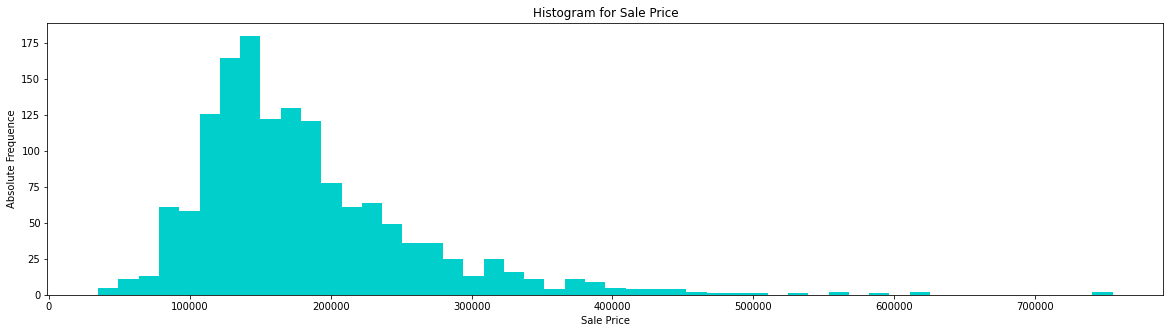

In [ ]:
# Plotting results for fast comparisson
f, axs = plt.subplots(1,1,figsize=(20,5))
plt.subplot(1, 1, 1)
plt.hist(df["SalePrice"], label='Train', density=False, color ="#00cfcc", bins=50)
plt.xlabel('Sale Price')
plt.ylabel('Absolute Frequence')
plt.title(r'Histogram for Sale Price')
plt.show()

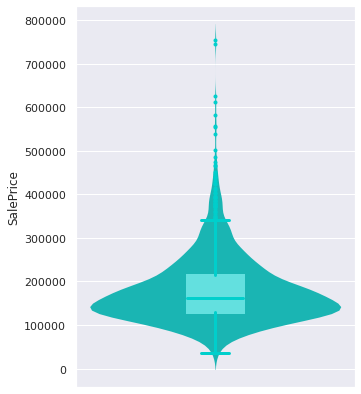

In [ ]:
# Violin plot for SalePrice
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

ax = sns.violinplot(data=df, y='SalePrice', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=df, y='SalePrice', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

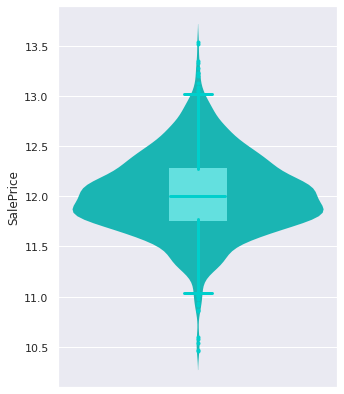

In [ ]:
# Apply log (1 + SalesPrice) to correct skewness 
df["SalePrice"] = np.log1p(df["SalePrice"])

# Violin plot for SalePrice
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

ax = sns.violinplot(data=df, y='SalePrice', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=df, y='SalePrice', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

## Reviewing exploratory variables

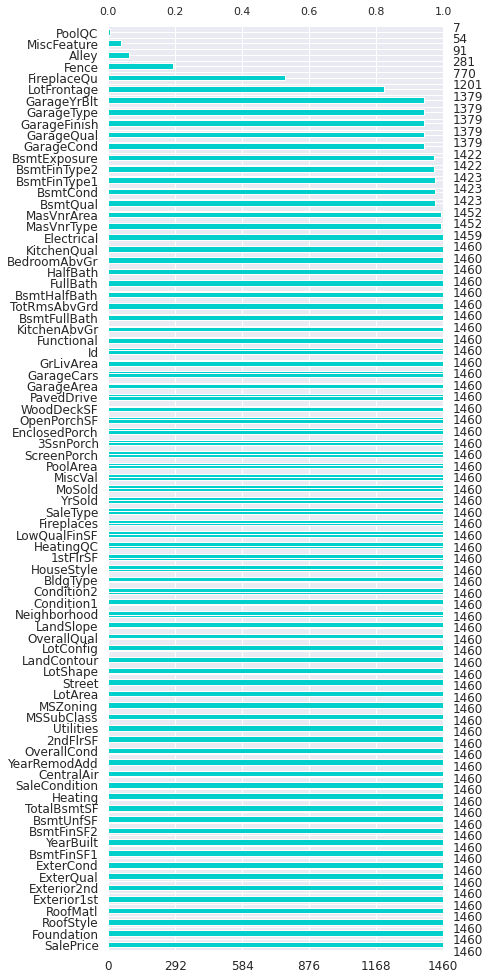

In [ ]:
# Bar plot of missing values and percentage
msno.bar(df, labels=False, figsize=(6,17), fontsize=12, sort="descending", color="#00cfcc")

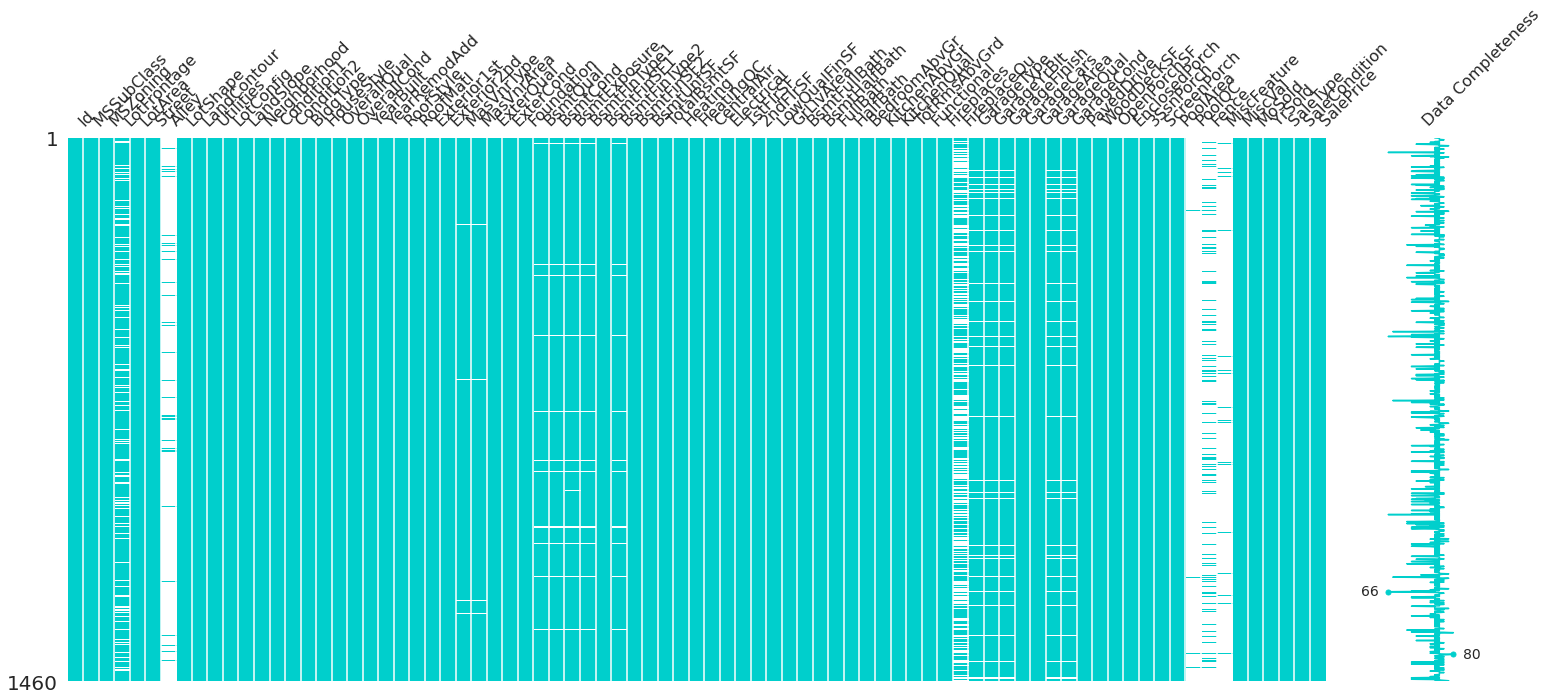

In [ ]:
# Matrix showing the pisitions of the missing values for each variable
msno.matrix(df, labels=True, color = (0/255,207/255,204/255))

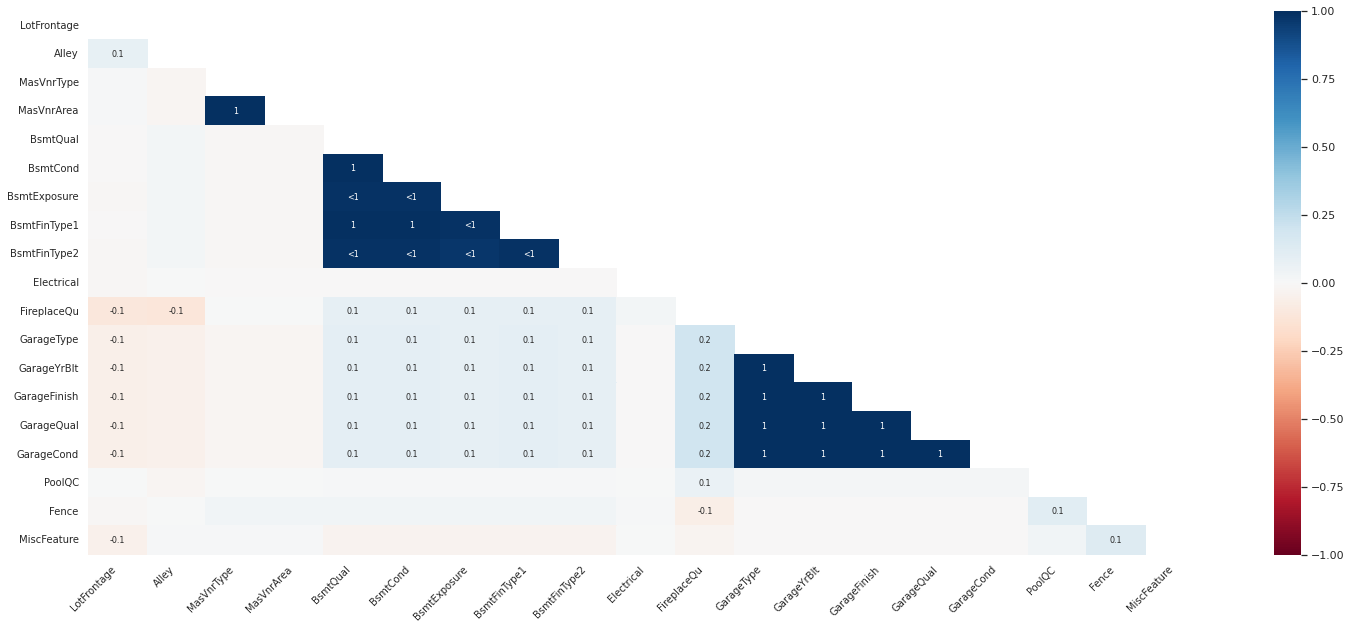

In [ ]:
# Heat map showing correlation among variables
msno.heatmap(df, figsize=(25,10), fontsize=10)

In [ ]:
# Execute univariate analysis (mainly or quantivative variables)
our_summary = full_describe(dataframe = df , variability = 20 , completeness = 10)

Describe process started, Time: 07:48:16
Describe function calculatation finished. Elapsed Time: 0 segs
Inicia calculo de completeness and variability, Time: 07:48:16
Completeness and variability calculation finished. Elapsed time: 0 segs
Whole process completed. Total Elapsed time: 0 segs


In [ ]:
# Export summary to excel fileon the actual local machine to review
our_summary.to_excel('resumen_variables.xlsx', sheet_name = 'resumen')
# files.download("resumen_variables.xlsx")

[[1.0 0.4308089564200311]
 [0.4308089564200311 1.0]]


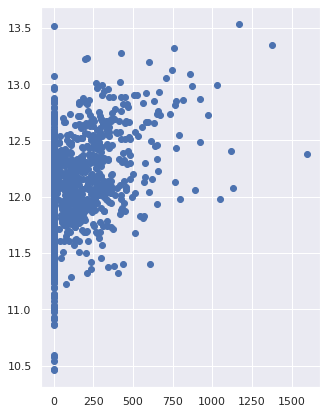

In [ ]:
# Calculate correlation graphs for variables with missing values

plt.scatter(df.MasVnrArea, df.SalePrice)
import numpy.ma as ma
print(ma.corrcoef(ma.masked_invalid(df.MasVnrArea), ma.masked_invalid(df.SalePrice)))

{'boxes': [<matplotlib.lines.Line2D at 0x7f3085a808d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3085a7b950>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3085a75ed0>],
 'means': [<matplotlib.lines.Line2D at 0x7f3085a75990>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3085a75450>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3085a80e90>,
  <matplotlib.lines.Line2D at 0x7f3085a7b410>]}

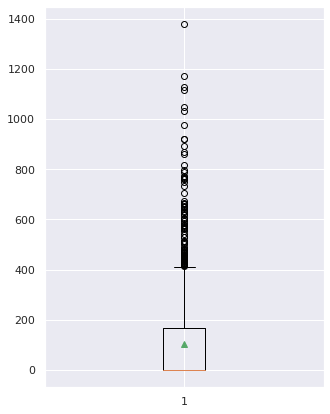

In [ ]:
plt.boxplot(df.MasVnrArea[df.MasVnrArea<1600], showmeans=True)

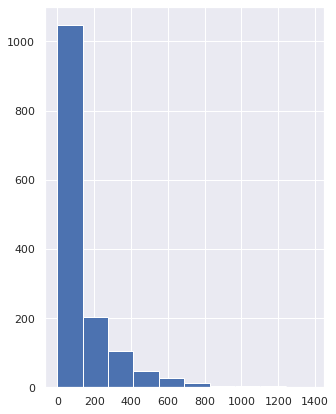

In [ ]:
plt.hist(df.MasVnrArea[df.MasVnrArea<1600])
plt.show()

[[1.0 0.5410727772673495]
 [0.5410727772673495 1.0]]


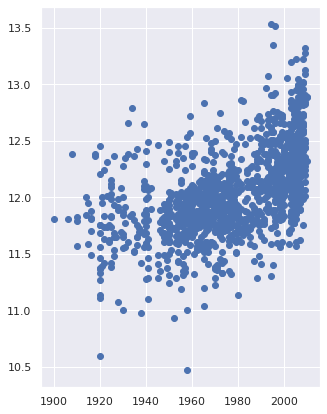

In [ ]:
plt.scatter(df.GarageYrBlt, df.SalePrice)
import numpy.ma as ma
print(ma.corrcoef(ma.masked_invalid(df.GarageYrBlt), ma.masked_invalid(df.SalePrice)))

{'boxes': [<matplotlib.lines.Line2D at 0x7f308589e7d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3085823850>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f308582add0>],
 'means': [<matplotlib.lines.Line2D at 0x7f308582a890>],
 'medians': [<matplotlib.lines.Line2D at 0x7f308582a350>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f308589ed90>,
  <matplotlib.lines.Line2D at 0x7f3085823310>]}

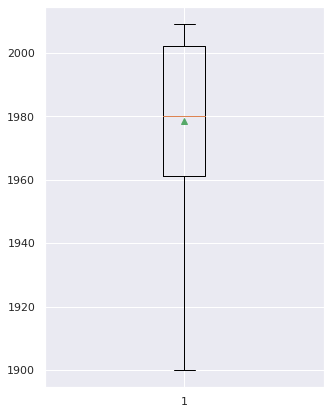

In [ ]:
plt.boxplot(df.GarageYrBlt[df.GarageYrBlt<2010], showmeans=True)

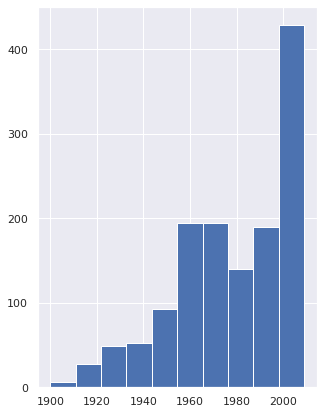

In [ ]:
plt.hist(df.GarageYrBlt[df.GarageYrBlt<2010])
plt.show()

In [ ]:
# Imputing missing values with median
df["LotFrontage"] = df.LotFrontage.fillna(df.LotFrontage.median())
df["MasVnrArea"] = df.MasVnrArea.fillna(df.MasVnrArea.median())
df["GarageYrBlt"] = df.GarageYrBlt.fillna(df.GarageYrBlt.median())


# df["BsmtFinSF1"] = df.BsmtFinSF1.fillna(df.BsmtFinSF1.median())
# df["BsmtFinSF2"] = df.BsmtFinSF2.fillna(df.BsmtFinSF2.median())
# df["BsmtUnfSF"] = df.BsmtUnfSF.fillna(df.BsmtUnfSF.median())
# df["TotalBsmtSF"] = df.TotalBsmtSF.fillna(df.TotalBsmtSF.median())
# df["BsmtFullBath"] = df.BsmtFullBath.fillna(df.BsmtFullBath.median())
# df["BsmtHalfBath"] = df.BsmtHalfBath.fillna(df.BsmtHalfBath.median())
# df["GarageCars"] = df.LotFrontage.fillna(df.GarageCars.median())
# df["GarageArea"] = df.GarageArea.fillna(df.GarageArea.median())

print(df[["MasVnrArea","GarageYrBlt","LotFrontage"]].isna().sum())

MasVnrArea     0
GarageYrBlt    0
LotFrontage    0
dtype: int64


In [ ]:
# Imputing missing values with median
df["Alley"] = df.Alley.fillna(df.Alley.mode()[0])
df["MasVnrType"] = df.MasVnrType.fillna(df.MasVnrType.mode()[0])
df["BsmtQual"] = df.BsmtQual.fillna(df.BsmtQual.mode()[0])
df["BsmtCond"] = df.BsmtCond.fillna(df.BsmtCond.mode()[0])
df["BsmtExposure"] = df.BsmtExposure.fillna(df.BsmtExposure.mode()[0])
df["BsmtFinType1"] = df.BsmtFinType1.fillna(df.BsmtFinType1.mode()[0])
df["BsmtFinType2"] = df.BsmtFinType2.fillna(df.BsmtFinType2.mode()[0])
df["Electrical"] = df.Electrical.fillna(df.Electrical.mode()[0])
df["FireplaceQu"] = df.FireplaceQu.fillna(df.FireplaceQu.mode()[0])
df["GarageType"] = df.GarageType.fillna(df.GarageType.mode()[0])
df["GarageFinish"] = df.GarageFinish.fillna(df.GarageFinish.mode()[0])
df["GarageQual"] = df.GarageQual.fillna(df.GarageQual.mode()[0])
df["GarageCond"] = df.GarageCond.fillna(df.GarageCond.mode()[0])
df["PoolQC"] = df.PoolQC.fillna(df.PoolQC.mode()[0])
df["Fence"] = df.Fence.fillna(df.Fence.mode()[0])
df["MiscFeature"] = df.MiscFeature.fillna(df.MiscFeature.mode()[0])


# df["MSZoning"] = df.MSZoning.fillna(df.MSZoning.mode()[0])
# df["Street"] = df.Street.fillna(df.Street.mode()[0])
# df["LotShape"] = df.LotShape.fillna(df.LotShape.mode()[0])
# df["LandContour"] = df.LandContour.fillna(df.LandContour.mode()[0])
# df["Utilities"] = df.Utilities.fillna(df.Utilities.mode()[0])
# df["LotConfig"] = df.LotConfig.fillna(df.LotConfig.mode()[0])
# df["LandSlope"] = df.LandSlope.fillna(df.LandSlope.mode()[0])
# df["Neighborhood"] = df.Neighborhood.fillna(df.Neighborhood.mode()[0])
# df["Condition1"] = df.Condition1.fillna(df.Condition1.mode()[0])
# df["Condition2"] = df.Condition2.fillna(df.Condition2.mode()[0])
# df["BldgType"] = df.BldgType.fillna(df.BldgType.mode()[0])
# df["HouseStyle"] = df.HouseStyle.fillna(df.HouseStyle.mode()[0])
# df["RoofStyle"] = df.RoofStyle.fillna(df.RoofStyle.mode()[0])
# df["RoofMatl"] = df.RoofMatl.fillna(df.RoofMatl.mode()[0])
# df["Exterior1st"] = df.Exterior1st.fillna(df.Exterior1st.mode()[0])
# df["Exterior2nd"] = df.Exterior2nd.fillna(df.Exterior2nd.mode()[0])
# df["ExterQual"] = df.ExterQual.fillna(df.ExterQual.mode()[0])
# df["ExterCond"] = df.ExterCond.fillna(df.ExterCond.mode()[0])
# df["Foundation"] = df.Foundation.fillna(df.Foundation.mode()[0])
# df["Heating"] = df.Heating.fillna(df.Heating.mode()[0])
# df["HeatingQC"] = df.HeatingQC.fillna(df.HeatingQC.mode()[0])
# df["CentralAir"] = df.CentralAir.fillna(df.CentralAir.mode()[0])
# df["KitchenQual"] = df.KitchenQual.fillna(df.KitchenQual.mode()[0])
# df["Functional"] = df.Functional.fillna(df.Functional.mode()[0])
# df["PavedDrive"] = df.PavedDrive.fillna(df.PavedDrive.mode()[0])
# df["SaleType"] = df.SaleType.fillna(df.SaleType.mode()[0])
# df["SaleCondition"] = df.SaleCondition.fillna(df.SaleCondition.mode()[0])


print(df[["MasVnrType","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","Electrical","GarageType"
,"GarageFinish","GarageQual","GarageCond"]].isna().sum())

MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64


count    1460.000000
mean        5.575342
std         1.112799
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: OverallCond, dtype: float64


{'boxes': [<matplotlib.lines.Line2D at 0x7f308576da10>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3085760a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f308577e050>],
 'means': [<matplotlib.lines.Line2D at 0x7f3085773ad0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3085773590>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f308576dfd0>,
  <matplotlib.lines.Line2D at 0x7f3085760550>]}

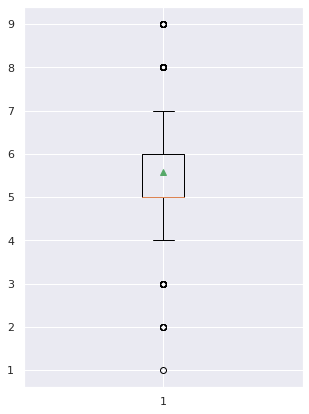

In [ ]:
# Check outliers for each desired variable
variable = 'OverallCond' 
print(df[variable].describe())
plt.boxplot(df[variable], showmeans=True)

In [ ]:
# Define cuantitative variables to be upper and lower capped 
vars_upper_cap = ['MSSubClass','LotArea','OverallCond','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch']
vars_lower_cap = ['LotArea','OverallQual','OverallCond','YearBuilt','TotalBsmtSF','BedroomAbvGr','GarageYrBlt']

In [ ]:
# Capping values with 95th and 5th percentiles
for col in df.columns:
    if(df[col].dtype) != 'O':
      if col in vars_upper_cap:
        df[col] = pd.Series(np.where(df[col] >= df[col].quantile(0.95), df[col].quantile(0.95), df[col]))
        # print(col)
        # print(df[col].values)
      if col in vars_lower_cap:
        df[col] = pd.Series(np.where(df[col] <= df[col].quantile(0.05), df[col].quantile(0.05), df[col]))
        # print(col)
        # print(df[col].values)

In [ ]:
# Execute univariate analysis (mainly or quantivative variables)
our_summary = full_describe(dataframe = df , variability = 20 , completeness = 10)
# Export summary to excel file on the actual local machine to review
our_summary.to_excel('resumen_variables_acot.xlsx', sheet_name = 'resumen_acot')
# files.download("resumen_variables_acot.xlsx")

Describe process started, Time: 07:48:23
Describe function calculatation finished. Elapsed Time: 0 segs
Inicia calculo de completeness and variability, Time: 07:48:24
Completeness and variability calculation finished. Elapsed time: 0 segs
Whole process completed. Total Elapsed time: 0 segs


In [ ]:
# Calculate correlation matrix to check correlation with the response variable SalePrice
corr_matrix = df.corr()
corr_matrix = corr_matrix[['SalePrice']].sort_values('SalePrice',ascending=False)
# Export summary to excel file on the actual local machine to review
corr_matrix.to_excel('correlation.xlsx', sheet_name = 'correlation')
# files.download("correlation.xlsx")

In [ ]:
var_cualquiera = list(set(df.MasVnrType.values))
var_cualquiera

['Stone', 'BrkFace', 'BrkCmn', 'None']

In [ ]:
df.MasVnrType.value_counts()

None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [ ]:
''' Calculating correlation of all the categorical Variables against the ['SalePrice'] one at the time '''

# List with all categoricals Variables
lista_variables = ["LotShape","MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Electrical", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "MSZoning", "Street", "Alley", 
                   "LandContour", "Utilities", "LotConfig", "LandSlope","Neighborhood","Condition1","Condition2","BldgType","HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd","ExterQual","ExterCond",
                   "Foundation","Heating","HeatingQC","CentralAir","KitchenQual" ,"Functional","PavedDrive","PoolQC","Fence","MiscFeature","SaleType","SaleCondition"]

X = []
corr_vars_cat = pd.DataFrame(columns=['variable','fvalue','pvalue','-log_pvalue'])
# we iterate over each variable
for variable in tqdm(lista_variables):
    # We need to clear the list for each iteration.
    X.clear()   
    # then, for each variable, we iterate over each one of its category
    for categoria in list(set(df[variable].values)):
        res = df.loc[df[variable] == categoria]['SalePrice']
        X.append(res)

    fvalue, pvalue = stats.kruskal(*X, nan_policy = 'omit')
    
    row_to_append = pd.DataFrame({'variable': [variable], 'fvalue': [fvalue], 'pvalue': [pvalue], '-log_pvalue': [-np.log(pvalue)]})
    corr_vars_cat = pd.concat([corr_vars_cat, row_to_append], axis=0)
    # print("===============================================================================================================")
    # print("test: F-value",fvalue,"P-value", pvalue,"-log(P-value)",-np.log(pvalue))
    #print("VAR:{0:s} CAT:{1:s} F-VAL:{2:10.6f} PVAL:{3:10.6f} LOG:{4:10.6f}".format(variable, categoria, fvalue, pvalue, -np.log(pvalue)))


corr_vars_cat.sort_values('-log_pvalue', ascending = False)

100%|██████████| 42/42 [00:01<00:00, 31.89it/s]


,variable,fvalue,pvalue,-log_pvalue
0,Neighborhood,868.532376,6.696799e-168,384.932666
0,ExterQual,683.440084,8.180798e-148,338.680804
0,KitchenQual,661.481587,4.720113e-143,327.717836
0,BsmtQual,659.020743,1.612542e-142,326.489272
0,GarageFinish,578.915601,1.950179e-126,289.457801
0,Foundation,488.722751,2.169096e-103,236.391954
0,HeatingQC,356.776407,6.036449e-76,173.198651
0,GarageType,339.621474,3.001070e-71,162.384573
0,BsmtFinType1,305.776912,5.735444e-64,145.618781
0,MasVnrType,270.812881,2.058731e-58,132.827846


# Modelling

# Applying Multiple Linear regression technique

In [ ]:
# Create dummie variables and stack them with the previous dataframe
new_df = pd.concat([df, pd.get_dummies(df.MSZoning, prefix='MSZoning',drop_first=True)
          ,pd.get_dummies(df.Street, prefix='Street',drop_first=True)
          ,pd.get_dummies(df.Alley, prefix='Alley',drop_first=True)
          ,pd.get_dummies(df.LotShape, prefix='LotShape',drop_first=True)
          ,pd.get_dummies(df.LandContour, prefix='LandContour',drop_first=True)
          ,pd.get_dummies(df.Utilities, prefix='Utilities',drop_first=True)
          ,pd.get_dummies(df.LotConfig, prefix='LotConfig',drop_first=True)
          ,pd.get_dummies(df.LandSlope, prefix='LandSlope',drop_first=True)
          ,pd.get_dummies(df.Neighborhood, prefix='Neighborhood',drop_first=True)
          ,pd.get_dummies(df.Condition1, prefix='Condition1',drop_first=True)
          ,pd.get_dummies(df.Condition2, prefix='Condition2',drop_first=True) 
          ,pd.get_dummies(df.BldgType, prefix='BldgType',drop_first=True)
          ,pd.get_dummies(df.HouseStyle, prefix='HouseStyle',drop_first=True)
          ,pd.get_dummies(df.RoofStyle, prefix='RoofStyle',drop_first=True)
          ,pd.get_dummies(df.RoofMatl, prefix='RoofMatl',drop_first=True)
          ,pd.get_dummies(df.Exterior1st, prefix='Exterior1st',drop_first=True)
          ,pd.get_dummies(df.Exterior2nd, prefix='Exterior2nd',drop_first=True)
          ,pd.get_dummies(df.MasVnrType, prefix='MasVnrType',drop_first=True)
          ,pd.get_dummies(df.ExterQual, prefix='ExterQual',drop_first=True)
          ,pd.get_dummies(df.ExterCond, prefix='ExterCond',drop_first=True)
          ,pd.get_dummies(df.Foundation, prefix='Foundation',drop_first=True)
          ,pd.get_dummies(df.BsmtQual, prefix='BsmtQual',drop_first=True)
          ,pd.get_dummies(df.BsmtCond, prefix='BsmtCond',drop_first=True)
          ,pd.get_dummies(df.BsmtExposure, prefix='BsmtExposure',drop_first=True)
          ,pd.get_dummies(df.BsmtFinType1, prefix='BsmtFinType1',drop_first=True)
          ,pd.get_dummies(df.BsmtFinType2, prefix='BsmtFinType2',drop_first=True)
          ,pd.get_dummies(df.Heating, prefix='Heating',drop_first=True)
          ,pd.get_dummies(df.HeatingQC, prefix='HeatingQC',drop_first=True)
          ,pd.get_dummies(df.CentralAir, prefix='CentralAir',drop_first=True)
          ,pd.get_dummies(df.Electrical, prefix='Electrical',drop_first=True)
          ,pd.get_dummies(df.KitchenQual, prefix='KitchenQual',drop_first=True)
          ,pd.get_dummies(df.Functional, prefix='Functional',drop_first=True)
          ,pd.get_dummies(df.FireplaceQu, prefix='FireplaceQu',drop_first=True)
          ,pd.get_dummies(df.GarageType, prefix='GarageType',drop_first=True)
          ,pd.get_dummies(df.GarageFinish, prefix='GarageFinish',drop_first=True)
          ,pd.get_dummies(df.GarageQual, prefix='GarageQual',drop_first=True)
          ,pd.get_dummies(df.GarageCond, prefix='GarageCond',drop_first=True)
          ,pd.get_dummies(df.PavedDrive, prefix='PavedDrive',drop_first=True)
          ,pd.get_dummies(df.PoolQC, prefix='PoolQC',drop_first=True)
          ,pd.get_dummies(df.Fence, prefix='Fence',drop_first=True)
          ,pd.get_dummies(df.MiscFeature, prefix='MiscFeature',drop_first=True)
          ,pd.get_dummies(df.SaleType, prefix='SaleType',drop_first=True)
          ,pd.get_dummies(df.SaleCondition, prefix='SaleCondition',drop_first=True)
          ], axis=1)

In [ ]:
# Reviewing the categories of categorical variables
var_desired = 'RoofStyle'
print(new_df[var_desired].value_counts())
new_df.columns[new_df.columns.str.contains(var_desired)]

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64


Index(['RoofStyle', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip',
       'RoofStyle_Mansard', 'RoofStyle_Shed'],
      dtype='object')

In [ ]:
# Select the explanatory variables to be used
vars_select = ['OverallQual','Fireplaces','HalfBath','BsmtFullBath','BedroomAbvGr','KitchenAbvGr','OverallCond','MSSubClass']
# 'OverallQual','OpenPorchSF'
# 'OverallQual','Fireplaces','HalfBath','BsmtFullBath','BedroomAbvGr','KitchenAbvGr','OverallCond','MSSubClass'
x = new_df.loc[:, new_df.columns.isin(vars_select)].copy()
# Add a column full of 1 to estimate the intercept parameter 
x = sm.add_constant(x)

# Select the response variable
# y = np.log(new_df.loc[:, new_df.columns == "SalePrice"].copy())
y = new_df.loc[:, new_df.columns == "SalePrice"].copy()

# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 30% of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

# Define model
model = sm.OLS(y_train, x_train)
# Fit model
results = model.fit()
print(results.summary())

X Train shape: (876, 9)
Y Train shape: (876, 1)
X Validation shape: (292, 9)
Y Validation shape: (292, 1)
X Test shape: (292, 9)
Y Test shape: (292, 1)
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     319.4
Date:                Tue, 22 Feb 2022   Prob (F-statistic):          1.91e-252
Time:                        07:48:27   Log-Likelihood:                 147.62
No. Observations:                 876   AIC:                            -277.2
Df Residuals:                     867   BIC:                            -234.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# Checking assumptions
# Multicolinearity
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
aux = x_train.drop(['const'],axis=1)
# aux = x_train.copy()
vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
vif["features"] = aux.columns
print("======================================================================================")
print("Multicolinarity check using VIF:")
print(vif.sort_values('VIF Factor',ascending=False).round(1))

# Get residuals
residuals = results.resid

# Independence of errors
print("======================================================================================")
print("Independence of errors check using Durbin-Watson test:")
dw_stats = sm.stats.stattools.durbin_watson(residuals, axis=0)
print("D-W statistic:", dw_stats)
if dw_stats <= 2.5 and dw_stats >= 1.5:
  print("Residuals are independent")
else:
  print("Residuals are NOT independent")

# Homocedasticity
fvalue, f_pvalue, ordering = sm.stats.diagnostic.het_goldfeldquandt(y_train, x_train)
print("======================================================================================")
print("Homocedasticity check using Goldfeld-Quandt test:")
print("F-value",fvalue,"P-value", f_pvalue)

print("======================================================================================")
# Predict values of regression with train
ypred_train = pd.DataFrame(results.predict(x_train))
# Predict values of regression with validation
ypred_val = pd.DataFrame(results.predict(x_val))
# Predict values of regression with test
ypred_test = pd.DataFrame(results.predict(x_test))

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {}, {}, {}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

Multicolinarity check using VIF:
   VIF Factor      features
5        23.1  BedroomAbvGr
6        21.7  KitchenAbvGr
1        20.1   OverallQual
2        19.2   OverallCond
0         3.4    MSSubClass
7         2.4    Fireplaces
4         2.0      HalfBath
3         1.7  BsmtFullBath
Independence of errors check using Durbin-Watson test:
D-W statistic: 1.9700025990482866
Residuals are independent
Homocedasticity check using Goldfeld-Quandt test:
F-value 0.7335789385461831 P-value 0.9993135811064957
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.20444639970840464, 0.2012188273577425, 0.1997794564110705


# Applying XG-Boost technique

In [ ]:
# Create dummie variables and stack them with the previous dataframe
new_df = pd.concat([df, pd.get_dummies(df.MSZoning, prefix='MSZoning_DM',drop_first=False)
          ,pd.get_dummies(df.Street, prefix='Street_DM',drop_first=False)
          ,pd.get_dummies(df.Alley, prefix='Alley_DM',drop_first=False)
          ,pd.get_dummies(df.LotShape, prefix='LotShape_DM',drop_first=False)
          ,pd.get_dummies(df.LandContour, prefix='LandContour_DM',drop_first=False)
          ,pd.get_dummies(df.Utilities, prefix='Utilities_DM',drop_first=False)
          ,pd.get_dummies(df.LotConfig, prefix='LotConfig_DM',drop_first=False)
          ,pd.get_dummies(df.LandSlope, prefix='LandSlope_DM',drop_first=False)
          ,pd.get_dummies(df.Neighborhood, prefix='Neighborhood_DM',drop_first=False)
          ,pd.get_dummies(df.Condition1, prefix='Condition1_DM',drop_first=False)
          ,pd.get_dummies(df.Condition2, prefix='Condition2_DM',drop_first=False)
          ,pd.get_dummies(df.BldgType, prefix='BldgType_DM',drop_first=False)
          ,pd.get_dummies(df.HouseStyle, prefix='HouseStyle_DM',drop_first=False)
          ,pd.get_dummies(df.RoofStyle, prefix='RoofStyle_DM',drop_first=False)
          ,pd.get_dummies(df.RoofMatl, prefix='RoofMatl_DM',drop_first=False)
          ,pd.get_dummies(df.Exterior1st, prefix='Exterior1st_DM',drop_first=False)
          ,pd.get_dummies(df.Exterior2nd, prefix='Exterior2nd_DM',drop_first=False)
          ,pd.get_dummies(df.MasVnrType, prefix='MasVnrType_DM',drop_first=False)
          ,pd.get_dummies(df.ExterQual, prefix='ExterQual_DM',drop_first=False)
          ,pd.get_dummies(df.ExterCond, prefix='ExterCond_DM',drop_first=False)
          ,pd.get_dummies(df.Foundation, prefix='Foundation_DM',drop_first=False)
          ,pd.get_dummies(df.BsmtQual, prefix='BsmtQual_DM',drop_first=False)
          ,pd.get_dummies(df.BsmtCond, prefix='BsmtCond_DM',drop_first=False)
          ,pd.get_dummies(df.BsmtExposure, prefix='BsmtExposure_DM',drop_first=False)
          ,pd.get_dummies(df.BsmtFinType1, prefix='BsmtFinType1_DM',drop_first=False)
          ,pd.get_dummies(df.BsmtFinType2, prefix='BsmtFinType2_DM',drop_first=False)
          ,pd.get_dummies(df.Heating, prefix='Heating_DM',drop_first=False)
          ,pd.get_dummies(df.HeatingQC, prefix='HeatingQC_DM',drop_first=False)
          ,pd.get_dummies(df.CentralAir, prefix='CentralAir_DM',drop_first=False)
          ,pd.get_dummies(df.Electrical, prefix='Electrical_DM',drop_first=False)
          ,pd.get_dummies(df.KitchenQual, prefix='KitchenQual_DM',drop_first=False)
          ,pd.get_dummies(df.Functional, prefix='Functional_DM',drop_first=False)
          ,pd.get_dummies(df.FireplaceQu, prefix='FireplaceQu_DM',drop_first=False)
          ,pd.get_dummies(df.GarageType, prefix='GarageType_DM',drop_first=False)
          ,pd.get_dummies(df.GarageFinish, prefix='GarageFinish_DM',drop_first=False)
          ,pd.get_dummies(df.GarageQual, prefix='GarageQual_DM',drop_first=False)
          ,pd.get_dummies(df.GarageCond, prefix='GarageCond_DM',drop_first=False)
          ,pd.get_dummies(df.PavedDrive, prefix='PavedDrive_DM',drop_first=False)
          ,pd.get_dummies(df.PoolQC, prefix='PoolQC_DM',drop_first=False)
          ,pd.get_dummies(df.Fence, prefix='Fence_DM',drop_first=False)
          ,pd.get_dummies(df.MiscFeature, prefix='MiscFeature_DM',drop_first=False)
          ,pd.get_dummies(df.SaleType, prefix='SaleType_DM',drop_first=False)
          ,pd.get_dummies(df.SaleCondition, prefix='SaleCondition_DM',drop_first=False)
          ], axis=1)

# pd.DataFrame(new_df.columns).to_csv("categorical_and_dummies.csv", index = False) 
# files.download("categorical_and_dummies.csv")

# Create dataframes to store models calculated to apply ensemble method
df_train_ens = pd.DataFrame()
df_test_ens = pd.DataFrame()
df_val_ens = pd.DataFrame()
df_eva_ens = pd.DataFrame()

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

# Select the explanatory variables to be used
vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','TotRmsAbvGrd','YearRemodAdd'
 ,'GarageYrBlt','Fireplaces','MasVnrArea','LotArea','BsmtFinSF1','OpenPorchSF','LotFrontage','WoodDeckSF','HalfBath','2ndFlrSF'
 ,'BsmtFullBath','BedroomAbvGr','BsmtUnfSF','EnclosedPorch','KitchenAbvGr','OverallCond','ScreenPorch','PoolArea','MSSubClass'
 ,'MoSold','BsmtFinSF2','3SsnPorch','YrSold','LowQualFinSF','MiscVal','BsmtHalfBath' 

,'MSZoning_DM_C (all)','MSZoning_DM_FV','MSZoning_DM_RH','MSZoning_DM_RL','MSZoning_DM_RM','Street_DM_Grvl','Street_DM_Pave'
,'Alley_DM_Grvl','Alley_DM_Pave','LotShape_DM_IR1','LotShape_DM_IR2','LotShape_DM_IR3','LotShape_DM_Reg','LandContour_DM_Bnk'
,'LandContour_DM_HLS','LandContour_DM_Low','LandContour_DM_Lvl','Utilities_DM_AllPub','LotConfig_DM_Corner'
,'LotConfig_DM_CulDSac','LotConfig_DM_FR2','LotConfig_DM_FR3','LotConfig_DM_Inside','LandSlope_DM_Gtl','LandSlope_DM_Mod'
,'LandSlope_DM_Sev','Neighborhood_DM_Blmngtn','Neighborhood_DM_Blueste','Neighborhood_DM_BrDale','Neighborhood_DM_BrkSide'
,'Neighborhood_DM_ClearCr','Neighborhood_DM_CollgCr','Neighborhood_DM_Crawfor','Neighborhood_DM_Edwards','Neighborhood_DM_Gilbert'
,'Neighborhood_DM_IDOTRR','Neighborhood_DM_MeadowV','Neighborhood_DM_Mitchel','Neighborhood_DM_NAmes','Neighborhood_DM_NPkVill'
,'Neighborhood_DM_NWAmes','Neighborhood_DM_NoRidge','Neighborhood_DM_NridgHt','Neighborhood_DM_OldTown','Neighborhood_DM_SWISU'
,'Neighborhood_DM_Sawyer','Neighborhood_DM_SawyerW','Neighborhood_DM_Somerst','Neighborhood_DM_StoneBr','Neighborhood_DM_Timber'
,'Neighborhood_DM_Veenker','Condition1_DM_Artery','Condition1_DM_Feedr','Condition1_DM_Norm','Condition1_DM_PosA','Condition1_DM_PosN'
,'Condition1_DM_RRAe','Condition1_DM_RRAn','Condition1_DM_RRNe','Condition1_DM_RRNn','Condition2_DM_Artery','Condition2_DM_Feedr'
,'Condition2_DM_Norm','Condition2_DM_PosA','Condition2_DM_PosN'
,'BldgType_DM_1Fam','BldgType_DM_2fmCon','BldgType_DM_Duplex','BldgType_DM_Twnhs','BldgType_DM_TwnhsE','HouseStyle_DM_1.5Fin'
,'HouseStyle_DM_1.5Unf','HouseStyle_DM_1Story','HouseStyle_DM_2.5Unf','HouseStyle_DM_2Story','HouseStyle_DM_SFoyer'
,'HouseStyle_DM_SLvl','RoofStyle_DM_Flat','RoofStyle_DM_Gable','RoofStyle_DM_Gambrel','RoofStyle_DM_Hip','RoofStyle_DM_Mansard'
,'RoofStyle_DM_Shed','RoofMatl_DM_CompShg'
,'RoofMatl_DM_Tar&Grv','RoofMatl_DM_WdShake','RoofMatl_DM_WdShngl','Exterior1st_DM_AsbShng','Exterior1st_DM_AsphShn'
,'Exterior1st_DM_BrkComm','Exterior1st_DM_BrkFace','Exterior1st_DM_CBlock','Exterior1st_DM_CemntBd','Exterior1st_DM_HdBoard'
,'Exterior1st_DM_MetalSd','Exterior1st_DM_Plywood','Exterior1st_DM_Stucco'
,'Exterior1st_DM_VinylSd','Exterior1st_DM_Wd Sdng','Exterior1st_DM_WdShing','Exterior2nd_DM_AsbShng','Exterior2nd_DM_AsphShn'
,'Exterior2nd_DM_Brk Cmn','Exterior2nd_DM_BrkFace','Exterior2nd_DM_CBlock','Exterior2nd_DM_CmentBd','Exterior2nd_DM_HdBoard'
,'Exterior2nd_DM_ImStucc','Exterior2nd_DM_MetalSd','Exterior2nd_DM_Plywood','Exterior2nd_DM_Stone'
,'Exterior2nd_DM_Stucco','Exterior2nd_DM_VinylSd','Exterior2nd_DM_Wd Sdng','Exterior2nd_DM_Wd Shng','MasVnrType_DM_BrkCmn'
,'MasVnrType_DM_BrkFace','MasVnrType_DM_None','MasVnrType_DM_Stone','ExterQual_DM_Ex','ExterQual_DM_Fa','ExterQual_DM_Gd'
,'ExterQual_DM_TA','ExterCond_DM_Ex','ExterCond_DM_Fa','ExterCond_DM_Gd','ExterCond_DM_Po','ExterCond_DM_TA','Foundation_DM_BrkTil'
,'Foundation_DM_CBlock','Foundation_DM_PConc','Foundation_DM_Slab','Foundation_DM_Stone','Foundation_DM_Wood','BsmtQual_DM_Ex'
,'BsmtQual_DM_Fa','BsmtQual_DM_Gd','BsmtQual_DM_TA','BsmtCond_DM_Fa','BsmtCond_DM_Gd','BsmtCond_DM_Po','BsmtCond_DM_TA','BsmtExposure_DM_Av'
,'BsmtExposure_DM_Gd','BsmtExposure_DM_Mn','BsmtExposure_DM_No','BsmtFinType1_DM_ALQ','BsmtFinType1_DM_BLQ','BsmtFinType1_DM_GLQ'
,'BsmtFinType1_DM_LwQ','BsmtFinType1_DM_Rec','BsmtFinType1_DM_Unf','BsmtFinType2_DM_ALQ','BsmtFinType2_DM_BLQ','BsmtFinType2_DM_GLQ'
,'BsmtFinType2_DM_LwQ','BsmtFinType2_DM_Rec','BsmtFinType2_DM_Unf','Heating_DM_GasA','Heating_DM_GasW','Heating_DM_Grav'
,'Heating_DM_Wall','HeatingQC_DM_Ex','HeatingQC_DM_Fa','HeatingQC_DM_Gd','HeatingQC_DM_Po','HeatingQC_DM_TA'
,'CentralAir_DM_N','CentralAir_DM_Y','Electrical_DM_FuseA','Electrical_DM_FuseF','Electrical_DM_FuseP'
,'Electrical_DM_SBrkr','KitchenQual_DM_Ex','KitchenQual_DM_Fa','KitchenQual_DM_Gd','KitchenQual_DM_TA','Functional_DM_Maj1'
,'Functional_DM_Maj2','Functional_DM_Min1','Functional_DM_Min2','Functional_DM_Mod','Functional_DM_Sev','Functional_DM_Typ'
,'FireplaceQu_DM_Ex','FireplaceQu_DM_Fa','FireplaceQu_DM_Gd','FireplaceQu_DM_Po','FireplaceQu_DM_TA','GarageType_DM_2Types'
,'GarageType_DM_Attchd','GarageType_DM_Basment','GarageType_DM_BuiltIn','GarageType_DM_CarPort','GarageType_DM_Detchd'
,'GarageFinish_DM_Fin','GarageFinish_DM_RFn','GarageFinish_DM_Unf','GarageQual_DM_Fa','GarageQual_DM_Gd'
,'GarageQual_DM_Po','GarageQual_DM_TA','GarageCond_DM_Ex','GarageCond_DM_Fa','GarageCond_DM_Gd','GarageCond_DM_Po'
,'GarageCond_DM_TA','PavedDrive_DM_N','PavedDrive_DM_P','PavedDrive_DM_Y','PoolQC_DM_Ex','PoolQC_DM_Gd'
,'Fence_DM_GdPrv','Fence_DM_GdWo','Fence_DM_MnPrv','Fence_DM_MnWw','MiscFeature_DM_Gar2','MiscFeature_DM_Othr','MiscFeature_DM_Shed'
,'SaleType_DM_COD','SaleType_DM_CWD','SaleType_DM_Con','SaleType_DM_ConLD','SaleType_DM_ConLI','SaleType_DM_ConLw'
,'SaleType_DM_New','SaleType_DM_Oth','SaleType_DM_WD','SaleCondition_DM_Abnorml','SaleCondition_DM_AdjLand','SaleCondition_DM_Alloca'
,'SaleCondition_DM_Family','SaleCondition_DM_Normal','SaleCondition_DM_Partial' 
               ]
  
# vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea']



x = new_df.loc[:, new_df.columns.isin(vars_select)].copy()
# Select the response variable (we take the long since it's recommended for large-scaled variables)
y = new_df.loc[:, new_df.columns == "SalePrice"].copy()
# y = np.log(new_df.loc[:, new_df.columns == "SalePrice"].copy())

# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 30% of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/XGboost_model.pkl','rb')
  xgb_grid = pickle.load(infile)

else:
  #Define the grid to be searched in
  xgb1 = XGBRegressor(random_state=0)
  parameters = {'max_depth':range(3,10,2),
              'min_child_weight':range(1,6,2),
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2]}

  #Execute cross-validated grid search
  xgb_grid = GridSearchCV(xgb1, parameters, cv = 5, n_jobs = -1, verbose=False)
  # Train Model
  xgb_grid.fit(x_train,y_train)
  #Save model
  with open(models_path + '/XGboost_model.pkl', 'wb') as pickfile:
     pickle.dump(xgb_grid, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(xgb_grid.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = pd.DataFrame(xgb_grid.best_estimator_.predict(x_train))
# Predict values of regression with validation
ypred_val = pd.DataFrame(xgb_grid.best_estimator_.predict(x_val))
# Predict values of regression with test
ypred_test = pd.DataFrame(xgb_grid.best_estimator_.predict(x_test))

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(xgb_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (876, 270)
Y Train shape: (876, 1)
X Validation shape: (292, 270)
Y Validation shape: (292, 1)
X Test shape: (292, 270)
Y Test shape: (292, 1)
[07:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found: 
{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.08302, 0.13481, 0.12110
Feature importance:
Ejecución: 1.1832728385925293 seconds


X Test shape: (1459, 270)


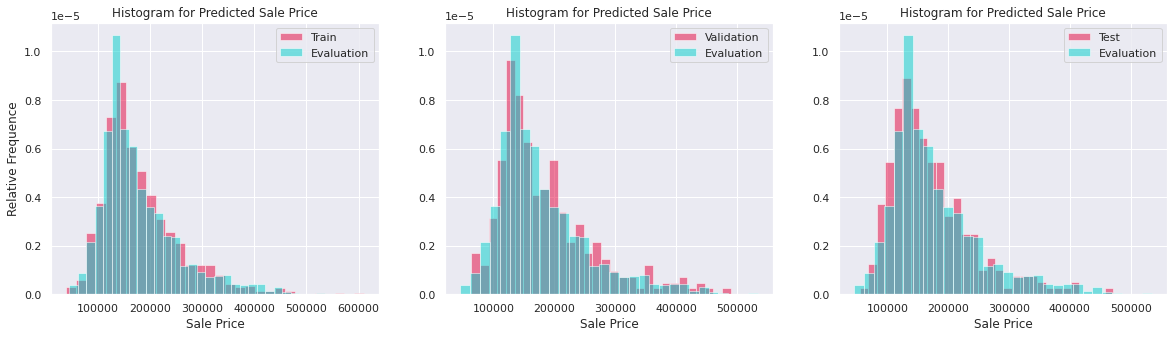

In [ ]:
#  Load test data
df_evaluation = pd.read_csv("test.csv", sep=",")

# Create dummie variables and stack them with the previous dataframe
df_evaluation = pd.concat([df_evaluation, pd.get_dummies(df_evaluation.MSZoning, prefix='MSZoning_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Street, prefix='Street_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Alley, prefix='Alley_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotShape, prefix='LotShape_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandContour, prefix='LandContour_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Utilities, prefix='Utilities_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotConfig, prefix='LotConfig_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandSlope, prefix='LandSlope_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Neighborhood, prefix='Neighborhood_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition1, prefix='Condition1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition2, prefix='Condition2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BldgType, prefix='BldgType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HouseStyle, prefix='HouseStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofStyle, prefix='RoofStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofMatl, prefix='RoofMatl_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior1st, prefix='Exterior1st_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior2nd, prefix='Exterior2nd_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MasVnrType, prefix='MasVnrType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterQual, prefix='ExterQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterCond, prefix='ExterCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Foundation, prefix='Foundation_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtQual, prefix='BsmtQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtCond, prefix='BsmtCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtExposure, prefix='BsmtExposure_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType1, prefix='BsmtFinType1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType2, prefix='BsmtFinType2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Heating, prefix='Heating_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HeatingQC, prefix='HeatingQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.CentralAir, prefix='CentralAir_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Electrical, prefix='Electrical_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.KitchenQual, prefix='KitchenQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Functional, prefix='Functional_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.FireplaceQu, prefix='FireplaceQu_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageType, prefix='GarageType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageFinish, prefix='GarageFinish_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageQual, prefix='GarageQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageCond, prefix='GarageCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PavedDrive, prefix='PavedDrive_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PoolQC, prefix='PoolQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Fence, prefix='Fence_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MiscFeature, prefix='MiscFeature_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleType, prefix='SaleType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleCondition, prefix='SaleCondition_DM',drop_first=False)
          ], axis=1)

# Select only used variables 
df_evaluation_mod = df_evaluation.loc[:, df_evaluation.columns.isin(vars_select)].copy()
print("X Test shape:",df_evaluation_mod.shape)

# Make prediction over evaluation data
df_evaluation_mod['SalePrice'] = np.expm1(pd.DataFrame(xgb_grid.best_estimator_.predict(df_evaluation_mod)))
df_evaluation_mod = pd.concat([df_evaluation['Id'].reset_index(drop=True), df_evaluation_mod['SalePrice']], axis=1)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(ypred_train.iloc[:,0]),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(ypred_val.iloc[:,0]),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(ypred_test.iloc[:,0]),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
df_evaluation_mod.to_csv(submissions_path + '/House_Prices_ART_XGBOOST_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'xgb'
df_train_ens = pd.concat([df_train_ens, np.expm1(ypred_train.iloc[:,0])], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens, np.expm1(ypred_val.iloc[:,0])], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens, np.expm1(ypred_test.iloc[:,0])], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation_mod.SalePrice], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# files.download("House_Prices_ART_XGBOOST_Jimenez_Riposati_v2.csv")

# Applying Random Forest technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

# Select the explanatory variables to be used
vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','TotRmsAbvGrd','YearRemodAdd'
 ,'GarageYrBlt','Fireplaces','MasVnrArea','LotArea','BsmtFinSF1','OpenPorchSF','LotFrontage','WoodDeckSF','HalfBath','2ndFlrSF'
 ,'BsmtFullBath','BedroomAbvGr','BsmtUnfSF','EnclosedPorch','KitchenAbvGr','OverallCond','ScreenPorch','PoolArea','MSSubClass'
 ,'MoSold','BsmtFinSF2','3SsnPorch','YrSold','LowQualFinSF','MiscVal','BsmtHalfBath'
 
,'MSZoning_DM_C (all)','MSZoning_DM_FV','MSZoning_DM_RH','MSZoning_DM_RL','MSZoning_DM_RM','Street_DM_Grvl','Street_DM_Pave'
,'Alley_DM_Grvl','Alley_DM_Pave','LotShape_DM_IR1','LotShape_DM_IR2','LotShape_DM_IR3','LotShape_DM_Reg','LandContour_DM_Bnk'
,'LandContour_DM_HLS','LandContour_DM_Low','LandContour_DM_Lvl','Utilities_DM_AllPub','LotConfig_DM_Corner'
,'LotConfig_DM_CulDSac','LotConfig_DM_FR2','LotConfig_DM_FR3','LotConfig_DM_Inside','LandSlope_DM_Gtl','LandSlope_DM_Mod'
,'LandSlope_DM_Sev','Neighborhood_DM_Blmngtn','Neighborhood_DM_Blueste','Neighborhood_DM_BrDale','Neighborhood_DM_BrkSide'
,'Neighborhood_DM_ClearCr','Neighborhood_DM_CollgCr','Neighborhood_DM_Crawfor','Neighborhood_DM_Edwards','Neighborhood_DM_Gilbert'
,'Neighborhood_DM_IDOTRR','Neighborhood_DM_MeadowV','Neighborhood_DM_Mitchel','Neighborhood_DM_NAmes','Neighborhood_DM_NPkVill'
,'Neighborhood_DM_NWAmes','Neighborhood_DM_NoRidge','Neighborhood_DM_NridgHt','Neighborhood_DM_OldTown','Neighborhood_DM_SWISU'
,'Neighborhood_DM_Sawyer','Neighborhood_DM_SawyerW','Neighborhood_DM_Somerst','Neighborhood_DM_StoneBr','Neighborhood_DM_Timber'
,'Neighborhood_DM_Veenker','Condition1_DM_Artery','Condition1_DM_Feedr','Condition1_DM_Norm','Condition1_DM_PosA','Condition1_DM_PosN'
,'Condition1_DM_RRAe','Condition1_DM_RRAn','Condition1_DM_RRNe','Condition1_DM_RRNn','Condition2_DM_Artery','Condition2_DM_Feedr'
,'Condition2_DM_Norm','Condition2_DM_PosA','Condition2_DM_PosN'
,'BldgType_DM_1Fam','BldgType_DM_2fmCon','BldgType_DM_Duplex','BldgType_DM_Twnhs','BldgType_DM_TwnhsE','HouseStyle_DM_1.5Fin'
,'HouseStyle_DM_1.5Unf','HouseStyle_DM_1Story','HouseStyle_DM_2.5Unf','HouseStyle_DM_2Story','HouseStyle_DM_SFoyer'
,'HouseStyle_DM_SLvl','RoofStyle_DM_Flat','RoofStyle_DM_Gable','RoofStyle_DM_Gambrel','RoofStyle_DM_Hip','RoofStyle_DM_Mansard'
,'RoofStyle_DM_Shed','RoofMatl_DM_CompShg'
,'RoofMatl_DM_Tar&Grv','RoofMatl_DM_WdShake','RoofMatl_DM_WdShngl','Exterior1st_DM_AsbShng','Exterior1st_DM_AsphShn'
,'Exterior1st_DM_BrkComm','Exterior1st_DM_BrkFace','Exterior1st_DM_CBlock','Exterior1st_DM_CemntBd','Exterior1st_DM_HdBoard'
,'Exterior1st_DM_MetalSd','Exterior1st_DM_Plywood','Exterior1st_DM_Stucco'
,'Exterior1st_DM_VinylSd','Exterior1st_DM_Wd Sdng','Exterior1st_DM_WdShing','Exterior2nd_DM_AsbShng','Exterior2nd_DM_AsphShn'
,'Exterior2nd_DM_Brk Cmn','Exterior2nd_DM_BrkFace','Exterior2nd_DM_CBlock','Exterior2nd_DM_CmentBd','Exterior2nd_DM_HdBoard'
,'Exterior2nd_DM_ImStucc','Exterior2nd_DM_MetalSd','Exterior2nd_DM_Plywood','Exterior2nd_DM_Stone'
,'Exterior2nd_DM_Stucco','Exterior2nd_DM_VinylSd','Exterior2nd_DM_Wd Sdng','Exterior2nd_DM_Wd Shng','MasVnrType_DM_BrkCmn'
,'MasVnrType_DM_BrkFace','MasVnrType_DM_None','MasVnrType_DM_Stone','ExterQual_DM_Ex','ExterQual_DM_Fa','ExterQual_DM_Gd'
,'ExterQual_DM_TA','ExterCond_DM_Ex','ExterCond_DM_Fa','ExterCond_DM_Gd','ExterCond_DM_Po','ExterCond_DM_TA','Foundation_DM_BrkTil'
,'Foundation_DM_CBlock','Foundation_DM_PConc','Foundation_DM_Slab','Foundation_DM_Stone','Foundation_DM_Wood','BsmtQual_DM_Ex'
,'BsmtQual_DM_Fa','BsmtQual_DM_Gd','BsmtQual_DM_TA','BsmtCond_DM_Fa','BsmtCond_DM_Gd','BsmtCond_DM_Po','BsmtCond_DM_TA','BsmtExposure_DM_Av'
,'BsmtExposure_DM_Gd','BsmtExposure_DM_Mn','BsmtExposure_DM_No','BsmtFinType1_DM_ALQ','BsmtFinType1_DM_BLQ','BsmtFinType1_DM_GLQ'
,'BsmtFinType1_DM_LwQ','BsmtFinType1_DM_Rec','BsmtFinType1_DM_Unf','BsmtFinType2_DM_ALQ','BsmtFinType2_DM_BLQ','BsmtFinType2_DM_GLQ'
,'BsmtFinType2_DM_LwQ','BsmtFinType2_DM_Rec','BsmtFinType2_DM_Unf','Heating_DM_GasA','Heating_DM_GasW','Heating_DM_Grav'
,'Heating_DM_Wall','HeatingQC_DM_Ex','HeatingQC_DM_Fa','HeatingQC_DM_Gd','HeatingQC_DM_Po','HeatingQC_DM_TA'
,'CentralAir_DM_N','CentralAir_DM_Y','Electrical_DM_FuseA','Electrical_DM_FuseF','Electrical_DM_FuseP'
,'Electrical_DM_SBrkr','KitchenQual_DM_Ex','KitchenQual_DM_Fa','KitchenQual_DM_Gd','KitchenQual_DM_TA','Functional_DM_Maj1'
,'Functional_DM_Maj2','Functional_DM_Min1','Functional_DM_Min2','Functional_DM_Mod','Functional_DM_Sev','Functional_DM_Typ'
,'FireplaceQu_DM_Ex','FireplaceQu_DM_Fa','FireplaceQu_DM_Gd','FireplaceQu_DM_Po','FireplaceQu_DM_TA','GarageType_DM_2Types'
,'GarageType_DM_Attchd','GarageType_DM_Basment','GarageType_DM_BuiltIn','GarageType_DM_CarPort','GarageType_DM_Detchd'
,'GarageFinish_DM_Fin','GarageFinish_DM_RFn','GarageFinish_DM_Unf','GarageQual_DM_Fa','GarageQual_DM_Gd'
,'GarageQual_DM_Po','GarageQual_DM_TA','GarageCond_DM_Ex','GarageCond_DM_Fa','GarageCond_DM_Gd','GarageCond_DM_Po'
,'GarageCond_DM_TA','PavedDrive_DM_N','PavedDrive_DM_P','PavedDrive_DM_Y','PoolQC_DM_Ex','PoolQC_DM_Gd'
,'Fence_DM_GdPrv','Fence_DM_GdWo','Fence_DM_MnPrv','Fence_DM_MnWw','MiscFeature_DM_Gar2','MiscFeature_DM_Othr','MiscFeature_DM_Shed'
,'SaleType_DM_COD','SaleType_DM_CWD','SaleType_DM_Con','SaleType_DM_ConLD','SaleType_DM_ConLI','SaleType_DM_ConLw'
,'SaleType_DM_New','SaleType_DM_Oth','SaleType_DM_WD','SaleCondition_DM_Abnorml','SaleCondition_DM_AdjLand','SaleCondition_DM_Alloca'
,'SaleCondition_DM_Family','SaleCondition_DM_Normal','SaleCondition_DM_Partial']

# vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea']

x = new_df.loc[:, new_df.columns.isin(vars_select)].copy()
# Select the response variable (we take the long since it's recommended for large-scaled variables)
y = new_df.loc[:, new_df.columns == "SalePrice"].copy()
# y = np.log(new_df.loc[:, new_df.columns == "SalePrice"].copy())


# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 30% of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/RandomForest_model.pkl','rb')
  rf_grid = pickle.load(infile)
else:
  #Define the grid to be searched in
  rf = RandomForestRegressor(random_state=12345)

  # Number of trees in random forest
  n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
  # Maximum number of levels in tree
  max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
  max_depth.append(None)
  # Minimum number of samples required to split a node
  min_samples_split = [2, 5, 10]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [1, 2, 4]

  # Create the random grid
  parameters = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }
  
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  rf_grid = RandomizedSearchCV(estimator = rf, param_distributions = parameters, n_iter = 100, cv = 5, verbose=False, random_state=0, n_jobs = -1)
  # Fit the random search model
  rf_grid.fit(x_train, y_train)

  #Save model
  with open(models_path + '/RandomForest_model.pkl', 'wb') as pickfile:
     pickle.dump(rf_grid, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(rf_grid.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = pd.DataFrame(rf_grid.best_estimator_.predict(x_train))
# Predict values of regression with validation
ypred_val = pd.DataFrame(rf_grid.best_estimator_.predict(x_val))
# Predict values of regression with test
ypred_test = pd.DataFrame(rf_grid.best_estimator_.predict(x_test))

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(rf_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (876, 270)
Y Train shape: (876, 1)
X Validation shape: (292, 270)
Y Validation shape: (292, 1)
X Test shape: (292, 270)
Y Test shape: (292, 1)
Best parameters found: 
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 80}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.05532, 0.14470, 0.13321
Feature importance:
Ejecución: 1.3628699779510498 seconds


X Test shape: (1459, 270)


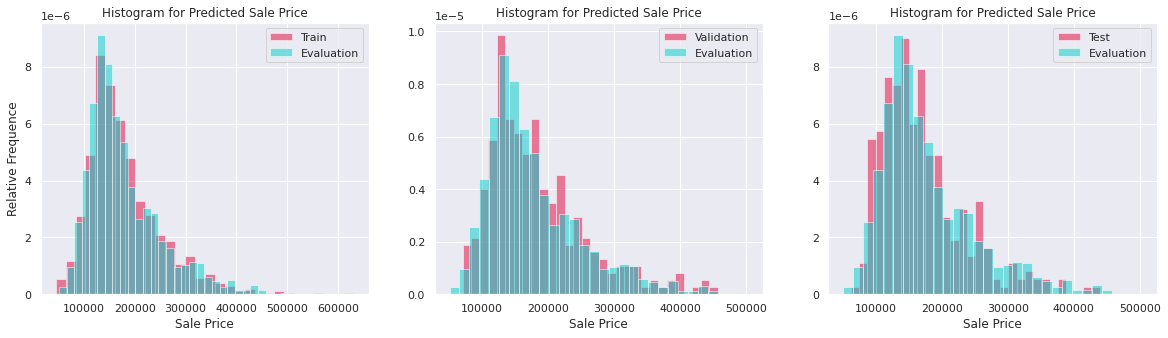

In [ ]:
#  Load test data
df_evaluation = pd.read_csv("test.csv", sep=",")

# Imputing missing values with median
df_evaluation["MasVnrArea"] = df_evaluation.MasVnrArea.fillna(df_evaluation.MasVnrArea.median())
df_evaluation["GarageYrBlt"] = df_evaluation.GarageYrBlt.fillna(df_evaluation.GarageYrBlt.median())
df_evaluation["LotFrontage"] = df_evaluation.LotFrontage.fillna(df_evaluation.LotFrontage.median())
df_evaluation["BsmtFinSF1"] = df_evaluation.BsmtFinSF1.fillna(df_evaluation.BsmtFinSF1.median())
df_evaluation["BsmtFinSF2"] = df_evaluation.BsmtFinSF2.fillna(df_evaluation.BsmtFinSF2.median())
df_evaluation["BsmtUnfSF"] = df_evaluation.BsmtUnfSF.fillna(df_evaluation.BsmtUnfSF.median())
df_evaluation["TotalBsmtSF"] = df_evaluation.TotalBsmtSF.fillna(df_evaluation.TotalBsmtSF.median())
df_evaluation["BsmtFullBath"] = df_evaluation.BsmtFullBath.fillna(df_evaluation.BsmtFullBath.median())
df_evaluation["BsmtHalfBath"] = df_evaluation.BsmtHalfBath.fillna(df_evaluation.BsmtHalfBath.median())
df_evaluation["GarageCars"] = df_evaluation.LotFrontage.fillna(df_evaluation.GarageCars.median())
df_evaluation["GarageArea"] = df_evaluation.GarageArea.fillna(df_evaluation.GarageArea.median())

# Imputing missing values with median
df_evaluation["MasVnrType"] = df_evaluation.MasVnrType.fillna(df_evaluation.MasVnrType.mode()[0])
df_evaluation["BsmtQual"] = df_evaluation.BsmtQual.fillna(df_evaluation.BsmtQual.mode()[0])
df_evaluation["BsmtCond"] = df_evaluation.BsmtCond.fillna(df_evaluation.BsmtCond.mode()[0])
df_evaluation["BsmtExposure"] = df_evaluation.BsmtExposure.fillna(df_evaluation.BsmtExposure.mode()[0])
df_evaluation["BsmtFinType1"] = df_evaluation.BsmtFinType1.fillna(df_evaluation.BsmtFinType1.mode()[0])
df_evaluation["BsmtFinType2"] = df_evaluation.BsmtFinType2.fillna(df_evaluation.BsmtFinType2.mode()[0])
df_evaluation["Electrical"] = df_evaluation.Electrical.fillna(df_evaluation.Electrical.mode()[0])
df_evaluation["GarageType"] = df_evaluation.GarageType.fillna(df_evaluation.GarageType.mode()[0])
df_evaluation["GarageFinish"] = df_evaluation.GarageFinish.fillna(df_evaluation.GarageFinish.mode()[0])
df_evaluation["GarageQual"] = df_evaluation.GarageQual.fillna(df_evaluation.GarageQual.mode()[0])
df_evaluation["GarageCond"] = df_evaluation.GarageCond.fillna(df_evaluation.GarageCond.mode()[0])

df_evaluation["MSZoning"] = df_evaluation.MSZoning.fillna(df_evaluation.MSZoning.mode()[0])
df_evaluation["Street"] = df_evaluation.Street.fillna(df_evaluation.Street.mode()[0])
df_evaluation["Alley"] = df_evaluation.Alley.fillna(df_evaluation.Alley.mode()[0])
df_evaluation["LotShape"] = df_evaluation.LotShape.fillna(df_evaluation.LotShape.mode()[0])
df_evaluation["LandContour"] = df_evaluation.LandContour.fillna(df_evaluation.LandContour.mode()[0])
df_evaluation["Utilities"] = df_evaluation.Utilities.fillna(df_evaluation.Utilities.mode()[0])
df_evaluation["LotConfig"] = df_evaluation.LotConfig.fillna(df_evaluation.LotConfig.mode()[0])
df_evaluation["LandSlope"] = df_evaluation.LandSlope.fillna(df_evaluation.LandSlope.mode()[0])
df_evaluation["Neighborhood"] = df_evaluation.Neighborhood.fillna(df_evaluation.Neighborhood.mode()[0])
df_evaluation["Condition1"] = df_evaluation.Condition1.fillna(df_evaluation.Condition1.mode()[0])
df_evaluation["Condition2"] = df_evaluation.Condition2.fillna(df_evaluation.Condition2.mode()[0])
df_evaluation["BldgType"] = df_evaluation.BldgType.fillna(df_evaluation.BldgType.mode()[0])
df_evaluation["HouseStyle"] = df_evaluation.HouseStyle.fillna(df_evaluation.HouseStyle.mode()[0])
df_evaluation["RoofStyle"] = df_evaluation.RoofStyle.fillna(df_evaluation.RoofStyle.mode()[0])
df_evaluation["RoofMatl"] = df_evaluation.RoofMatl.fillna(df_evaluation.RoofMatl.mode()[0])
df_evaluation["Exterior1st"] = df_evaluation.Exterior1st.fillna(df_evaluation.Exterior1st.mode()[0])
df_evaluation["Exterior2nd"] = df_evaluation.Exterior2nd.fillna(df_evaluation.Exterior2nd.mode()[0])
df_evaluation["ExterQual"] = df_evaluation.ExterQual.fillna(df_evaluation.ExterQual.mode()[0])
df_evaluation["ExterCond"] = df_evaluation.ExterCond.fillna(df_evaluation.ExterCond.mode()[0])
df_evaluation["Foundation"] = df_evaluation.Foundation.fillna(df_evaluation.Foundation.mode()[0])
df_evaluation["Heating"] = df_evaluation.Heating.fillna(df_evaluation.Heating.mode()[0])
df_evaluation["HeatingQC"] = df_evaluation.HeatingQC.fillna(df_evaluation.HeatingQC.mode()[0])
df_evaluation["CentralAir"] = df_evaluation.CentralAir.fillna(df_evaluation.CentralAir.mode()[0])
df_evaluation["KitchenQual"] = df_evaluation.KitchenQual.fillna(df_evaluation.KitchenQual.mode()[0])
df_evaluation["Functional"] = df_evaluation.Functional.fillna(df_evaluation.Functional.mode()[0])
df_evaluation["PavedDrive"] = df_evaluation.PavedDrive.fillna(df_evaluation.PavedDrive.mode()[0])
df_evaluation["PoolQC"] = df_evaluation.PoolQC.fillna(df_evaluation.PoolQC.mode()[0])
df_evaluation["Fence"] = df_evaluation.Fence.fillna(df_evaluation.Fence.mode()[0])
df_evaluation["MiscFeature"] = df_evaluation.MiscFeature.fillna(df_evaluation.MiscFeature.mode()[0])
df_evaluation["SaleType"] = df_evaluation.SaleType.fillna(df_evaluation.SaleType.mode()[0])
df_evaluation["SaleCondition"] = df_evaluation.SaleCondition.fillna(df_evaluation.SaleCondition.mode()[0])
df_evaluation["FireplaceQu"] = df_evaluation.FireplaceQu.fillna(df_evaluation.FireplaceQu.mode()[0])

# Create dummie variables and stack them with the previous dataframe

df_evaluation = pd.concat([df_evaluation, pd.get_dummies(df_evaluation.MSZoning, prefix='MSZoning_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Street, prefix='Street_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Alley, prefix='Alley_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotShape, prefix='LotShape_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandContour, prefix='LandContour_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Utilities, prefix='Utilities_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotConfig, prefix='LotConfig_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandSlope, prefix='LandSlope_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Neighborhood, prefix='Neighborhood_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition1, prefix='Condition1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition2, prefix='Condition2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BldgType, prefix='BldgType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HouseStyle, prefix='HouseStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofStyle, prefix='RoofStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofMatl, prefix='RoofMatl_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior1st, prefix='Exterior1st_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior2nd, prefix='Exterior2nd_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MasVnrType, prefix='MasVnrType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterQual, prefix='ExterQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterCond, prefix='ExterCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Foundation, prefix='Foundation_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtQual, prefix='BsmtQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtCond, prefix='BsmtCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtExposure, prefix='BsmtExposure_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType1, prefix='BsmtFinType1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType2, prefix='BsmtFinType2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Heating, prefix='Heating_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HeatingQC, prefix='HeatingQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.CentralAir, prefix='CentralAir_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Electrical, prefix='Electrical_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.KitchenQual, prefix='KitchenQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Functional, prefix='Functional_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.FireplaceQu, prefix='FireplaceQu_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageType, prefix='GarageType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageFinish, prefix='GarageFinish_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageQual, prefix='GarageQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageCond, prefix='GarageCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PavedDrive, prefix='PavedDrive_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PoolQC, prefix='PoolQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Fence, prefix='Fence_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MiscFeature, prefix='MiscFeature_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleType, prefix='SaleType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleCondition, prefix='SaleCondition_DM',drop_first=False)
          ], axis=1)

# Select only used variables 
df_evaluation_mod = df_evaluation.loc[:, df_evaluation.columns.isin(vars_select)].copy()
print("X Test shape:",df_evaluation_mod.shape)

# Make prediction over evaluation data
df_evaluation_mod['SalePrice'] = pd.DataFrame( np.expm1(rf_grid.best_estimator_.predict(df_evaluation_mod)))
df_evaluation_mod = pd.concat([df_evaluation['Id'].reset_index(drop=True), df_evaluation_mod['SalePrice']], axis=1)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(ypred_train.iloc[:,0]),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(ypred_val.iloc[:,0]),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(ypred_test.iloc[:,0]),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation_mod.to_csv(submissions_path + '/House_Prices_ART_RanForest_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'rf'
df_train_ens = pd.concat([df_train_ens, np.expm1(ypred_train.iloc[:,0])], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens, np.expm1(ypred_val.iloc[:,0])], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens, np.expm1(ypred_test.iloc[:,0])], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation_mod.SalePrice], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Ligth GBM technique



 





In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

# Select the explanatory variables to be used
vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','TotRmsAbvGrd','YearRemodAdd'
 ,'GarageYrBlt','Fireplaces','MasVnrArea','LotArea','BsmtFinSF1','OpenPorchSF','LotFrontage','WoodDeckSF','HalfBath','2ndFlrSF'
 ,'BsmtFullBath','BedroomAbvGr','BsmtUnfSF','EnclosedPorch','KitchenAbvGr','OverallCond','ScreenPorch','PoolArea','MSSubClass'
 ,'MoSold','BsmtFinSF2','3SsnPorch','YrSold','LowQualFinSF','MiscVal','BsmtHalfBath' 

,'MSZoning_DM_C (all)','MSZoning_DM_FV','MSZoning_DM_RH','MSZoning_DM_RL','MSZoning_DM_RM','Street_DM_Grvl','Street_DM_Pave'
,'Alley_DM_Grvl','Alley_DM_Pave','LotShape_DM_IR1','LotShape_DM_IR2','LotShape_DM_IR3','LotShape_DM_Reg','LandContour_DM_Bnk'
,'LandContour_DM_HLS','LandContour_DM_Low','LandContour_DM_Lvl','Utilities_DM_AllPub','LotConfig_DM_Corner'
,'LotConfig_DM_CulDSac','LotConfig_DM_FR2','LotConfig_DM_FR3','LotConfig_DM_Inside','LandSlope_DM_Gtl','LandSlope_DM_Mod'
,'LandSlope_DM_Sev','Neighborhood_DM_Blmngtn','Neighborhood_DM_Blueste','Neighborhood_DM_BrDale','Neighborhood_DM_BrkSide'
,'Neighborhood_DM_ClearCr','Neighborhood_DM_CollgCr','Neighborhood_DM_Crawfor','Neighborhood_DM_Edwards','Neighborhood_DM_Gilbert'
,'Neighborhood_DM_IDOTRR','Neighborhood_DM_MeadowV','Neighborhood_DM_Mitchel','Neighborhood_DM_NAmes','Neighborhood_DM_NPkVill'
,'Neighborhood_DM_NWAmes','Neighborhood_DM_NoRidge','Neighborhood_DM_NridgHt','Neighborhood_DM_OldTown','Neighborhood_DM_SWISU'
,'Neighborhood_DM_Sawyer','Neighborhood_DM_SawyerW','Neighborhood_DM_Somerst','Neighborhood_DM_StoneBr','Neighborhood_DM_Timber'
,'Neighborhood_DM_Veenker','Condition1_DM_Artery','Condition1_DM_Feedr','Condition1_DM_Norm','Condition1_DM_PosA','Condition1_DM_PosN'
,'Condition1_DM_RRAe','Condition1_DM_RRAn','Condition1_DM_RRNe','Condition1_DM_RRNn','Condition2_DM_Artery','Condition2_DM_Feedr'
,'Condition2_DM_Norm','Condition2_DM_PosA','Condition2_DM_PosN'
,'BldgType_DM_1Fam','BldgType_DM_2fmCon','BldgType_DM_Duplex','BldgType_DM_Twnhs','BldgType_DM_TwnhsE','HouseStyle_DM_1.5Fin'
,'HouseStyle_DM_1.5Unf','HouseStyle_DM_1Story','HouseStyle_DM_2.5Unf','HouseStyle_DM_2Story','HouseStyle_DM_SFoyer'
,'HouseStyle_DM_SLvl','RoofStyle_DM_Flat','RoofStyle_DM_Gable','RoofStyle_DM_Gambrel','RoofStyle_DM_Hip','RoofStyle_DM_Mansard'
,'RoofStyle_DM_Shed','RoofMatl_DM_CompShg'
,'RoofMatl_DM_Tar&Grv','RoofMatl_DM_WdShake','RoofMatl_DM_WdShngl','Exterior1st_DM_AsbShng','Exterior1st_DM_AsphShn'
,'Exterior1st_DM_BrkComm','Exterior1st_DM_BrkFace','Exterior1st_DM_CBlock','Exterior1st_DM_CemntBd','Exterior1st_DM_HdBoard'
,'Exterior1st_DM_MetalSd','Exterior1st_DM_Plywood','Exterior1st_DM_Stucco'
,'Exterior1st_DM_VinylSd','Exterior1st_DM_Wd Sdng','Exterior1st_DM_WdShing','Exterior2nd_DM_AsbShng','Exterior2nd_DM_AsphShn'
,'Exterior2nd_DM_Brk Cmn','Exterior2nd_DM_BrkFace','Exterior2nd_DM_CBlock','Exterior2nd_DM_CmentBd','Exterior2nd_DM_HdBoard'
,'Exterior2nd_DM_ImStucc','Exterior2nd_DM_MetalSd','Exterior2nd_DM_Plywood','Exterior2nd_DM_Stone'
,'Exterior2nd_DM_Stucco','Exterior2nd_DM_VinylSd','Exterior2nd_DM_Wd Sdng','Exterior2nd_DM_Wd Shng','MasVnrType_DM_BrkCmn'
,'MasVnrType_DM_BrkFace','MasVnrType_DM_None','MasVnrType_DM_Stone','ExterQual_DM_Ex','ExterQual_DM_Fa','ExterQual_DM_Gd'
,'ExterQual_DM_TA','ExterCond_DM_Ex','ExterCond_DM_Fa','ExterCond_DM_Gd','ExterCond_DM_Po','ExterCond_DM_TA','Foundation_DM_BrkTil'
,'Foundation_DM_CBlock','Foundation_DM_PConc','Foundation_DM_Slab','Foundation_DM_Stone','Foundation_DM_Wood','BsmtQual_DM_Ex'
,'BsmtQual_DM_Fa','BsmtQual_DM_Gd','BsmtQual_DM_TA','BsmtCond_DM_Fa','BsmtCond_DM_Gd','BsmtCond_DM_Po','BsmtCond_DM_TA','BsmtExposure_DM_Av'
,'BsmtExposure_DM_Gd','BsmtExposure_DM_Mn','BsmtExposure_DM_No','BsmtFinType1_DM_ALQ','BsmtFinType1_DM_BLQ','BsmtFinType1_DM_GLQ'
,'BsmtFinType1_DM_LwQ','BsmtFinType1_DM_Rec','BsmtFinType1_DM_Unf','BsmtFinType2_DM_ALQ','BsmtFinType2_DM_BLQ','BsmtFinType2_DM_GLQ'
,'BsmtFinType2_DM_LwQ','BsmtFinType2_DM_Rec','BsmtFinType2_DM_Unf','Heating_DM_GasA','Heating_DM_GasW','Heating_DM_Grav'
,'Heating_DM_Wall','HeatingQC_DM_Ex','HeatingQC_DM_Fa','HeatingQC_DM_Gd','HeatingQC_DM_Po','HeatingQC_DM_TA'
,'CentralAir_DM_N','CentralAir_DM_Y','Electrical_DM_FuseA','Electrical_DM_FuseF','Electrical_DM_FuseP'
,'Electrical_DM_SBrkr','KitchenQual_DM_Ex','KitchenQual_DM_Fa','KitchenQual_DM_Gd','KitchenQual_DM_TA','Functional_DM_Maj1'
,'Functional_DM_Maj2','Functional_DM_Min1','Functional_DM_Min2','Functional_DM_Mod','Functional_DM_Sev','Functional_DM_Typ'
,'FireplaceQu_DM_Ex','FireplaceQu_DM_Fa','FireplaceQu_DM_Gd','FireplaceQu_DM_Po','FireplaceQu_DM_TA','GarageType_DM_2Types'
,'GarageType_DM_Attchd','GarageType_DM_Basment','GarageType_DM_BuiltIn','GarageType_DM_CarPort','GarageType_DM_Detchd'
,'GarageFinish_DM_Fin','GarageFinish_DM_RFn','GarageFinish_DM_Unf','GarageQual_DM_Fa','GarageQual_DM_Gd'
,'GarageQual_DM_Po','GarageQual_DM_TA','GarageCond_DM_Ex','GarageCond_DM_Fa','GarageCond_DM_Gd','GarageCond_DM_Po'
,'GarageCond_DM_TA','PavedDrive_DM_N','PavedDrive_DM_P','PavedDrive_DM_Y','PoolQC_DM_Ex','PoolQC_DM_Gd'
,'Fence_DM_GdPrv','Fence_DM_GdWo','Fence_DM_MnPrv','Fence_DM_MnWw','MiscFeature_DM_Gar2','MiscFeature_DM_Othr','MiscFeature_DM_Shed'
,'SaleType_DM_COD','SaleType_DM_CWD','SaleType_DM_Con','SaleType_DM_ConLD','SaleType_DM_ConLI','SaleType_DM_ConLw'
,'SaleType_DM_New','SaleType_DM_Oth','SaleType_DM_WD','SaleCondition_DM_Abnorml','SaleCondition_DM_AdjLand','SaleCondition_DM_Alloca'
,'SaleCondition_DM_Family','SaleCondition_DM_Normal','SaleCondition_DM_Partial' 
               ]
  
# vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea']


x = new_df.loc[:, new_df.columns.isin(vars_select)].copy()
# Select the response variable (we take the long since it's recommended for large-scaled variables)
y = new_df.loc[:, new_df.columns == "SalePrice"].copy()
# y = np.log(new_df.loc[:, new_df.columns == "SalePrice"].copy())

# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 30% of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/LGBM_model.pkl','rb')
  lgbm_grid = pickle.load(infile)

else:
  #Define the grid to be searched in
  lgbm = LGBMRegressor(n_estimators=50, random_state=0)

  # Create the random grid
  parameters = {'num_leaves':[20,40,60,80,100]
                , 'min_child_samples':[5,10,15]
                , 'max_depth':[-1,5,10,20]
                , 'learning_rate':[0.05,0.01,0.1,0.2]
                , 'reg_alpha':[0,0.01,0.03]}

  #Execute cross-validated grid search
  lgbm_grid = TuneSearchCV(lgbm, param_distributions=parameters, n_trials = 50, early_stopping = False, n_jobs = -1, random_state = 0)

  # Train Model
  lgbm_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/LGBM_model.pkl', 'wb') as pickfile:
     pickle.dump(lgbm_grid, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(lgbm_grid.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = pd.DataFrame(lgbm_grid.best_estimator_.predict(x_train))
# Predict values of regression with validation
ypred_val = pd.DataFrame(lgbm_grid.best_estimator_.predict(x_val))
# Predict values of regression with test
ypred_test = pd.DataFrame(lgbm_grid.best_estimator_.predict(x_test))

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(lgbm_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (876, 270)
Y Train shape: (876, 1)
X Validation shape: (292, 270)
Y Validation shape: (292, 1)
X Test shape: (292, 270)
Y Test shape: (292, 1)
Best parameters found: 
{'num_leaves': 100, 'min_child_samples': 15, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.0}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.05818, 0.13923, 0.13181
Feature importance:
Ejecución: 0.5192818641662598 seconds


X Test shape: (1459, 270)


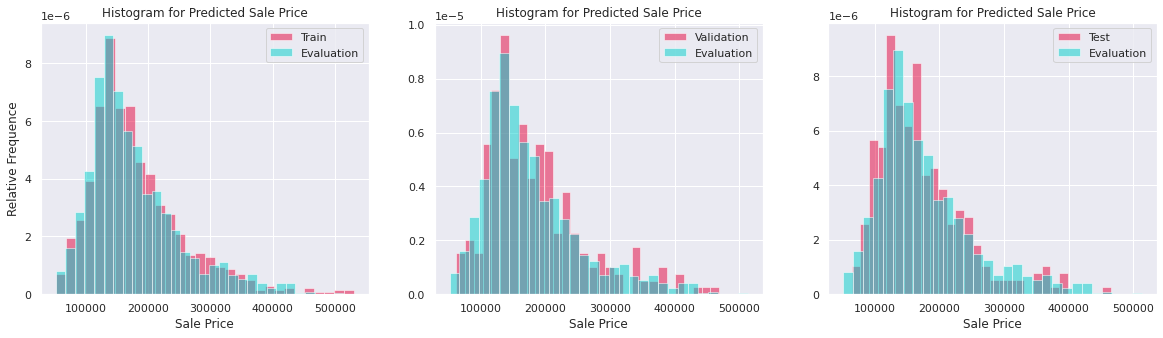

In [ ]:
#  Load test data
df_evaluation = pd.read_csv("test.csv", sep=",")

# Imputing missing values with median
df_evaluation["MasVnrArea"] = df_evaluation.MasVnrArea.fillna(df_evaluation.MasVnrArea.median())
df_evaluation["GarageYrBlt"] = df_evaluation.GarageYrBlt.fillna(df_evaluation.GarageYrBlt.median())
df_evaluation["LotFrontage"] = df_evaluation.LotFrontage.fillna(df_evaluation.LotFrontage.median())
df_evaluation["BsmtFinSF1"] = df_evaluation.BsmtFinSF1.fillna(df_evaluation.BsmtFinSF1.median())
df_evaluation["BsmtFinSF2"] = df_evaluation.BsmtFinSF2.fillna(df_evaluation.BsmtFinSF2.median())
df_evaluation["BsmtUnfSF"] = df_evaluation.BsmtUnfSF.fillna(df_evaluation.BsmtUnfSF.median())
df_evaluation["TotalBsmtSF"] = df_evaluation.TotalBsmtSF.fillna(df_evaluation.TotalBsmtSF.median())
df_evaluation["BsmtFullBath"] = df_evaluation.BsmtFullBath.fillna(df_evaluation.BsmtFullBath.median())
df_evaluation["BsmtHalfBath"] = df_evaluation.BsmtHalfBath.fillna(df_evaluation.BsmtHalfBath.median())
df_evaluation["GarageCars"] = df_evaluation.LotFrontage.fillna(df_evaluation.GarageCars.median())
df_evaluation["GarageArea"] = df_evaluation.GarageArea.fillna(df_evaluation.GarageArea.median())

# Imputing missing values with median
df_evaluation["MasVnrType"] = df_evaluation.MasVnrType.fillna(df_evaluation.MasVnrType.mode()[0])
df_evaluation["BsmtQual"] = df_evaluation.BsmtQual.fillna(df_evaluation.BsmtQual.mode()[0])
df_evaluation["BsmtCond"] = df_evaluation.BsmtCond.fillna(df_evaluation.BsmtCond.mode()[0])
df_evaluation["BsmtExposure"] = df_evaluation.BsmtExposure.fillna(df_evaluation.BsmtExposure.mode()[0])
df_evaluation["BsmtFinType1"] = df_evaluation.BsmtFinType1.fillna(df_evaluation.BsmtFinType1.mode()[0])
df_evaluation["BsmtFinType2"] = df_evaluation.BsmtFinType2.fillna(df_evaluation.BsmtFinType2.mode()[0])
df_evaluation["Electrical"] = df_evaluation.Electrical.fillna(df_evaluation.Electrical.mode()[0])
df_evaluation["GarageType"] = df_evaluation.GarageType.fillna(df_evaluation.GarageType.mode()[0])
df_evaluation["GarageFinish"] = df_evaluation.GarageFinish.fillna(df_evaluation.GarageFinish.mode()[0])
df_evaluation["GarageQual"] = df_evaluation.GarageQual.fillna(df_evaluation.GarageQual.mode()[0])
df_evaluation["GarageCond"] = df_evaluation.GarageCond.fillna(df_evaluation.GarageCond.mode()[0])

df_evaluation["MSZoning"] = df_evaluation.MSZoning.fillna(df_evaluation.MSZoning.mode()[0])
df_evaluation["Street"] = df_evaluation.Street.fillna(df_evaluation.Street.mode()[0])
df_evaluation["Alley"] = df_evaluation.Alley.fillna(df_evaluation.Alley.mode()[0])
df_evaluation["LotShape"] = df_evaluation.LotShape.fillna(df_evaluation.LotShape.mode()[0])
df_evaluation["LandContour"] = df_evaluation.LandContour.fillna(df_evaluation.LandContour.mode()[0])
df_evaluation["Utilities"] = df_evaluation.Utilities.fillna(df_evaluation.Utilities.mode()[0])
df_evaluation["LotConfig"] = df_evaluation.LotConfig.fillna(df_evaluation.LotConfig.mode()[0])
df_evaluation["LandSlope"] = df_evaluation.LandSlope.fillna(df_evaluation.LandSlope.mode()[0])
df_evaluation["Neighborhood"] = df_evaluation.Neighborhood.fillna(df_evaluation.Neighborhood.mode()[0])
df_evaluation["Condition1"] = df_evaluation.Condition1.fillna(df_evaluation.Condition1.mode()[0])
df_evaluation["Condition2"] = df_evaluation.Condition2.fillna(df_evaluation.Condition2.mode()[0])
df_evaluation["BldgType"] = df_evaluation.BldgType.fillna(df_evaluation.BldgType.mode()[0])
df_evaluation["HouseStyle"] = df_evaluation.HouseStyle.fillna(df_evaluation.HouseStyle.mode()[0])
df_evaluation["RoofStyle"] = df_evaluation.RoofStyle.fillna(df_evaluation.RoofStyle.mode()[0])
df_evaluation["RoofMatl"] = df_evaluation.RoofMatl.fillna(df_evaluation.RoofMatl.mode()[0])
df_evaluation["Exterior1st"] = df_evaluation.Exterior1st.fillna(df_evaluation.Exterior1st.mode()[0])
df_evaluation["Exterior2nd"] = df_evaluation.Exterior2nd.fillna(df_evaluation.Exterior2nd.mode()[0])
df_evaluation["ExterQual"] = df_evaluation.ExterQual.fillna(df_evaluation.ExterQual.mode()[0])
df_evaluation["ExterCond"] = df_evaluation.ExterCond.fillna(df_evaluation.ExterCond.mode()[0])
df_evaluation["Foundation"] = df_evaluation.Foundation.fillna(df_evaluation.Foundation.mode()[0])
df_evaluation["Heating"] = df_evaluation.Heating.fillna(df_evaluation.Heating.mode()[0])
df_evaluation["HeatingQC"] = df_evaluation.HeatingQC.fillna(df_evaluation.HeatingQC.mode()[0])
df_evaluation["CentralAir"] = df_evaluation.CentralAir.fillna(df_evaluation.CentralAir.mode()[0])
df_evaluation["KitchenQual"] = df_evaluation.KitchenQual.fillna(df_evaluation.KitchenQual.mode()[0])
df_evaluation["Functional"] = df_evaluation.Functional.fillna(df_evaluation.Functional.mode()[0])
df_evaluation["PavedDrive"] = df_evaluation.PavedDrive.fillna(df_evaluation.PavedDrive.mode()[0])
df_evaluation["PoolQC"] = df_evaluation.PoolQC.fillna(df_evaluation.PoolQC.mode()[0])
df_evaluation["Fence"] = df_evaluation.Fence.fillna(df_evaluation.Fence.mode()[0])
df_evaluation["MiscFeature"] = df_evaluation.MiscFeature.fillna(df_evaluation.MiscFeature.mode()[0])
df_evaluation["SaleType"] = df_evaluation.SaleType.fillna(df_evaluation.SaleType.mode()[0])
df_evaluation["SaleCondition"] = df_evaluation.SaleCondition.fillna(df_evaluation.SaleCondition.mode()[0])
df_evaluation["FireplaceQu"] = df_evaluation.FireplaceQu.fillna(df_evaluation.FireplaceQu.mode()[0])

# Create dummie variables and stack them with the previous dataframe

df_evaluation = pd.concat([df_evaluation, pd.get_dummies(df_evaluation.MSZoning, prefix='MSZoning_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Street, prefix='Street_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Alley, prefix='Alley_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotShape, prefix='LotShape_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandContour, prefix='LandContour_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Utilities, prefix='Utilities_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotConfig, prefix='LotConfig_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandSlope, prefix='LandSlope_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Neighborhood, prefix='Neighborhood_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition1, prefix='Condition1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition2, prefix='Condition2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BldgType, prefix='BldgType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HouseStyle, prefix='HouseStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofStyle, prefix='RoofStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofMatl, prefix='RoofMatl_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior1st, prefix='Exterior1st_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior2nd, prefix='Exterior2nd_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MasVnrType, prefix='MasVnrType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterQual, prefix='ExterQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterCond, prefix='ExterCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Foundation, prefix='Foundation_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtQual, prefix='BsmtQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtCond, prefix='BsmtCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtExposure, prefix='BsmtExposure_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType1, prefix='BsmtFinType1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType2, prefix='BsmtFinType2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Heating, prefix='Heating_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HeatingQC, prefix='HeatingQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.CentralAir, prefix='CentralAir_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Electrical, prefix='Electrical_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.KitchenQual, prefix='KitchenQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Functional, prefix='Functional_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.FireplaceQu, prefix='FireplaceQu_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageType, prefix='GarageType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageFinish, prefix='GarageFinish_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageQual, prefix='GarageQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageCond, prefix='GarageCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PavedDrive, prefix='PavedDrive_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PoolQC, prefix='PoolQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Fence, prefix='Fence_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MiscFeature, prefix='MiscFeature_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleType, prefix='SaleType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleCondition, prefix='SaleCondition_DM',drop_first=False)
          ], axis=1)

# Select only used variables 
df_evaluation_mod = df_evaluation.loc[:, df_evaluation.columns.isin(vars_select)].copy()
print("X Test shape:",df_evaluation_mod.shape)

# Make prediction over evaluation data
df_evaluation_mod['SalePrice'] = pd.DataFrame( np.expm1(lgbm_grid.best_estimator_.predict(df_evaluation_mod)))
df_evaluation_mod = pd.concat([df_evaluation['Id'].reset_index(drop=True), df_evaluation_mod['SalePrice']], axis=1)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(ypred_train.iloc[:,0]),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(ypred_val.iloc[:,0]),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(ypred_test.iloc[:,0]),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
df_evaluation_mod.to_csv(submissions_path + '/House_Prices_ART_LGBM_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'lgbm'
df_train_ens = pd.concat([df_train_ens, np.expm1(ypred_train.iloc[:,0])], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens, np.expm1(ypred_val.iloc[:,0])], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens, np.expm1(ypred_test.iloc[:,0])], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation_mod.SalePrice], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Lasso regression technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

# Select the explanatory variables to be used
vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','TotRmsAbvGrd','YearRemodAdd'
 ,'GarageYrBlt','Fireplaces','MasVnrArea','LotArea','BsmtFinSF1','OpenPorchSF','LotFrontage','WoodDeckSF','HalfBath','2ndFlrSF'
 ,'BsmtFullBath','BedroomAbvGr','BsmtUnfSF','EnclosedPorch','KitchenAbvGr','OverallCond','ScreenPorch','PoolArea','MSSubClass'
 ,'MoSold','BsmtFinSF2','3SsnPorch','YrSold','LowQualFinSF','MiscVal','BsmtHalfBath'

,'MSZoning_DM_C (all)','MSZoning_DM_FV','MSZoning_DM_RH','MSZoning_DM_RL','MSZoning_DM_RM','Street_DM_Grvl','Street_DM_Pave'
,'Alley_DM_Grvl','Alley_DM_Pave','LotShape_DM_IR1','LotShape_DM_IR2','LotShape_DM_IR3','LotShape_DM_Reg','LandContour_DM_Bnk'
,'LandContour_DM_HLS','LandContour_DM_Low','LandContour_DM_Lvl','Utilities_DM_AllPub','LotConfig_DM_Corner'
,'LotConfig_DM_CulDSac','LotConfig_DM_FR2','LotConfig_DM_FR3','LotConfig_DM_Inside','LandSlope_DM_Gtl','LandSlope_DM_Mod'
,'LandSlope_DM_Sev','Neighborhood_DM_Blmngtn','Neighborhood_DM_Blueste','Neighborhood_DM_BrDale','Neighborhood_DM_BrkSide'
,'Neighborhood_DM_ClearCr','Neighborhood_DM_CollgCr','Neighborhood_DM_Crawfor','Neighborhood_DM_Edwards','Neighborhood_DM_Gilbert'
,'Neighborhood_DM_IDOTRR','Neighborhood_DM_MeadowV','Neighborhood_DM_Mitchel','Neighborhood_DM_NAmes','Neighborhood_DM_NPkVill'
,'Neighborhood_DM_NWAmes','Neighborhood_DM_NoRidge','Neighborhood_DM_NridgHt','Neighborhood_DM_OldTown','Neighborhood_DM_SWISU'
,'Neighborhood_DM_Sawyer','Neighborhood_DM_SawyerW','Neighborhood_DM_Somerst','Neighborhood_DM_StoneBr','Neighborhood_DM_Timber'
,'Neighborhood_DM_Veenker','Condition1_DM_Artery','Condition1_DM_Feedr','Condition1_DM_Norm','Condition1_DM_PosA','Condition1_DM_PosN'
,'Condition1_DM_RRAe','Condition1_DM_RRAn','Condition1_DM_RRNe','Condition1_DM_RRNn','Condition2_DM_Artery','Condition2_DM_Feedr'
,'Condition2_DM_Norm','Condition2_DM_PosA','Condition2_DM_PosN'
,'BldgType_DM_1Fam','BldgType_DM_2fmCon','BldgType_DM_Duplex','BldgType_DM_Twnhs','BldgType_DM_TwnhsE','HouseStyle_DM_1.5Fin'
,'HouseStyle_DM_1.5Unf','HouseStyle_DM_1Story','HouseStyle_DM_2.5Unf','HouseStyle_DM_2Story','HouseStyle_DM_SFoyer'
,'HouseStyle_DM_SLvl','RoofStyle_DM_Flat','RoofStyle_DM_Gable','RoofStyle_DM_Gambrel','RoofStyle_DM_Hip','RoofStyle_DM_Mansard'
,'RoofStyle_DM_Shed','RoofMatl_DM_CompShg'
,'RoofMatl_DM_Tar&Grv','RoofMatl_DM_WdShake','RoofMatl_DM_WdShngl','Exterior1st_DM_AsbShng','Exterior1st_DM_AsphShn'
,'Exterior1st_DM_BrkComm','Exterior1st_DM_BrkFace','Exterior1st_DM_CBlock','Exterior1st_DM_CemntBd','Exterior1st_DM_HdBoard'
,'Exterior1st_DM_MetalSd','Exterior1st_DM_Plywood','Exterior1st_DM_Stucco'
,'Exterior1st_DM_VinylSd','Exterior1st_DM_Wd Sdng','Exterior1st_DM_WdShing','Exterior2nd_DM_AsbShng','Exterior2nd_DM_AsphShn'
,'Exterior2nd_DM_Brk Cmn','Exterior2nd_DM_BrkFace','Exterior2nd_DM_CBlock','Exterior2nd_DM_CmentBd','Exterior2nd_DM_HdBoard'
,'Exterior2nd_DM_ImStucc','Exterior2nd_DM_MetalSd','Exterior2nd_DM_Plywood','Exterior2nd_DM_Stone'
,'Exterior2nd_DM_Stucco','Exterior2nd_DM_VinylSd','Exterior2nd_DM_Wd Sdng','Exterior2nd_DM_Wd Shng','MasVnrType_DM_BrkCmn'
,'MasVnrType_DM_BrkFace','MasVnrType_DM_None','MasVnrType_DM_Stone','ExterQual_DM_Ex','ExterQual_DM_Fa','ExterQual_DM_Gd'
,'ExterQual_DM_TA','ExterCond_DM_Ex','ExterCond_DM_Fa','ExterCond_DM_Gd','ExterCond_DM_Po','ExterCond_DM_TA','Foundation_DM_BrkTil'
,'Foundation_DM_CBlock','Foundation_DM_PConc','Foundation_DM_Slab','Foundation_DM_Stone','Foundation_DM_Wood','BsmtQual_DM_Ex'
,'BsmtQual_DM_Fa','BsmtQual_DM_Gd','BsmtQual_DM_TA','BsmtCond_DM_Fa','BsmtCond_DM_Gd','BsmtCond_DM_Po','BsmtCond_DM_TA','BsmtExposure_DM_Av'
,'BsmtExposure_DM_Gd','BsmtExposure_DM_Mn','BsmtExposure_DM_No','BsmtFinType1_DM_ALQ','BsmtFinType1_DM_BLQ','BsmtFinType1_DM_GLQ'
,'BsmtFinType1_DM_LwQ','BsmtFinType1_DM_Rec','BsmtFinType1_DM_Unf','BsmtFinType2_DM_ALQ','BsmtFinType2_DM_BLQ','BsmtFinType2_DM_GLQ'
,'BsmtFinType2_DM_LwQ','BsmtFinType2_DM_Rec','BsmtFinType2_DM_Unf','Heating_DM_GasA','Heating_DM_GasW','Heating_DM_Grav'
,'Heating_DM_Wall','HeatingQC_DM_Ex','HeatingQC_DM_Fa','HeatingQC_DM_Gd','HeatingQC_DM_Po','HeatingQC_DM_TA'
,'CentralAir_DM_N','CentralAir_DM_Y','Electrical_DM_FuseA','Electrical_DM_FuseF','Electrical_DM_FuseP'
,'Electrical_DM_SBrkr','KitchenQual_DM_Ex','KitchenQual_DM_Fa','KitchenQual_DM_Gd','KitchenQual_DM_TA','Functional_DM_Maj1'
,'Functional_DM_Maj2','Functional_DM_Min1','Functional_DM_Min2','Functional_DM_Mod','Functional_DM_Sev','Functional_DM_Typ'
,'FireplaceQu_DM_Ex','FireplaceQu_DM_Fa','FireplaceQu_DM_Gd','FireplaceQu_DM_Po','FireplaceQu_DM_TA','GarageType_DM_2Types'
,'GarageType_DM_Attchd','GarageType_DM_Basment','GarageType_DM_BuiltIn','GarageType_DM_CarPort','GarageType_DM_Detchd'
,'GarageFinish_DM_Fin','GarageFinish_DM_RFn','GarageFinish_DM_Unf','GarageQual_DM_Fa','GarageQual_DM_Gd'
,'GarageQual_DM_Po','GarageQual_DM_TA','GarageCond_DM_Ex','GarageCond_DM_Fa','GarageCond_DM_Gd','GarageCond_DM_Po'
,'GarageCond_DM_TA','PavedDrive_DM_N','PavedDrive_DM_P','PavedDrive_DM_Y','PoolQC_DM_Ex','PoolQC_DM_Gd'
,'Fence_DM_GdPrv','Fence_DM_GdWo','Fence_DM_MnPrv','Fence_DM_MnWw','MiscFeature_DM_Gar2','MiscFeature_DM_Othr','MiscFeature_DM_Shed'
,'SaleType_DM_COD','SaleType_DM_CWD','SaleType_DM_Con','SaleType_DM_ConLD','SaleType_DM_ConLI','SaleType_DM_ConLw'
,'SaleType_DM_New','SaleType_DM_Oth','SaleType_DM_WD','SaleCondition_DM_Abnorml','SaleCondition_DM_AdjLand','SaleCondition_DM_Alloca'
,'SaleCondition_DM_Family','SaleCondition_DM_Normal','SaleCondition_DM_Partial'
               ]

# vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea']

x = new_df.loc[:, new_df.columns.isin(vars_select)].copy()
# Select the response variable (we take the long since it's recommended for large-scaled variables)
y = new_df.loc[:, new_df.columns == "SalePrice"].copy()
# y = np.log(new_df.loc[:, new_df.columns == "SalePrice"].copy())


# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 30% of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/Lasso_model.pkl','rb')
  lasso_grid = pickle.load(infile)

else:
  #Define the grid to be searched in
  lasso = Lasso(random_state=12345)

  # Create the random grid
  parameters = {'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]}
  
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  lasso_grid = RandomizedSearchCV(estimator = lasso, param_distributions = parameters, n_iter = 100, cv = 5, verbose=False, random_state=0, n_jobs = -1)
  # Fit the random search model
  lasso_grid.fit(x_train, y_train)

  #Save model
  with open(models_path + '/Lasso_model.pkl', 'wb') as pickfile:
     pickle.dump(lasso_grid, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(lasso_grid.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = pd.DataFrame(lasso_grid.best_estimator_.predict(x_train))
ypred_train.columns = ['value']
ypred_train['value']=np.where(ypred_train['value']<0, 0, ypred_train['value'])
# Predict values of regression with validation
ypred_val = pd.DataFrame(lasso_grid.best_estimator_.predict(x_val))
ypred_val.columns = ['value']
ypred_val['value']=np.where(ypred_val['value']<0, 0, ypred_val['value'])
# Predict values of regression with test
ypred_test = pd.DataFrame(lasso_grid.best_estimator_.predict(x_test))
ypred_test.columns = ['value']
ypred_test['value']=np.where(ypred_test['value']<0, 0, ypred_test['value'])

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(lasso_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (876, 270)
Y Train shape: (876, 1)
X Validation shape: (292, 270)
Y Validation shape: (292, 1)
X Test shape: (292, 270)
Y Test shape: (292, 1)
Best parameters found: 
{'alpha': 0.001}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.10932, 0.14701, 0.10891
Feature importance:
Ejecución: 0.2767307758331299 seconds


X Test shape: (1459, 270)


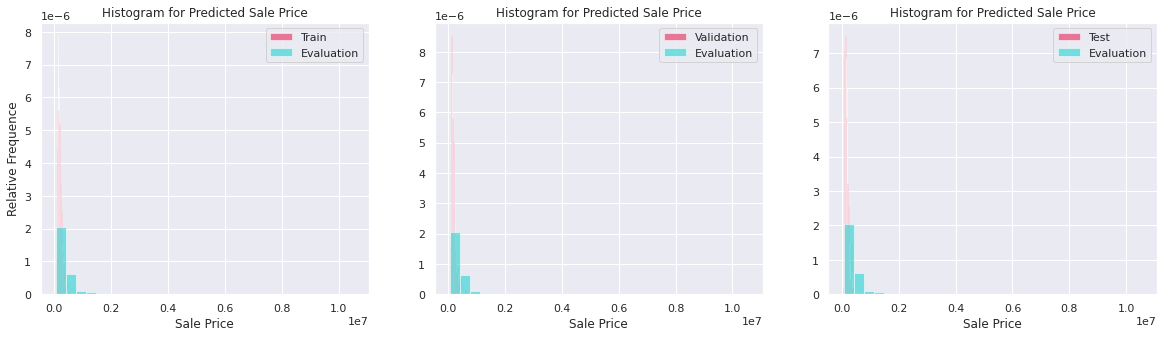

In [ ]:
#  Load test data
df_evaluation = pd.read_csv("test.csv", sep=",")

# Imputing missing values with median
df_evaluation["MasVnrArea"] = df_evaluation.MasVnrArea.fillna(df_evaluation.MasVnrArea.median())
df_evaluation["GarageYrBlt"] = df_evaluation.GarageYrBlt.fillna(df_evaluation.GarageYrBlt.median())
df_evaluation["LotFrontage"] = df_evaluation.LotFrontage.fillna(df_evaluation.LotFrontage.median())
df_evaluation["BsmtFinSF1"] = df_evaluation.BsmtFinSF1.fillna(df_evaluation.BsmtFinSF1.median())
df_evaluation["BsmtFinSF2"] = df_evaluation.BsmtFinSF2.fillna(df_evaluation.BsmtFinSF2.median())
df_evaluation["BsmtUnfSF"] = df_evaluation.BsmtUnfSF.fillna(df_evaluation.BsmtUnfSF.median())
df_evaluation["TotalBsmtSF"] = df_evaluation.TotalBsmtSF.fillna(df_evaluation.TotalBsmtSF.median())
df_evaluation["BsmtFullBath"] = df_evaluation.BsmtFullBath.fillna(df_evaluation.BsmtFullBath.median())
df_evaluation["BsmtHalfBath"] = df_evaluation.BsmtHalfBath.fillna(df_evaluation.BsmtHalfBath.median())
df_evaluation["GarageCars"] = df_evaluation.LotFrontage.fillna(df_evaluation.GarageCars.median())
df_evaluation["GarageArea"] = df_evaluation.GarageArea.fillna(df_evaluation.GarageArea.median())

# Imputing missing values with median
df_evaluation["MasVnrType"] = df_evaluation.MasVnrType.fillna(df_evaluation.MasVnrType.mode()[0])
df_evaluation["BsmtQual"] = df_evaluation.BsmtQual.fillna(df_evaluation.BsmtQual.mode()[0])
df_evaluation["BsmtCond"] = df_evaluation.BsmtCond.fillna(df_evaluation.BsmtCond.mode()[0])
df_evaluation["BsmtExposure"] = df_evaluation.BsmtExposure.fillna(df_evaluation.BsmtExposure.mode()[0])
df_evaluation["BsmtFinType1"] = df_evaluation.BsmtFinType1.fillna(df_evaluation.BsmtFinType1.mode()[0])
df_evaluation["BsmtFinType2"] = df_evaluation.BsmtFinType2.fillna(df_evaluation.BsmtFinType2.mode()[0])
df_evaluation["Electrical"] = df_evaluation.Electrical.fillna(df_evaluation.Electrical.mode()[0])
df_evaluation["GarageType"] = df_evaluation.GarageType.fillna(df_evaluation.GarageType.mode()[0])
df_evaluation["GarageFinish"] = df_evaluation.GarageFinish.fillna(df_evaluation.GarageFinish.mode()[0])
df_evaluation["GarageQual"] = df_evaluation.GarageQual.fillna(df_evaluation.GarageQual.mode()[0])
df_evaluation["GarageCond"] = df_evaluation.GarageCond.fillna(df_evaluation.GarageCond.mode()[0])

df_evaluation["MSZoning"] = df_evaluation.MSZoning.fillna(df_evaluation.MSZoning.mode()[0])
df_evaluation["Street"] = df_evaluation.Street.fillna(df_evaluation.Street.mode()[0])
df_evaluation["Alley"] = df_evaluation.Alley.fillna(df_evaluation.Alley.mode()[0])
df_evaluation["LotShape"] = df_evaluation.LotShape.fillna(df_evaluation.LotShape.mode()[0])
df_evaluation["LandContour"] = df_evaluation.LandContour.fillna(df_evaluation.LandContour.mode()[0])
df_evaluation["Utilities"] = df_evaluation.Utilities.fillna(df_evaluation.Utilities.mode()[0])
df_evaluation["LotConfig"] = df_evaluation.LotConfig.fillna(df_evaluation.LotConfig.mode()[0])
df_evaluation["LandSlope"] = df_evaluation.LandSlope.fillna(df_evaluation.LandSlope.mode()[0])
df_evaluation["Neighborhood"] = df_evaluation.Neighborhood.fillna(df_evaluation.Neighborhood.mode()[0])
df_evaluation["Condition1"] = df_evaluation.Condition1.fillna(df_evaluation.Condition1.mode()[0])
df_evaluation["Condition2"] = df_evaluation.Condition2.fillna(df_evaluation.Condition2.mode()[0])
df_evaluation["BldgType"] = df_evaluation.BldgType.fillna(df_evaluation.BldgType.mode()[0])
df_evaluation["HouseStyle"] = df_evaluation.HouseStyle.fillna(df_evaluation.HouseStyle.mode()[0])
df_evaluation["RoofStyle"] = df_evaluation.RoofStyle.fillna(df_evaluation.RoofStyle.mode()[0])
df_evaluation["RoofMatl"] = df_evaluation.RoofMatl.fillna(df_evaluation.RoofMatl.mode()[0])
df_evaluation["Exterior1st"] = df_evaluation.Exterior1st.fillna(df_evaluation.Exterior1st.mode()[0])
df_evaluation["Exterior2nd"] = df_evaluation.Exterior2nd.fillna(df_evaluation.Exterior2nd.mode()[0])
df_evaluation["ExterQual"] = df_evaluation.ExterQual.fillna(df_evaluation.ExterQual.mode()[0])
df_evaluation["ExterCond"] = df_evaluation.ExterCond.fillna(df_evaluation.ExterCond.mode()[0])
df_evaluation["Foundation"] = df_evaluation.Foundation.fillna(df_evaluation.Foundation.mode()[0])
df_evaluation["Heating"] = df_evaluation.Heating.fillna(df_evaluation.Heating.mode()[0])
df_evaluation["HeatingQC"] = df_evaluation.HeatingQC.fillna(df_evaluation.HeatingQC.mode()[0])
df_evaluation["CentralAir"] = df_evaluation.CentralAir.fillna(df_evaluation.CentralAir.mode()[0])
df_evaluation["KitchenQual"] = df_evaluation.KitchenQual.fillna(df_evaluation.KitchenQual.mode()[0])
df_evaluation["Functional"] = df_evaluation.Functional.fillna(df_evaluation.Functional.mode()[0])
df_evaluation["PavedDrive"] = df_evaluation.PavedDrive.fillna(df_evaluation.PavedDrive.mode()[0])
df_evaluation["PoolQC"] = df_evaluation.PoolQC.fillna(df_evaluation.PoolQC.mode()[0])
df_evaluation["Fence"] = df_evaluation.Fence.fillna(df_evaluation.Fence.mode()[0])
df_evaluation["MiscFeature"] = df_evaluation.MiscFeature.fillna(df_evaluation.MiscFeature.mode()[0])
df_evaluation["SaleType"] = df_evaluation.SaleType.fillna(df_evaluation.SaleType.mode()[0])
df_evaluation["SaleCondition"] = df_evaluation.SaleCondition.fillna(df_evaluation.SaleCondition.mode()[0])
df_evaluation["FireplaceQu"] = df_evaluation.FireplaceQu.fillna(df_evaluation.FireplaceQu.mode()[0])

# Create dummie variables and stack them with the previous dataframe

df_evaluation = pd.concat([df_evaluation, pd.get_dummies(df_evaluation.MSZoning, prefix='MSZoning_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Street, prefix='Street_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Alley, prefix='Alley_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotShape, prefix='LotShape_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandContour, prefix='LandContour_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Utilities, prefix='Utilities_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotConfig, prefix='LotConfig_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandSlope, prefix='LandSlope_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Neighborhood, prefix='Neighborhood_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition1, prefix='Condition1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition2, prefix='Condition2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BldgType, prefix='BldgType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HouseStyle, prefix='HouseStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofStyle, prefix='RoofStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofMatl, prefix='RoofMatl_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior1st, prefix='Exterior1st_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior2nd, prefix='Exterior2nd_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MasVnrType, prefix='MasVnrType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterQual, prefix='ExterQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterCond, prefix='ExterCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Foundation, prefix='Foundation_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtQual, prefix='BsmtQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtCond, prefix='BsmtCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtExposure, prefix='BsmtExposure_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType1, prefix='BsmtFinType1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType2, prefix='BsmtFinType2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Heating, prefix='Heating_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HeatingQC, prefix='HeatingQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.CentralAir, prefix='CentralAir_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Electrical, prefix='Electrical_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.KitchenQual, prefix='KitchenQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Functional, prefix='Functional_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.FireplaceQu, prefix='FireplaceQu_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageType, prefix='GarageType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageFinish, prefix='GarageFinish_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageQual, prefix='GarageQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageCond, prefix='GarageCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PavedDrive, prefix='PavedDrive_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PoolQC, prefix='PoolQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Fence, prefix='Fence_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MiscFeature, prefix='MiscFeature_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleType, prefix='SaleType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleCondition, prefix='SaleCondition_DM',drop_first=False)
          ], axis=1)

# Select only used variables 
df_evaluation_mod = df_evaluation.loc[:, df_evaluation.columns.isin(vars_select)].copy()
print("X Test shape:",df_evaluation_mod.shape)

# Make prediction over evaluation data
df_evaluation_mod['SalePrice'] = pd.DataFrame( np.expm1(lasso_grid.best_estimator_.predict(df_evaluation_mod)))
df_evaluation_mod['SalePrice']=np.where(df_evaluation_mod['SalePrice']<0, 0, df_evaluation_mod['SalePrice'])
df_evaluation_mod = pd.concat([df_evaluation['Id'].reset_index(drop=True), df_evaluation_mod['SalePrice']], axis=1)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(ypred_train.iloc[:,0]),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(ypred_val.iloc[:,0]),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(ypred_test.iloc[:,0]),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation_mod.to_csv(submissions_path + '/House_Prices_ART_Lasso_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'lasso'
df_train_ens = pd.concat([df_train_ens, np.expm1(ypred_train.iloc[:,0])], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens, np.expm1(ypred_val.iloc[:,0])], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens, np.expm1(ypred_test.iloc[:,0])], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation_mod.SalePrice], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Ridge regression technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = 
# To train the model then: load_model = False
load_model = True

# Select the explanatory variables to be used
vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','TotRmsAbvGrd','YearRemodAdd'
 ,'GarageYrBlt','Fireplaces','MasVnrArea','LotArea','BsmtFinSF1','OpenPorchSF','LotFrontage','WoodDeckSF','HalfBath','2ndFlrSF'
 ,'BsmtFullBath','BedroomAbvGr','BsmtUnfSF','EnclosedPorch','KitchenAbvGr','OverallCond','ScreenPorch','PoolArea','MSSubClass'
 ,'MoSold','BsmtFinSF2','3SsnPorch','YrSold','LowQualFinSF','MiscVal','BsmtHalfBath'

,'MSZoning_DM_C (all)','MSZoning_DM_FV','MSZoning_DM_RH','MSZoning_DM_RL','MSZoning_DM_RM','Street_DM_Grvl','Street_DM_Pave'
,'Alley_DM_Grvl','Alley_DM_Pave','LotShape_DM_IR1','LotShape_DM_IR2','LotShape_DM_IR3','LotShape_DM_Reg','LandContour_DM_Bnk'
,'LandContour_DM_HLS','LandContour_DM_Low','LandContour_DM_Lvl','Utilities_DM_AllPub','LotConfig_DM_Corner'
,'LotConfig_DM_CulDSac','LotConfig_DM_FR2','LotConfig_DM_FR3','LotConfig_DM_Inside','LandSlope_DM_Gtl','LandSlope_DM_Mod'
,'LandSlope_DM_Sev','Neighborhood_DM_Blmngtn','Neighborhood_DM_Blueste','Neighborhood_DM_BrDale','Neighborhood_DM_BrkSide'
,'Neighborhood_DM_ClearCr','Neighborhood_DM_CollgCr','Neighborhood_DM_Crawfor','Neighborhood_DM_Edwards','Neighborhood_DM_Gilbert'
,'Neighborhood_DM_IDOTRR','Neighborhood_DM_MeadowV','Neighborhood_DM_Mitchel','Neighborhood_DM_NAmes','Neighborhood_DM_NPkVill'
,'Neighborhood_DM_NWAmes','Neighborhood_DM_NoRidge','Neighborhood_DM_NridgHt','Neighborhood_DM_OldTown','Neighborhood_DM_SWISU'
,'Neighborhood_DM_Sawyer','Neighborhood_DM_SawyerW','Neighborhood_DM_Somerst','Neighborhood_DM_StoneBr','Neighborhood_DM_Timber'
,'Neighborhood_DM_Veenker','Condition1_DM_Artery','Condition1_DM_Feedr','Condition1_DM_Norm','Condition1_DM_PosA','Condition1_DM_PosN'
,'Condition1_DM_RRAe','Condition1_DM_RRAn','Condition1_DM_RRNe','Condition1_DM_RRNn','Condition2_DM_Artery','Condition2_DM_Feedr'
,'Condition2_DM_Norm','Condition2_DM_PosA','Condition2_DM_PosN'
,'BldgType_DM_1Fam','BldgType_DM_2fmCon','BldgType_DM_Duplex','BldgType_DM_Twnhs','BldgType_DM_TwnhsE','HouseStyle_DM_1.5Fin'
,'HouseStyle_DM_1.5Unf','HouseStyle_DM_1Story','HouseStyle_DM_2.5Unf','HouseStyle_DM_2Story','HouseStyle_DM_SFoyer'
,'HouseStyle_DM_SLvl','RoofStyle_DM_Flat','RoofStyle_DM_Gable','RoofStyle_DM_Gambrel','RoofStyle_DM_Hip','RoofStyle_DM_Mansard'
,'RoofStyle_DM_Shed','RoofMatl_DM_CompShg'
,'RoofMatl_DM_Tar&Grv','RoofMatl_DM_WdShake','RoofMatl_DM_WdShngl','Exterior1st_DM_AsbShng','Exterior1st_DM_AsphShn'
,'Exterior1st_DM_BrkComm','Exterior1st_DM_BrkFace','Exterior1st_DM_CBlock','Exterior1st_DM_CemntBd','Exterior1st_DM_HdBoard'
,'Exterior1st_DM_MetalSd','Exterior1st_DM_Plywood','Exterior1st_DM_Stucco'
,'Exterior1st_DM_VinylSd','Exterior1st_DM_Wd Sdng','Exterior1st_DM_WdShing','Exterior2nd_DM_AsbShng','Exterior2nd_DM_AsphShn'
,'Exterior2nd_DM_Brk Cmn','Exterior2nd_DM_BrkFace','Exterior2nd_DM_CBlock','Exterior2nd_DM_CmentBd','Exterior2nd_DM_HdBoard'
,'Exterior2nd_DM_ImStucc','Exterior2nd_DM_MetalSd','Exterior2nd_DM_Plywood','Exterior2nd_DM_Stone'
,'Exterior2nd_DM_Stucco','Exterior2nd_DM_VinylSd','Exterior2nd_DM_Wd Sdng','Exterior2nd_DM_Wd Shng','MasVnrType_DM_BrkCmn'
,'MasVnrType_DM_BrkFace','MasVnrType_DM_None','MasVnrType_DM_Stone','ExterQual_DM_Ex','ExterQual_DM_Fa','ExterQual_DM_Gd'
,'ExterQual_DM_TA','ExterCond_DM_Ex','ExterCond_DM_Fa','ExterCond_DM_Gd','ExterCond_DM_Po','ExterCond_DM_TA','Foundation_DM_BrkTil'
,'Foundation_DM_CBlock','Foundation_DM_PConc','Foundation_DM_Slab','Foundation_DM_Stone','Foundation_DM_Wood','BsmtQual_DM_Ex'
,'BsmtQual_DM_Fa','BsmtQual_DM_Gd','BsmtQual_DM_TA','BsmtCond_DM_Fa','BsmtCond_DM_Gd','BsmtCond_DM_Po','BsmtCond_DM_TA','BsmtExposure_DM_Av'
,'BsmtExposure_DM_Gd','BsmtExposure_DM_Mn','BsmtExposure_DM_No','BsmtFinType1_DM_ALQ','BsmtFinType1_DM_BLQ','BsmtFinType1_DM_GLQ'
,'BsmtFinType1_DM_LwQ','BsmtFinType1_DM_Rec','BsmtFinType1_DM_Unf','BsmtFinType2_DM_ALQ','BsmtFinType2_DM_BLQ','BsmtFinType2_DM_GLQ'
,'BsmtFinType2_DM_LwQ','BsmtFinType2_DM_Rec','BsmtFinType2_DM_Unf','Heating_DM_GasA','Heating_DM_GasW','Heating_DM_Grav'
,'Heating_DM_Wall','HeatingQC_DM_Ex','HeatingQC_DM_Fa','HeatingQC_DM_Gd','HeatingQC_DM_Po','HeatingQC_DM_TA'
,'CentralAir_DM_N','CentralAir_DM_Y','Electrical_DM_FuseA','Electrical_DM_FuseF','Electrical_DM_FuseP'
,'Electrical_DM_SBrkr','KitchenQual_DM_Ex','KitchenQual_DM_Fa','KitchenQual_DM_Gd','KitchenQual_DM_TA','Functional_DM_Maj1'
,'Functional_DM_Maj2','Functional_DM_Min1','Functional_DM_Min2','Functional_DM_Mod','Functional_DM_Sev','Functional_DM_Typ'
,'FireplaceQu_DM_Ex','FireplaceQu_DM_Fa','FireplaceQu_DM_Gd','FireplaceQu_DM_Po','FireplaceQu_DM_TA','GarageType_DM_2Types'
,'GarageType_DM_Attchd','GarageType_DM_Basment','GarageType_DM_BuiltIn','GarageType_DM_CarPort','GarageType_DM_Detchd'
,'GarageFinish_DM_Fin','GarageFinish_DM_RFn','GarageFinish_DM_Unf','GarageQual_DM_Fa','GarageQual_DM_Gd'
,'GarageQual_DM_Po','GarageQual_DM_TA','GarageCond_DM_Ex','GarageCond_DM_Fa','GarageCond_DM_Gd','GarageCond_DM_Po'
,'GarageCond_DM_TA','PavedDrive_DM_N','PavedDrive_DM_P','PavedDrive_DM_Y','PoolQC_DM_Ex','PoolQC_DM_Gd'
,'Fence_DM_GdPrv','Fence_DM_GdWo','Fence_DM_MnPrv','Fence_DM_MnWw','MiscFeature_DM_Gar2','MiscFeature_DM_Othr','MiscFeature_DM_Shed'
,'SaleType_DM_COD','SaleType_DM_CWD','SaleType_DM_Con','SaleType_DM_ConLD','SaleType_DM_ConLI','SaleType_DM_ConLw'
,'SaleType_DM_New','SaleType_DM_Oth','SaleType_DM_WD','SaleCondition_DM_Abnorml','SaleCondition_DM_AdjLand','SaleCondition_DM_Alloca'
,'SaleCondition_DM_Family','SaleCondition_DM_Normal','SaleCondition_DM_Partial'

               ]



x = new_df.loc[:, new_df.columns.isin(vars_select)].copy()
# Select the response variable (we take the long since it's recommended for large-scaled variables)
y = new_df.loc[:, new_df.columns == "SalePrice"].copy()
# y = np.log(new_df.loc[:, new_df.columns == "SalePrice"].copy())


# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 30% of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/ridge_model.pkl','rb')
  ridge_grid = pickle.load(infile)
else:
  #Define the grid to be searched in
  ridge = Ridge(random_state=12345)

  # Create the random grid
  parameters = {'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]}
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  ridge_grid = RandomizedSearchCV(estimator = ridge, param_distributions = parameters, n_iter = 100, cv = 5, verbose=False, random_state=0, n_jobs = -1)
  # Fit the random search model
  ridge_grid.fit(x_train, y_train)
  #Save model
  with open(models_path + '/ridge_model.pkl', 'wb') as pickfile:
     pickle.dump(ridge_grid, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(ridge_grid.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = pd.DataFrame(ridge_grid.best_estimator_.predict(x_train))
ypred_train.columns = ['value']
ypred_train['value']=np.where(ypred_train['value']<0, 0, ypred_train['value'])
# Predict values of regression with validation
ypred_val = pd.DataFrame(ridge_grid.best_estimator_.predict(x_val))
ypred_val.columns = ['value']
ypred_val['value']=np.where(ypred_val['value']<0, 0, ypred_val['value'])
# Predict values of regression with test
ypred_test = pd.DataFrame(ridge_grid.best_estimator_.predict(x_test))
ypred_test.columns = ['value']
ypred_test['value']=np.where(ypred_test['value']<0, 0, ypred_test['value'])

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(ridge_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (876, 270)
Y Train shape: (876, 1)
X Validation shape: (292, 270)
Y Validation shape: (292, 1)
X Test shape: (292, 270)
Y Test shape: (292, 1)
Best parameters found: 
{'alpha': 10.0}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.10052, 0.14699, 0.10842
Feature importance:
Ejecución: 0.6523330211639404 seconds


X Test shape: (1459, 270)


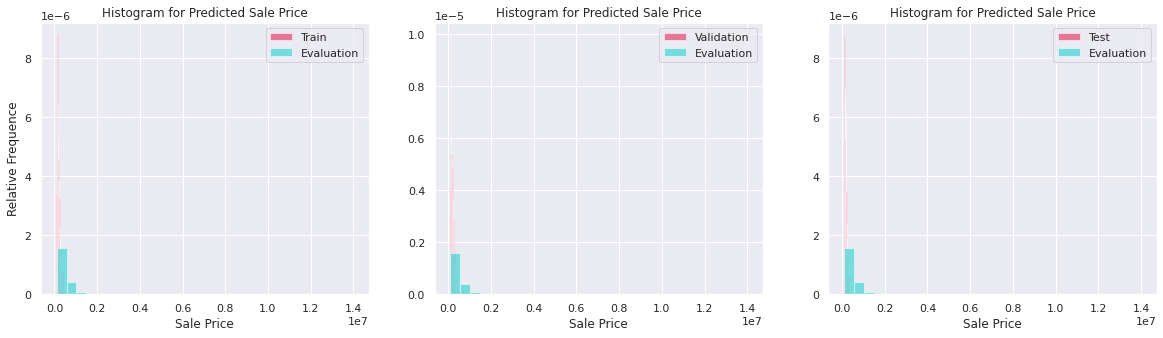

In [ ]:
#  Load test data
df_evaluation = pd.read_csv("test.csv", sep=",")

# Imputing missing values with median
df_evaluation["MasVnrArea"] = df_evaluation.MasVnrArea.fillna(df_evaluation.MasVnrArea.median())
df_evaluation["GarageYrBlt"] = df_evaluation.GarageYrBlt.fillna(df_evaluation.GarageYrBlt.median())
df_evaluation["LotFrontage"] = df_evaluation.LotFrontage.fillna(df_evaluation.LotFrontage.median())
df_evaluation["BsmtFinSF1"] = df_evaluation.BsmtFinSF1.fillna(df_evaluation.BsmtFinSF1.median())
df_evaluation["BsmtFinSF2"] = df_evaluation.BsmtFinSF2.fillna(df_evaluation.BsmtFinSF2.median())
df_evaluation["BsmtUnfSF"] = df_evaluation.BsmtUnfSF.fillna(df_evaluation.BsmtUnfSF.median())
df_evaluation["TotalBsmtSF"] = df_evaluation.TotalBsmtSF.fillna(df_evaluation.TotalBsmtSF.median())
df_evaluation["BsmtFullBath"] = df_evaluation.BsmtFullBath.fillna(df_evaluation.BsmtFullBath.median())
df_evaluation["BsmtHalfBath"] = df_evaluation.BsmtHalfBath.fillna(df_evaluation.BsmtHalfBath.median())
df_evaluation["GarageCars"] = df_evaluation.LotFrontage.fillna(df_evaluation.GarageCars.median())
df_evaluation["GarageArea"] = df_evaluation.GarageArea.fillna(df_evaluation.GarageArea.median())

# Imputing missing values with median
df_evaluation["MasVnrType"] = df_evaluation.MasVnrType.fillna(df_evaluation.MasVnrType.mode()[0])
df_evaluation["BsmtQual"] = df_evaluation.BsmtQual.fillna(df_evaluation.BsmtQual.mode()[0])
df_evaluation["BsmtCond"] = df_evaluation.BsmtCond.fillna(df_evaluation.BsmtCond.mode()[0])
df_evaluation["BsmtExposure"] = df_evaluation.BsmtExposure.fillna(df_evaluation.BsmtExposure.mode()[0])
df_evaluation["BsmtFinType1"] = df_evaluation.BsmtFinType1.fillna(df_evaluation.BsmtFinType1.mode()[0])
df_evaluation["BsmtFinType2"] = df_evaluation.BsmtFinType2.fillna(df_evaluation.BsmtFinType2.mode()[0])
df_evaluation["Electrical"] = df_evaluation.Electrical.fillna(df_evaluation.Electrical.mode()[0])
df_evaluation["GarageType"] = df_evaluation.GarageType.fillna(df_evaluation.GarageType.mode()[0])
df_evaluation["GarageFinish"] = df_evaluation.GarageFinish.fillna(df_evaluation.GarageFinish.mode()[0])
df_evaluation["GarageQual"] = df_evaluation.GarageQual.fillna(df_evaluation.GarageQual.mode()[0])
df_evaluation["GarageCond"] = df_evaluation.GarageCond.fillna(df_evaluation.GarageCond.mode()[0])

df_evaluation["MSZoning"] = df_evaluation.MSZoning.fillna(df_evaluation.MSZoning.mode()[0])
df_evaluation["Street"] = df_evaluation.Street.fillna(df_evaluation.Street.mode()[0])
df_evaluation["Alley"] = df_evaluation.Alley.fillna(df_evaluation.Alley.mode()[0])
df_evaluation["LotShape"] = df_evaluation.LotShape.fillna(df_evaluation.LotShape.mode()[0])
df_evaluation["LandContour"] = df_evaluation.LandContour.fillna(df_evaluation.LandContour.mode()[0])
df_evaluation["Utilities"] = df_evaluation.Utilities.fillna(df_evaluation.Utilities.mode()[0])
df_evaluation["LotConfig"] = df_evaluation.LotConfig.fillna(df_evaluation.LotConfig.mode()[0])
df_evaluation["LandSlope"] = df_evaluation.LandSlope.fillna(df_evaluation.LandSlope.mode()[0])
df_evaluation["Neighborhood"] = df_evaluation.Neighborhood.fillna(df_evaluation.Neighborhood.mode()[0])
df_evaluation["Condition1"] = df_evaluation.Condition1.fillna(df_evaluation.Condition1.mode()[0])
df_evaluation["Condition2"] = df_evaluation.Condition2.fillna(df_evaluation.Condition2.mode()[0])
df_evaluation["BldgType"] = df_evaluation.BldgType.fillna(df_evaluation.BldgType.mode()[0])
df_evaluation["HouseStyle"] = df_evaluation.HouseStyle.fillna(df_evaluation.HouseStyle.mode()[0])
df_evaluation["RoofStyle"] = df_evaluation.RoofStyle.fillna(df_evaluation.RoofStyle.mode()[0])
df_evaluation["RoofMatl"] = df_evaluation.RoofMatl.fillna(df_evaluation.RoofMatl.mode()[0])
df_evaluation["Exterior1st"] = df_evaluation.Exterior1st.fillna(df_evaluation.Exterior1st.mode()[0])
df_evaluation["Exterior2nd"] = df_evaluation.Exterior2nd.fillna(df_evaluation.Exterior2nd.mode()[0])
df_evaluation["ExterQual"] = df_evaluation.ExterQual.fillna(df_evaluation.ExterQual.mode()[0])
df_evaluation["ExterCond"] = df_evaluation.ExterCond.fillna(df_evaluation.ExterCond.mode()[0])
df_evaluation["Foundation"] = df_evaluation.Foundation.fillna(df_evaluation.Foundation.mode()[0])
df_evaluation["Heating"] = df_evaluation.Heating.fillna(df_evaluation.Heating.mode()[0])
df_evaluation["HeatingQC"] = df_evaluation.HeatingQC.fillna(df_evaluation.HeatingQC.mode()[0])
df_evaluation["CentralAir"] = df_evaluation.CentralAir.fillna(df_evaluation.CentralAir.mode()[0])
df_evaluation["KitchenQual"] = df_evaluation.KitchenQual.fillna(df_evaluation.KitchenQual.mode()[0])
df_evaluation["Functional"] = df_evaluation.Functional.fillna(df_evaluation.Functional.mode()[0])
df_evaluation["PavedDrive"] = df_evaluation.PavedDrive.fillna(df_evaluation.PavedDrive.mode()[0])
df_evaluation["PoolQC"] = df_evaluation.PoolQC.fillna(df_evaluation.PoolQC.mode()[0])
df_evaluation["Fence"] = df_evaluation.Fence.fillna(df_evaluation.Fence.mode()[0])
df_evaluation["MiscFeature"] = df_evaluation.MiscFeature.fillna(df_evaluation.MiscFeature.mode()[0])
df_evaluation["SaleType"] = df_evaluation.SaleType.fillna(df_evaluation.SaleType.mode()[0])
df_evaluation["SaleCondition"] = df_evaluation.SaleCondition.fillna(df_evaluation.SaleCondition.mode()[0])
df_evaluation["FireplaceQu"] = df_evaluation.FireplaceQu.fillna(df_evaluation.FireplaceQu.mode()[0])

# Create dummie variables and stack them with the previous dataframe

df_evaluation = pd.concat([df_evaluation, pd.get_dummies(df_evaluation.MSZoning, prefix='MSZoning_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Street, prefix='Street_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Alley, prefix='Alley_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotShape, prefix='LotShape_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandContour, prefix='LandContour_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Utilities, prefix='Utilities_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotConfig, prefix='LotConfig_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandSlope, prefix='LandSlope_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Neighborhood, prefix='Neighborhood_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition1, prefix='Condition1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition2, prefix='Condition2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BldgType, prefix='BldgType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HouseStyle, prefix='HouseStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofStyle, prefix='RoofStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofMatl, prefix='RoofMatl_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior1st, prefix='Exterior1st_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior2nd, prefix='Exterior2nd_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MasVnrType, prefix='MasVnrType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterQual, prefix='ExterQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterCond, prefix='ExterCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Foundation, prefix='Foundation_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtQual, prefix='BsmtQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtCond, prefix='BsmtCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtExposure, prefix='BsmtExposure_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType1, prefix='BsmtFinType1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType2, prefix='BsmtFinType2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Heating, prefix='Heating_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HeatingQC, prefix='HeatingQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.CentralAir, prefix='CentralAir_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Electrical, prefix='Electrical_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.KitchenQual, prefix='KitchenQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Functional, prefix='Functional_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.FireplaceQu, prefix='FireplaceQu_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageType, prefix='GarageType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageFinish, prefix='GarageFinish_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageQual, prefix='GarageQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageCond, prefix='GarageCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PavedDrive, prefix='PavedDrive_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PoolQC, prefix='PoolQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Fence, prefix='Fence_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MiscFeature, prefix='MiscFeature_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleType, prefix='SaleType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleCondition, prefix='SaleCondition_DM',drop_first=False)
          ], axis=1)

# Select only used variables 
df_evaluation_mod = df_evaluation.loc[:, df_evaluation.columns.isin(vars_select)].copy()
print("X Test shape:",df_evaluation_mod.shape)

# Make prediction over evaluation data
df_evaluation_mod['SalePrice'] = pd.DataFrame(np.expm1(ridge_grid.best_estimator_.predict(df_evaluation_mod)))
df_evaluation_mod['SalePrice']=np.where(df_evaluation_mod['SalePrice']<0, 0, df_evaluation_mod['SalePrice'])
df_evaluation_mod = pd.concat([df_evaluation['Id'].reset_index(drop=True), df_evaluation_mod['SalePrice']], axis=1)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(ypred_train.iloc[:,0]),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(ypred_val.iloc[:,0]),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(ypred_test.iloc[:,0]),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()


# Export file to submit in competition
# df_evaluation_mod.to_csv(submissions_path + '/House_Prices_ART_Ridge_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'ridge'
df_train_ens = pd.concat([df_train_ens, np.expm1(ypred_train.iloc[:,0])], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens, np.expm1(ypred_val.iloc[:,0])], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens, np.expm1(ypred_test.iloc[:,0])], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation_mod.SalePrice], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Elastic net regression technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = 
# To train the model then: load_model = False
load_model = True

# Select the explanatory variables to be used
vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','TotRmsAbvGrd','YearRemodAdd'
 ,'GarageYrBlt','Fireplaces','MasVnrArea','LotArea','BsmtFinSF1','OpenPorchSF','LotFrontage','WoodDeckSF','HalfBath','2ndFlrSF'
 ,'BsmtFullBath','BedroomAbvGr','BsmtUnfSF','EnclosedPorch','KitchenAbvGr','OverallCond','ScreenPorch','PoolArea','MSSubClass'
 ,'MoSold','BsmtFinSF2','3SsnPorch','YrSold','LowQualFinSF','MiscVal','BsmtHalfBath'

,'MSZoning_DM_C (all)','MSZoning_DM_FV','MSZoning_DM_RH','MSZoning_DM_RL','MSZoning_DM_RM','Street_DM_Grvl','Street_DM_Pave'
,'Alley_DM_Grvl','Alley_DM_Pave','LotShape_DM_IR1','LotShape_DM_IR2','LotShape_DM_IR3','LotShape_DM_Reg','LandContour_DM_Bnk'
,'LandContour_DM_HLS','LandContour_DM_Low','LandContour_DM_Lvl','Utilities_DM_AllPub','LotConfig_DM_Corner'
,'LotConfig_DM_CulDSac','LotConfig_DM_FR2','LotConfig_DM_FR3','LotConfig_DM_Inside','LandSlope_DM_Gtl','LandSlope_DM_Mod'
,'LandSlope_DM_Sev','Neighborhood_DM_Blmngtn','Neighborhood_DM_Blueste','Neighborhood_DM_BrDale','Neighborhood_DM_BrkSide'
,'Neighborhood_DM_ClearCr','Neighborhood_DM_CollgCr','Neighborhood_DM_Crawfor','Neighborhood_DM_Edwards','Neighborhood_DM_Gilbert'
,'Neighborhood_DM_IDOTRR','Neighborhood_DM_MeadowV','Neighborhood_DM_Mitchel','Neighborhood_DM_NAmes','Neighborhood_DM_NPkVill'
,'Neighborhood_DM_NWAmes','Neighborhood_DM_NoRidge','Neighborhood_DM_NridgHt','Neighborhood_DM_OldTown','Neighborhood_DM_SWISU'
,'Neighborhood_DM_Sawyer','Neighborhood_DM_SawyerW','Neighborhood_DM_Somerst','Neighborhood_DM_StoneBr','Neighborhood_DM_Timber'
,'Neighborhood_DM_Veenker','Condition1_DM_Artery','Condition1_DM_Feedr','Condition1_DM_Norm','Condition1_DM_PosA','Condition1_DM_PosN'
,'Condition1_DM_RRAe','Condition1_DM_RRAn','Condition1_DM_RRNe','Condition1_DM_RRNn','Condition2_DM_Artery','Condition2_DM_Feedr'
,'Condition2_DM_Norm','Condition2_DM_PosA','Condition2_DM_PosN'
,'BldgType_DM_1Fam','BldgType_DM_2fmCon','BldgType_DM_Duplex','BldgType_DM_Twnhs','BldgType_DM_TwnhsE','HouseStyle_DM_1.5Fin'
,'HouseStyle_DM_1.5Unf','HouseStyle_DM_1Story','HouseStyle_DM_2.5Unf','HouseStyle_DM_2Story','HouseStyle_DM_SFoyer'
,'HouseStyle_DM_SLvl','RoofStyle_DM_Flat','RoofStyle_DM_Gable','RoofStyle_DM_Gambrel','RoofStyle_DM_Hip','RoofStyle_DM_Mansard'
,'RoofStyle_DM_Shed','RoofMatl_DM_CompShg'
,'RoofMatl_DM_Tar&Grv','RoofMatl_DM_WdShake','RoofMatl_DM_WdShngl','Exterior1st_DM_AsbShng','Exterior1st_DM_AsphShn'
,'Exterior1st_DM_BrkComm','Exterior1st_DM_BrkFace','Exterior1st_DM_CBlock','Exterior1st_DM_CemntBd','Exterior1st_DM_HdBoard'
,'Exterior1st_DM_MetalSd','Exterior1st_DM_Plywood','Exterior1st_DM_Stucco'
,'Exterior1st_DM_VinylSd','Exterior1st_DM_Wd Sdng','Exterior1st_DM_WdShing','Exterior2nd_DM_AsbShng','Exterior2nd_DM_AsphShn'
,'Exterior2nd_DM_Brk Cmn','Exterior2nd_DM_BrkFace','Exterior2nd_DM_CBlock','Exterior2nd_DM_CmentBd','Exterior2nd_DM_HdBoard'
,'Exterior2nd_DM_ImStucc','Exterior2nd_DM_MetalSd','Exterior2nd_DM_Plywood','Exterior2nd_DM_Stone'
,'Exterior2nd_DM_Stucco','Exterior2nd_DM_VinylSd','Exterior2nd_DM_Wd Sdng','Exterior2nd_DM_Wd Shng','MasVnrType_DM_BrkCmn'
,'MasVnrType_DM_BrkFace','MasVnrType_DM_None','MasVnrType_DM_Stone','ExterQual_DM_Ex','ExterQual_DM_Fa','ExterQual_DM_Gd'
,'ExterQual_DM_TA','ExterCond_DM_Ex','ExterCond_DM_Fa','ExterCond_DM_Gd','ExterCond_DM_Po','ExterCond_DM_TA','Foundation_DM_BrkTil'
,'Foundation_DM_CBlock','Foundation_DM_PConc','Foundation_DM_Slab','Foundation_DM_Stone','Foundation_DM_Wood','BsmtQual_DM_Ex'
,'BsmtQual_DM_Fa','BsmtQual_DM_Gd','BsmtQual_DM_TA','BsmtCond_DM_Fa','BsmtCond_DM_Gd','BsmtCond_DM_Po','BsmtCond_DM_TA','BsmtExposure_DM_Av'
,'BsmtExposure_DM_Gd','BsmtExposure_DM_Mn','BsmtExposure_DM_No','BsmtFinType1_DM_ALQ','BsmtFinType1_DM_BLQ','BsmtFinType1_DM_GLQ'
,'BsmtFinType1_DM_LwQ','BsmtFinType1_DM_Rec','BsmtFinType1_DM_Unf','BsmtFinType2_DM_ALQ','BsmtFinType2_DM_BLQ','BsmtFinType2_DM_GLQ'
,'BsmtFinType2_DM_LwQ','BsmtFinType2_DM_Rec','BsmtFinType2_DM_Unf','Heating_DM_GasA','Heating_DM_GasW','Heating_DM_Grav'
,'Heating_DM_Wall','HeatingQC_DM_Ex','HeatingQC_DM_Fa','HeatingQC_DM_Gd','HeatingQC_DM_Po','HeatingQC_DM_TA'
,'CentralAir_DM_N','CentralAir_DM_Y','Electrical_DM_FuseA','Electrical_DM_FuseF','Electrical_DM_FuseP'
,'Electrical_DM_SBrkr','KitchenQual_DM_Ex','KitchenQual_DM_Fa','KitchenQual_DM_Gd','KitchenQual_DM_TA','Functional_DM_Maj1'
,'Functional_DM_Maj2','Functional_DM_Min1','Functional_DM_Min2','Functional_DM_Mod','Functional_DM_Sev','Functional_DM_Typ'
,'FireplaceQu_DM_Ex','FireplaceQu_DM_Fa','FireplaceQu_DM_Gd','FireplaceQu_DM_Po','FireplaceQu_DM_TA','GarageType_DM_2Types'
,'GarageType_DM_Attchd','GarageType_DM_Basment','GarageType_DM_BuiltIn','GarageType_DM_CarPort','GarageType_DM_Detchd'
,'GarageFinish_DM_Fin','GarageFinish_DM_RFn','GarageFinish_DM_Unf','GarageQual_DM_Fa','GarageQual_DM_Gd'
,'GarageQual_DM_Po','GarageQual_DM_TA','GarageCond_DM_Ex','GarageCond_DM_Fa','GarageCond_DM_Gd','GarageCond_DM_Po'
,'GarageCond_DM_TA','PavedDrive_DM_N','PavedDrive_DM_P','PavedDrive_DM_Y','PoolQC_DM_Ex','PoolQC_DM_Gd'
,'Fence_DM_GdPrv','Fence_DM_GdWo','Fence_DM_MnPrv','Fence_DM_MnWw','MiscFeature_DM_Gar2','MiscFeature_DM_Othr','MiscFeature_DM_Shed'
,'SaleType_DM_COD','SaleType_DM_CWD','SaleType_DM_Con','SaleType_DM_ConLD','SaleType_DM_ConLI','SaleType_DM_ConLw'
,'SaleType_DM_New','SaleType_DM_Oth','SaleType_DM_WD','SaleCondition_DM_Abnorml','SaleCondition_DM_AdjLand','SaleCondition_DM_Alloca'
,'SaleCondition_DM_Family','SaleCondition_DM_Normal','SaleCondition_DM_Partial'

               ]

x = new_df.loc[:, new_df.columns.isin(vars_select)].copy()
# Select the response variable (we take the long since it's recommended for large-scaled variables)
y = new_df.loc[:, new_df.columns == "SalePrice"].copy()
# y = np.log(new_df.loc[:, new_df.columns == "SalePrice"].copy())


# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 30% of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/elasticnet_model.pkl','rb')
  elasticnet_grid = pickle.load(infile)
else:
  #Define the grid to be searched in
  elasticnet = ElasticNet(random_state=12345)

  # Create the random grid
  parameters = {'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
                ,'l1_ratio': np.arange(0, 1, 0.01)}
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  elasticnet_grid = RandomizedSearchCV(estimator = elasticnet, param_distributions = parameters, n_iter = 100, cv = 5, verbose=False, random_state=0, n_jobs = -1)
  # Fit the random search model
  elasticnet_grid.fit(x_train, y_train)
  
  #Save model
  with open(models_path + '/elasticnet_model.pkl', 'wb') as pickfile:
     pickle.dump(elasticnet_grid, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(elasticnet_grid.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = pd.DataFrame(elasticnet_grid.best_estimator_.predict(x_train))
ypred_train.columns = ['value']
ypred_train['value']=np.where(ypred_train['value']<0, 0, ypred_train['value'])
# Predict values of regression with validation
ypred_val = pd.DataFrame(elasticnet_grid.best_estimator_.predict(x_val))
ypred_val.columns = ['value']
ypred_val['value']=np.where(ypred_val['value']<0, 0, ypred_val['value'])
# Predict values of regression with test
ypred_test = pd.DataFrame(elasticnet_grid.best_estimator_.predict(x_test))
ypred_test.columns = ['value']
ypred_test['value']=np.where(ypred_test['value']<0, 0, ypred_test['value'])

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(elasticnet_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (876, 270)
Y Train shape: (876, 1)
X Validation shape: (292, 270)
Y Validation shape: (292, 1)
X Test shape: (292, 270)
Y Test shape: (292, 1)
Best parameters found: 
{'l1_ratio': 0.72, 'alpha': 0.001}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.10425, 0.14767, 0.10874
Feature importance:
Ejecución: 0.5208339691162109 seconds


X Test shape: (1459, 270)


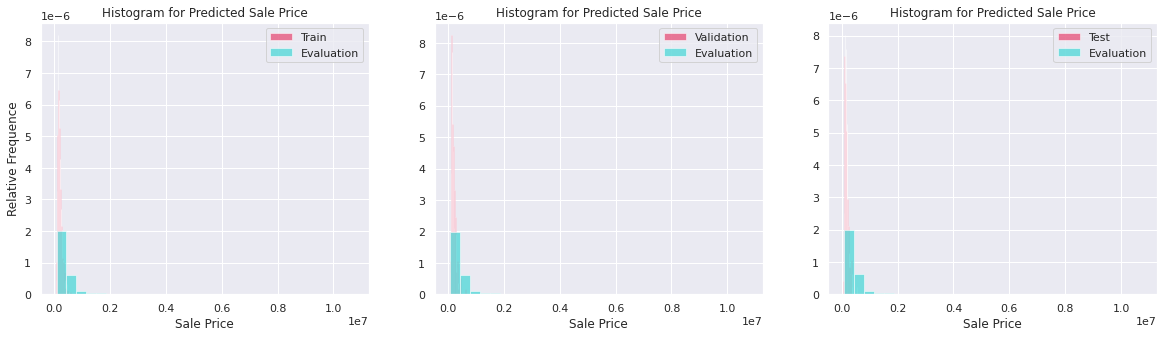

In [ ]:
#  Load test data
df_evaluation = pd.read_csv("test.csv", sep=",")

# Imputing missing values with median
df_evaluation["MasVnrArea"] = df_evaluation.MasVnrArea.fillna(df_evaluation.MasVnrArea.median())
df_evaluation["GarageYrBlt"] = df_evaluation.GarageYrBlt.fillna(df_evaluation.GarageYrBlt.median())
df_evaluation["LotFrontage"] = df_evaluation.LotFrontage.fillna(df_evaluation.LotFrontage.median())
df_evaluation["BsmtFinSF1"] = df_evaluation.BsmtFinSF1.fillna(df_evaluation.BsmtFinSF1.median())
df_evaluation["BsmtFinSF2"] = df_evaluation.BsmtFinSF2.fillna(df_evaluation.BsmtFinSF2.median())
df_evaluation["BsmtUnfSF"] = df_evaluation.BsmtUnfSF.fillna(df_evaluation.BsmtUnfSF.median())
df_evaluation["TotalBsmtSF"] = df_evaluation.TotalBsmtSF.fillna(df_evaluation.TotalBsmtSF.median())
df_evaluation["BsmtFullBath"] = df_evaluation.BsmtFullBath.fillna(df_evaluation.BsmtFullBath.median())
df_evaluation["BsmtHalfBath"] = df_evaluation.BsmtHalfBath.fillna(df_evaluation.BsmtHalfBath.median())
df_evaluation["GarageCars"] = df_evaluation.LotFrontage.fillna(df_evaluation.GarageCars.median())
df_evaluation["GarageArea"] = df_evaluation.GarageArea.fillna(df_evaluation.GarageArea.median())

# Imputing missing values with median
df_evaluation["MasVnrType"] = df_evaluation.MasVnrType.fillna(df_evaluation.MasVnrType.mode()[0])
df_evaluation["BsmtQual"] = df_evaluation.BsmtQual.fillna(df_evaluation.BsmtQual.mode()[0])
df_evaluation["BsmtCond"] = df_evaluation.BsmtCond.fillna(df_evaluation.BsmtCond.mode()[0])
df_evaluation["BsmtExposure"] = df_evaluation.BsmtExposure.fillna(df_evaluation.BsmtExposure.mode()[0])
df_evaluation["BsmtFinType1"] = df_evaluation.BsmtFinType1.fillna(df_evaluation.BsmtFinType1.mode()[0])
df_evaluation["BsmtFinType2"] = df_evaluation.BsmtFinType2.fillna(df_evaluation.BsmtFinType2.mode()[0])
df_evaluation["Electrical"] = df_evaluation.Electrical.fillna(df_evaluation.Electrical.mode()[0])
df_evaluation["GarageType"] = df_evaluation.GarageType.fillna(df_evaluation.GarageType.mode()[0])
df_evaluation["GarageFinish"] = df_evaluation.GarageFinish.fillna(df_evaluation.GarageFinish.mode()[0])
df_evaluation["GarageQual"] = df_evaluation.GarageQual.fillna(df_evaluation.GarageQual.mode()[0])
df_evaluation["GarageCond"] = df_evaluation.GarageCond.fillna(df_evaluation.GarageCond.mode()[0])

df_evaluation["MSZoning"] = df_evaluation.MSZoning.fillna(df_evaluation.MSZoning.mode()[0])
df_evaluation["Street"] = df_evaluation.Street.fillna(df_evaluation.Street.mode()[0])
df_evaluation["Alley"] = df_evaluation.Alley.fillna(df_evaluation.Alley.mode()[0])
df_evaluation["LotShape"] = df_evaluation.LotShape.fillna(df_evaluation.LotShape.mode()[0])
df_evaluation["LandContour"] = df_evaluation.LandContour.fillna(df_evaluation.LandContour.mode()[0])
df_evaluation["Utilities"] = df_evaluation.Utilities.fillna(df_evaluation.Utilities.mode()[0])
df_evaluation["LotConfig"] = df_evaluation.LotConfig.fillna(df_evaluation.LotConfig.mode()[0])
df_evaluation["LandSlope"] = df_evaluation.LandSlope.fillna(df_evaluation.LandSlope.mode()[0])
df_evaluation["Neighborhood"] = df_evaluation.Neighborhood.fillna(df_evaluation.Neighborhood.mode()[0])
df_evaluation["Condition1"] = df_evaluation.Condition1.fillna(df_evaluation.Condition1.mode()[0])
df_evaluation["Condition2"] = df_evaluation.Condition2.fillna(df_evaluation.Condition2.mode()[0])
df_evaluation["BldgType"] = df_evaluation.BldgType.fillna(df_evaluation.BldgType.mode()[0])
df_evaluation["HouseStyle"] = df_evaluation.HouseStyle.fillna(df_evaluation.HouseStyle.mode()[0])
df_evaluation["RoofStyle"] = df_evaluation.RoofStyle.fillna(df_evaluation.RoofStyle.mode()[0])
df_evaluation["RoofMatl"] = df_evaluation.RoofMatl.fillna(df_evaluation.RoofMatl.mode()[0])
df_evaluation["Exterior1st"] = df_evaluation.Exterior1st.fillna(df_evaluation.Exterior1st.mode()[0])
df_evaluation["Exterior2nd"] = df_evaluation.Exterior2nd.fillna(df_evaluation.Exterior2nd.mode()[0])
df_evaluation["ExterQual"] = df_evaluation.ExterQual.fillna(df_evaluation.ExterQual.mode()[0])
df_evaluation["ExterCond"] = df_evaluation.ExterCond.fillna(df_evaluation.ExterCond.mode()[0])
df_evaluation["Foundation"] = df_evaluation.Foundation.fillna(df_evaluation.Foundation.mode()[0])
df_evaluation["Heating"] = df_evaluation.Heating.fillna(df_evaluation.Heating.mode()[0])
df_evaluation["HeatingQC"] = df_evaluation.HeatingQC.fillna(df_evaluation.HeatingQC.mode()[0])
df_evaluation["CentralAir"] = df_evaluation.CentralAir.fillna(df_evaluation.CentralAir.mode()[0])
df_evaluation["KitchenQual"] = df_evaluation.KitchenQual.fillna(df_evaluation.KitchenQual.mode()[0])
df_evaluation["Functional"] = df_evaluation.Functional.fillna(df_evaluation.Functional.mode()[0])
df_evaluation["PavedDrive"] = df_evaluation.PavedDrive.fillna(df_evaluation.PavedDrive.mode()[0])
df_evaluation["PoolQC"] = df_evaluation.PoolQC.fillna(df_evaluation.PoolQC.mode()[0])
df_evaluation["Fence"] = df_evaluation.Fence.fillna(df_evaluation.Fence.mode()[0])
df_evaluation["MiscFeature"] = df_evaluation.MiscFeature.fillna(df_evaluation.MiscFeature.mode()[0])
df_evaluation["SaleType"] = df_evaluation.SaleType.fillna(df_evaluation.SaleType.mode()[0])
df_evaluation["SaleCondition"] = df_evaluation.SaleCondition.fillna(df_evaluation.SaleCondition.mode()[0])
df_evaluation["FireplaceQu"] = df_evaluation.FireplaceQu.fillna(df_evaluation.FireplaceQu.mode()[0])

# Create dummie variables and stack them with the previous dataframe

df_evaluation = pd.concat([df_evaluation, pd.get_dummies(df_evaluation.MSZoning, prefix='MSZoning_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Street, prefix='Street_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Alley, prefix='Alley_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotShape, prefix='LotShape_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandContour, prefix='LandContour_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Utilities, prefix='Utilities_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotConfig, prefix='LotConfig_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandSlope, prefix='LandSlope_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Neighborhood, prefix='Neighborhood_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition1, prefix='Condition1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition2, prefix='Condition2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BldgType, prefix='BldgType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HouseStyle, prefix='HouseStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofStyle, prefix='RoofStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofMatl, prefix='RoofMatl_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior1st, prefix='Exterior1st_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior2nd, prefix='Exterior2nd_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MasVnrType, prefix='MasVnrType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterQual, prefix='ExterQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterCond, prefix='ExterCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Foundation, prefix='Foundation_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtQual, prefix='BsmtQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtCond, prefix='BsmtCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtExposure, prefix='BsmtExposure_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType1, prefix='BsmtFinType1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType2, prefix='BsmtFinType2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Heating, prefix='Heating_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HeatingQC, prefix='HeatingQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.CentralAir, prefix='CentralAir_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Electrical, prefix='Electrical_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.KitchenQual, prefix='KitchenQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Functional, prefix='Functional_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.FireplaceQu, prefix='FireplaceQu_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageType, prefix='GarageType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageFinish, prefix='GarageFinish_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageQual, prefix='GarageQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageCond, prefix='GarageCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PavedDrive, prefix='PavedDrive_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PoolQC, prefix='PoolQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Fence, prefix='Fence_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MiscFeature, prefix='MiscFeature_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleType, prefix='SaleType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleCondition, prefix='SaleCondition_DM',drop_first=False)
          ], axis=1)

# Select only used variables 
df_evaluation_mod = df_evaluation.loc[:, df_evaluation.columns.isin(vars_select)].copy()
print("X Test shape:",df_evaluation_mod.shape)

# Make prediction over evaluation data
df_evaluation_mod['SalePrice'] = pd.DataFrame(np.expm1(elasticnet_grid.best_estimator_.predict(df_evaluation_mod)))
df_evaluation_mod['SalePrice']=np.where(df_evaluation_mod['SalePrice']<0, 0, df_evaluation_mod['SalePrice'])
df_evaluation_mod = pd.concat([df_evaluation['Id'].reset_index(drop=True), df_evaluation_mod['SalePrice']], axis=1)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(ypred_train.iloc[:,0]),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(ypred_val.iloc[:,0]),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(ypred_test.iloc[:,0]),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation_mod.to_csv(submissions_path + '/House_Prices_ART_ElasticNet_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'enet'
df_train_ens = pd.concat([df_train_ens, np.expm1(ypred_train.iloc[:,0])], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens, np.expm1(ypred_val.iloc[:,0])], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens, np.expm1(ypred_test.iloc[:,0])], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation_mod.SalePrice], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Neural Networks (Multi-Layer Perceptron) technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = 
# To train the model then: load_model = False
load_model = True

# Select the explanatory variables to be used
vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','TotRmsAbvGrd','YearRemodAdd'

 ,'GarageYrBlt','Fireplaces','MasVnrArea','LotArea','BsmtFinSF1','OpenPorchSF','LotFrontage','WoodDeckSF','HalfBath','2ndFlrSF'
 ,'BsmtFullBath','BedroomAbvGr','BsmtUnfSF','EnclosedPorch','KitchenAbvGr','OverallCond','ScreenPorch','PoolArea','MSSubClass'
 ,'MoSold','BsmtFinSF2','3SsnPorch','YrSold','LowQualFinSF','MiscVal','BsmtHalfBath'

,'MSZoning_DM_C (all)','MSZoning_DM_FV','MSZoning_DM_RH','MSZoning_DM_RL','MSZoning_DM_RM','Street_DM_Grvl','Street_DM_Pave'
,'Alley_DM_Grvl','Alley_DM_Pave','LotShape_DM_IR1','LotShape_DM_IR2','LotShape_DM_IR3','LotShape_DM_Reg','LandContour_DM_Bnk'
,'LandContour_DM_HLS','LandContour_DM_Low','LandContour_DM_Lvl','Utilities_DM_AllPub','LotConfig_DM_Corner'
,'LotConfig_DM_CulDSac','LotConfig_DM_FR2','LotConfig_DM_FR3','LotConfig_DM_Inside','LandSlope_DM_Gtl','LandSlope_DM_Mod'
,'LandSlope_DM_Sev','Neighborhood_DM_Blmngtn','Neighborhood_DM_Blueste','Neighborhood_DM_BrDale','Neighborhood_DM_BrkSide'
,'Neighborhood_DM_ClearCr','Neighborhood_DM_CollgCr','Neighborhood_DM_Crawfor','Neighborhood_DM_Edwards','Neighborhood_DM_Gilbert'
,'Neighborhood_DM_IDOTRR','Neighborhood_DM_MeadowV','Neighborhood_DM_Mitchel','Neighborhood_DM_NAmes','Neighborhood_DM_NPkVill'
,'Neighborhood_DM_NWAmes','Neighborhood_DM_NoRidge','Neighborhood_DM_NridgHt','Neighborhood_DM_OldTown','Neighborhood_DM_SWISU'
,'Neighborhood_DM_Sawyer','Neighborhood_DM_SawyerW','Neighborhood_DM_Somerst','Neighborhood_DM_StoneBr','Neighborhood_DM_Timber'
,'Neighborhood_DM_Veenker','Condition1_DM_Artery','Condition1_DM_Feedr','Condition1_DM_Norm','Condition1_DM_PosA','Condition1_DM_PosN'
,'Condition1_DM_RRAe','Condition1_DM_RRAn','Condition1_DM_RRNe','Condition1_DM_RRNn','Condition2_DM_Artery','Condition2_DM_Feedr'
,'Condition2_DM_Norm','Condition2_DM_PosA','Condition2_DM_PosN'
,'BldgType_DM_1Fam','BldgType_DM_2fmCon','BldgType_DM_Duplex','BldgType_DM_Twnhs','BldgType_DM_TwnhsE','HouseStyle_DM_1.5Fin'
,'HouseStyle_DM_1.5Unf','HouseStyle_DM_1Story','HouseStyle_DM_2.5Unf','HouseStyle_DM_2Story','HouseStyle_DM_SFoyer'
,'HouseStyle_DM_SLvl','RoofStyle_DM_Flat','RoofStyle_DM_Gable','RoofStyle_DM_Gambrel','RoofStyle_DM_Hip','RoofStyle_DM_Mansard'
,'RoofStyle_DM_Shed','RoofMatl_DM_CompShg'
,'RoofMatl_DM_Tar&Grv','RoofMatl_DM_WdShake','RoofMatl_DM_WdShngl','Exterior1st_DM_AsbShng','Exterior1st_DM_AsphShn'
,'Exterior1st_DM_BrkComm','Exterior1st_DM_BrkFace','Exterior1st_DM_CBlock','Exterior1st_DM_CemntBd','Exterior1st_DM_HdBoard'
,'Exterior1st_DM_MetalSd','Exterior1st_DM_Plywood','Exterior1st_DM_Stucco'
,'Exterior1st_DM_VinylSd','Exterior1st_DM_Wd Sdng','Exterior1st_DM_WdShing','Exterior2nd_DM_AsbShng','Exterior2nd_DM_AsphShn'
,'Exterior2nd_DM_Brk Cmn','Exterior2nd_DM_BrkFace','Exterior2nd_DM_CBlock','Exterior2nd_DM_CmentBd','Exterior2nd_DM_HdBoard'
,'Exterior2nd_DM_ImStucc','Exterior2nd_DM_MetalSd','Exterior2nd_DM_Plywood','Exterior2nd_DM_Stone'
,'Exterior2nd_DM_Stucco','Exterior2nd_DM_VinylSd','Exterior2nd_DM_Wd Sdng','Exterior2nd_DM_Wd Shng','MasVnrType_DM_BrkCmn'
,'MasVnrType_DM_BrkFace','MasVnrType_DM_None','MasVnrType_DM_Stone','ExterQual_DM_Ex','ExterQual_DM_Fa','ExterQual_DM_Gd'
,'ExterQual_DM_TA','ExterCond_DM_Ex','ExterCond_DM_Fa','ExterCond_DM_Gd','ExterCond_DM_Po','ExterCond_DM_TA','Foundation_DM_BrkTil'
,'Foundation_DM_CBlock','Foundation_DM_PConc','Foundation_DM_Slab','Foundation_DM_Stone','Foundation_DM_Wood','BsmtQual_DM_Ex'
,'BsmtQual_DM_Fa','BsmtQual_DM_Gd','BsmtQual_DM_TA','BsmtCond_DM_Fa','BsmtCond_DM_Gd','BsmtCond_DM_Po','BsmtCond_DM_TA','BsmtExposure_DM_Av'
,'BsmtExposure_DM_Gd','BsmtExposure_DM_Mn','BsmtExposure_DM_No','BsmtFinType1_DM_ALQ','BsmtFinType1_DM_BLQ','BsmtFinType1_DM_GLQ'
,'BsmtFinType1_DM_LwQ','BsmtFinType1_DM_Rec','BsmtFinType1_DM_Unf','BsmtFinType2_DM_ALQ','BsmtFinType2_DM_BLQ','BsmtFinType2_DM_GLQ'
,'BsmtFinType2_DM_LwQ','BsmtFinType2_DM_Rec','BsmtFinType2_DM_Unf','Heating_DM_GasA','Heating_DM_GasW','Heating_DM_Grav'
,'Heating_DM_Wall','HeatingQC_DM_Ex','HeatingQC_DM_Fa','HeatingQC_DM_Gd','HeatingQC_DM_Po','HeatingQC_DM_TA'
,'CentralAir_DM_N','CentralAir_DM_Y','Electrical_DM_FuseA','Electrical_DM_FuseF','Electrical_DM_FuseP'
,'Electrical_DM_SBrkr','KitchenQual_DM_Ex','KitchenQual_DM_Fa','KitchenQual_DM_Gd','KitchenQual_DM_TA','Functional_DM_Maj1'
,'Functional_DM_Maj2','Functional_DM_Min1','Functional_DM_Min2','Functional_DM_Mod','Functional_DM_Sev','Functional_DM_Typ'
,'FireplaceQu_DM_Ex','FireplaceQu_DM_Fa','FireplaceQu_DM_Gd','FireplaceQu_DM_Po','FireplaceQu_DM_TA','GarageType_DM_2Types'
,'GarageType_DM_Attchd','GarageType_DM_Basment','GarageType_DM_BuiltIn','GarageType_DM_CarPort','GarageType_DM_Detchd'
,'GarageFinish_DM_Fin','GarageFinish_DM_RFn','GarageFinish_DM_Unf','GarageQual_DM_Fa','GarageQual_DM_Gd'
,'GarageQual_DM_Po','GarageQual_DM_TA','GarageCond_DM_Ex','GarageCond_DM_Fa','GarageCond_DM_Gd','GarageCond_DM_Po'
,'GarageCond_DM_TA','PavedDrive_DM_N','PavedDrive_DM_P','PavedDrive_DM_Y','PoolQC_DM_Ex','PoolQC_DM_Gd'
,'Fence_DM_GdPrv','Fence_DM_GdWo','Fence_DM_MnPrv','Fence_DM_MnWw','MiscFeature_DM_Gar2','MiscFeature_DM_Othr','MiscFeature_DM_Shed'
,'SaleType_DM_COD','SaleType_DM_CWD','SaleType_DM_Con','SaleType_DM_ConLD','SaleType_DM_ConLI','SaleType_DM_ConLw'
,'SaleType_DM_New','SaleType_DM_Oth','SaleType_DM_WD','SaleCondition_DM_Abnorml','SaleCondition_DM_AdjLand','SaleCondition_DM_Alloca'
,'SaleCondition_DM_Family','SaleCondition_DM_Normal','SaleCondition_DM_Partial'


               ]



x = new_df.loc[:, new_df.columns.isin(vars_select)].copy()

# Select the response variable (we take the long since it's recommended for large-scaled variables)
y = new_df.loc[:, new_df.columns == "SalePrice"].copy()
# y = np.log(new_df.loc[:, new_df.columns == "SalePrice"].copy())


# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 30% of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/MLPNN_model.pkl','rb')
  MPLNN_grid = pickle.load(infile)

else:
  #Define the grid to be searched in
  MPLNN = MLPRegressor(max_iter=100, random_state=12345)

  # Create the random grid
  parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  MPLNN_grid = RandomizedSearchCV(estimator = MPLNN, param_distributions = parameters, n_iter = 100, cv = 5, verbose=False, random_state=0, n_jobs = -1)
  # Fit the random search model
  MPLNN_grid.fit(x_train, y_train)
  
  #Save model
  with open(models_path + '/MLPNN_model.pkl', 'wb') as pickfile:
     pickle.dump(MPLNN_grid, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(MPLNN_grid.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = pd.DataFrame(MPLNN_grid.best_estimator_.predict(x_train))
ypred_train.columns = ['value']
ypred_train['value']=np.where(ypred_train['value']<0, 0, ypred_train['value'])
# Predict values of regression with validation
ypred_val = pd.DataFrame(MPLNN_grid.best_estimator_.predict(x_val))
ypred_val.columns = ['value']
ypred_val['value']=np.where(ypred_val['value']<0, 0, ypred_val['value'])
# Predict values of regression with test
ypred_test = pd.DataFrame(MPLNN_grid.best_estimator_.predict(x_test))
ypred_test.columns = ['value']
ypred_test['value']=np.where(ypred_test['value']<0, 0, ypred_test['value'])

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(MPLNN_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (876, 270)
Y Train shape: (876, 1)
X Validation shape: (292, 270)
Y Validation shape: (292, 1)
X Test shape: (292, 270)
Y Test shape: (292, 1)
Best parameters found: 
{'learning_rate': 'constant', 'hidden_layer_sizes': (50, 100, 50), 'alpha': 0.0001}
Evaluating results of the regression:
RMSE Score for train, validation, test: 12.49679, 4.05119, 3.89287
Feature importance:
Ejecución: 0.6252734661102295 seconds


X Test shape: (1459, 270)


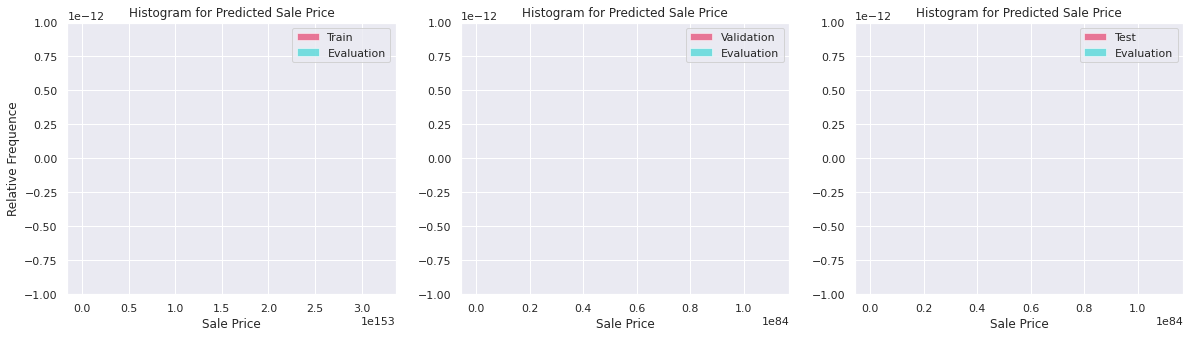

In [ ]:
#  Load test data
df_evaluation = pd.read_csv("test.csv", sep=",")

# Imputing missing values with median
df_evaluation["MasVnrArea"] = df_evaluation.MasVnrArea.fillna(df_evaluation.MasVnrArea.median())
df_evaluation["GarageYrBlt"] = df_evaluation.GarageYrBlt.fillna(df_evaluation.GarageYrBlt.median())
df_evaluation["LotFrontage"] = df_evaluation.LotFrontage.fillna(df_evaluation.LotFrontage.median())
df_evaluation["BsmtFinSF1"] = df_evaluation.BsmtFinSF1.fillna(df_evaluation.BsmtFinSF1.median())
df_evaluation["BsmtFinSF2"] = df_evaluation.BsmtFinSF2.fillna(df_evaluation.BsmtFinSF2.median())
df_evaluation["BsmtUnfSF"] = df_evaluation.BsmtUnfSF.fillna(df_evaluation.BsmtUnfSF.median())
df_evaluation["TotalBsmtSF"] = df_evaluation.TotalBsmtSF.fillna(df_evaluation.TotalBsmtSF.median())
df_evaluation["BsmtFullBath"] = df_evaluation.BsmtFullBath.fillna(df_evaluation.BsmtFullBath.median())
df_evaluation["BsmtHalfBath"] = df_evaluation.BsmtHalfBath.fillna(df_evaluation.BsmtHalfBath.median())
df_evaluation["GarageCars"] = df_evaluation.LotFrontage.fillna(df_evaluation.GarageCars.median())
df_evaluation["GarageArea"] = df_evaluation.GarageArea.fillna(df_evaluation.GarageArea.median())

# Imputing missing values with median
df_evaluation["MasVnrType"] = df_evaluation.MasVnrType.fillna(df_evaluation.MasVnrType.mode()[0])
df_evaluation["BsmtQual"] = df_evaluation.BsmtQual.fillna(df_evaluation.BsmtQual.mode()[0])
df_evaluation["BsmtCond"] = df_evaluation.BsmtCond.fillna(df_evaluation.BsmtCond.mode()[0])
df_evaluation["BsmtExposure"] = df_evaluation.BsmtExposure.fillna(df_evaluation.BsmtExposure.mode()[0])
df_evaluation["BsmtFinType1"] = df_evaluation.BsmtFinType1.fillna(df_evaluation.BsmtFinType1.mode()[0])
df_evaluation["BsmtFinType2"] = df_evaluation.BsmtFinType2.fillna(df_evaluation.BsmtFinType2.mode()[0])
df_evaluation["Electrical"] = df_evaluation.Electrical.fillna(df_evaluation.Electrical.mode()[0])
df_evaluation["GarageType"] = df_evaluation.GarageType.fillna(df_evaluation.GarageType.mode()[0])
df_evaluation["GarageFinish"] = df_evaluation.GarageFinish.fillna(df_evaluation.GarageFinish.mode()[0])
df_evaluation["GarageQual"] = df_evaluation.GarageQual.fillna(df_evaluation.GarageQual.mode()[0])
df_evaluation["GarageCond"] = df_evaluation.GarageCond.fillna(df_evaluation.GarageCond.mode()[0])

df_evaluation["MSZoning"] = df_evaluation.MSZoning.fillna(df_evaluation.MSZoning.mode()[0])
df_evaluation["Street"] = df_evaluation.Street.fillna(df_evaluation.Street.mode()[0])
df_evaluation["Alley"] = df_evaluation.Alley.fillna(df_evaluation.Alley.mode()[0])
df_evaluation["LotShape"] = df_evaluation.LotShape.fillna(df_evaluation.LotShape.mode()[0])
df_evaluation["LandContour"] = df_evaluation.LandContour.fillna(df_evaluation.LandContour.mode()[0])
df_evaluation["Utilities"] = df_evaluation.Utilities.fillna(df_evaluation.Utilities.mode()[0])
df_evaluation["LotConfig"] = df_evaluation.LotConfig.fillna(df_evaluation.LotConfig.mode()[0])
df_evaluation["LandSlope"] = df_evaluation.LandSlope.fillna(df_evaluation.LandSlope.mode()[0])
df_evaluation["Neighborhood"] = df_evaluation.Neighborhood.fillna(df_evaluation.Neighborhood.mode()[0])
df_evaluation["Condition1"] = df_evaluation.Condition1.fillna(df_evaluation.Condition1.mode()[0])
df_evaluation["Condition2"] = df_evaluation.Condition2.fillna(df_evaluation.Condition2.mode()[0])
df_evaluation["BldgType"] = df_evaluation.BldgType.fillna(df_evaluation.BldgType.mode()[0])
df_evaluation["HouseStyle"] = df_evaluation.HouseStyle.fillna(df_evaluation.HouseStyle.mode()[0])
df_evaluation["RoofStyle"] = df_evaluation.RoofStyle.fillna(df_evaluation.RoofStyle.mode()[0])
df_evaluation["RoofMatl"] = df_evaluation.RoofMatl.fillna(df_evaluation.RoofMatl.mode()[0])
df_evaluation["Exterior1st"] = df_evaluation.Exterior1st.fillna(df_evaluation.Exterior1st.mode()[0])
df_evaluation["Exterior2nd"] = df_evaluation.Exterior2nd.fillna(df_evaluation.Exterior2nd.mode()[0])
df_evaluation["ExterQual"] = df_evaluation.ExterQual.fillna(df_evaluation.ExterQual.mode()[0])
df_evaluation["ExterCond"] = df_evaluation.ExterCond.fillna(df_evaluation.ExterCond.mode()[0])
df_evaluation["Foundation"] = df_evaluation.Foundation.fillna(df_evaluation.Foundation.mode()[0])
df_evaluation["Heating"] = df_evaluation.Heating.fillna(df_evaluation.Heating.mode()[0])
df_evaluation["HeatingQC"] = df_evaluation.HeatingQC.fillna(df_evaluation.HeatingQC.mode()[0])
df_evaluation["CentralAir"] = df_evaluation.CentralAir.fillna(df_evaluation.CentralAir.mode()[0])
df_evaluation["KitchenQual"] = df_evaluation.KitchenQual.fillna(df_evaluation.KitchenQual.mode()[0])
df_evaluation["Functional"] = df_evaluation.Functional.fillna(df_evaluation.Functional.mode()[0])
df_evaluation["PavedDrive"] = df_evaluation.PavedDrive.fillna(df_evaluation.PavedDrive.mode()[0])
df_evaluation["PoolQC"] = df_evaluation.PoolQC.fillna(df_evaluation.PoolQC.mode()[0])
df_evaluation["Fence"] = df_evaluation.Fence.fillna(df_evaluation.Fence.mode()[0])
df_evaluation["MiscFeature"] = df_evaluation.MiscFeature.fillna(df_evaluation.MiscFeature.mode()[0])
df_evaluation["SaleType"] = df_evaluation.SaleType.fillna(df_evaluation.SaleType.mode()[0])
df_evaluation["SaleCondition"] = df_evaluation.SaleCondition.fillna(df_evaluation.SaleCondition.mode()[0])
df_evaluation["FireplaceQu"] = df_evaluation.FireplaceQu.fillna(df_evaluation.FireplaceQu.mode()[0])

# Create dummie variables and stack them with the previous dataframe

df_evaluation = pd.concat([df_evaluation, pd.get_dummies(df_evaluation.MSZoning, prefix='MSZoning_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Street, prefix='Street_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Alley, prefix='Alley_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotShape, prefix='LotShape_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandContour, prefix='LandContour_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Utilities, prefix='Utilities_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotConfig, prefix='LotConfig_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandSlope, prefix='LandSlope_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Neighborhood, prefix='Neighborhood_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition1, prefix='Condition1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition2, prefix='Condition2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BldgType, prefix='BldgType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HouseStyle, prefix='HouseStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofStyle, prefix='RoofStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofMatl, prefix='RoofMatl_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior1st, prefix='Exterior1st_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior2nd, prefix='Exterior2nd_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MasVnrType, prefix='MasVnrType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterQual, prefix='ExterQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterCond, prefix='ExterCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Foundation, prefix='Foundation_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtQual, prefix='BsmtQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtCond, prefix='BsmtCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtExposure, prefix='BsmtExposure_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType1, prefix='BsmtFinType1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType2, prefix='BsmtFinType2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Heating, prefix='Heating_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HeatingQC, prefix='HeatingQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.CentralAir, prefix='CentralAir_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Electrical, prefix='Electrical_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.KitchenQual, prefix='KitchenQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Functional, prefix='Functional_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.FireplaceQu, prefix='FireplaceQu_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageType, prefix='GarageType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageFinish, prefix='GarageFinish_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageQual, prefix='GarageQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageCond, prefix='GarageCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PavedDrive, prefix='PavedDrive_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PoolQC, prefix='PoolQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Fence, prefix='Fence_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MiscFeature, prefix='MiscFeature_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleType, prefix='SaleType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleCondition, prefix='SaleCondition_DM',drop_first=False)
          ], axis=1)

# Select only used variables 
df_evaluation_mod = df_evaluation.loc[:, df_evaluation.columns.isin(vars_select)].copy()
print("X Test shape:",df_evaluation_mod.shape)

# Make prediction over evaluation data
df_evaluation_mod['SalePrice'] = pd.DataFrame(np.expm1(MPLNN_grid.best_estimator_.predict(df_evaluation_mod)))
df_evaluation_mod['SalePrice']=np.where(df_evaluation_mod['SalePrice']<0, 0, df_evaluation_mod['SalePrice'])
df_evaluation_mod = pd.concat([df_evaluation['Id'].reset_index(drop=True), df_evaluation_mod['SalePrice']], axis=1)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(ypred_train.iloc[:,0]),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(ypred_val.iloc[:,0]),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(ypred_test.iloc[:,0]),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation_mod.to_csv(submissions_path + '/House_Prices_ART_MLPNN_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'ann'
df_train_ens = pd.concat([df_train_ens, np.expm1(ypred_train.iloc[:,0])], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens, np.expm1(ypred_val.iloc[:,0])], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens, np.expm1(ypred_test.iloc[:,0])], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation_mod.SalePrice], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Decision tree regression technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = 
# To train the model then: load_model = False
load_model = True

# Select the explanatory variables to be used
vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','TotRmsAbvGrd','YearRemodAdd'
 ,'GarageYrBlt','Fireplaces','MasVnrArea','LotArea','BsmtFinSF1','OpenPorchSF','LotFrontage','WoodDeckSF','HalfBath','2ndFlrSF'
 ,'BsmtFullBath','BedroomAbvGr','BsmtUnfSF','EnclosedPorch','KitchenAbvGr','OverallCond','ScreenPorch','PoolArea','MSSubClass'
 ,'MoSold','BsmtFinSF2','3SsnPorch','YrSold','LowQualFinSF','MiscVal','BsmtHalfBath'

,'MSZoning_DM_C (all)','MSZoning_DM_FV','MSZoning_DM_RH','MSZoning_DM_RL','MSZoning_DM_RM','Street_DM_Grvl','Street_DM_Pave'
,'Alley_DM_Grvl','Alley_DM_Pave','LotShape_DM_IR1','LotShape_DM_IR2','LotShape_DM_IR3','LotShape_DM_Reg','LandContour_DM_Bnk'
,'LandContour_DM_HLS','LandContour_DM_Low','LandContour_DM_Lvl','Utilities_DM_AllPub','LotConfig_DM_Corner'
,'LotConfig_DM_CulDSac','LotConfig_DM_FR2','LotConfig_DM_FR3','LotConfig_DM_Inside','LandSlope_DM_Gtl','LandSlope_DM_Mod'
,'LandSlope_DM_Sev','Neighborhood_DM_Blmngtn','Neighborhood_DM_Blueste','Neighborhood_DM_BrDale','Neighborhood_DM_BrkSide'
,'Neighborhood_DM_ClearCr','Neighborhood_DM_CollgCr','Neighborhood_DM_Crawfor','Neighborhood_DM_Edwards','Neighborhood_DM_Gilbert'
,'Neighborhood_DM_IDOTRR','Neighborhood_DM_MeadowV','Neighborhood_DM_Mitchel','Neighborhood_DM_NAmes','Neighborhood_DM_NPkVill'
,'Neighborhood_DM_NWAmes','Neighborhood_DM_NoRidge','Neighborhood_DM_NridgHt','Neighborhood_DM_OldTown','Neighborhood_DM_SWISU'
,'Neighborhood_DM_Sawyer','Neighborhood_DM_SawyerW','Neighborhood_DM_Somerst','Neighborhood_DM_StoneBr','Neighborhood_DM_Timber'
,'Neighborhood_DM_Veenker','Condition1_DM_Artery','Condition1_DM_Feedr','Condition1_DM_Norm','Condition1_DM_PosA','Condition1_DM_PosN'
,'Condition1_DM_RRAe','Condition1_DM_RRAn','Condition1_DM_RRNe','Condition1_DM_RRNn','Condition2_DM_Artery','Condition2_DM_Feedr'
,'Condition2_DM_Norm','Condition2_DM_PosA','Condition2_DM_PosN'
,'BldgType_DM_1Fam','BldgType_DM_2fmCon','BldgType_DM_Duplex','BldgType_DM_Twnhs','BldgType_DM_TwnhsE','HouseStyle_DM_1.5Fin'
,'HouseStyle_DM_1.5Unf','HouseStyle_DM_1Story','HouseStyle_DM_2.5Unf','HouseStyle_DM_2Story','HouseStyle_DM_SFoyer'
,'HouseStyle_DM_SLvl','RoofStyle_DM_Flat','RoofStyle_DM_Gable','RoofStyle_DM_Gambrel','RoofStyle_DM_Hip','RoofStyle_DM_Mansard'
,'RoofStyle_DM_Shed','RoofMatl_DM_CompShg'
,'RoofMatl_DM_Tar&Grv','RoofMatl_DM_WdShake','RoofMatl_DM_WdShngl','Exterior1st_DM_AsbShng','Exterior1st_DM_AsphShn'
,'Exterior1st_DM_BrkComm','Exterior1st_DM_BrkFace','Exterior1st_DM_CBlock','Exterior1st_DM_CemntBd','Exterior1st_DM_HdBoard'
,'Exterior1st_DM_MetalSd','Exterior1st_DM_Plywood','Exterior1st_DM_Stucco'
,'Exterior1st_DM_VinylSd','Exterior1st_DM_Wd Sdng','Exterior1st_DM_WdShing','Exterior2nd_DM_AsbShng','Exterior2nd_DM_AsphShn'
,'Exterior2nd_DM_Brk Cmn','Exterior2nd_DM_BrkFace','Exterior2nd_DM_CBlock','Exterior2nd_DM_CmentBd','Exterior2nd_DM_HdBoard'
,'Exterior2nd_DM_ImStucc','Exterior2nd_DM_MetalSd','Exterior2nd_DM_Plywood','Exterior2nd_DM_Stone'
,'Exterior2nd_DM_Stucco','Exterior2nd_DM_VinylSd','Exterior2nd_DM_Wd Sdng','Exterior2nd_DM_Wd Shng','MasVnrType_DM_BrkCmn'
,'MasVnrType_DM_BrkFace','MasVnrType_DM_None','MasVnrType_DM_Stone','ExterQual_DM_Ex','ExterQual_DM_Fa','ExterQual_DM_Gd'
,'ExterQual_DM_TA','ExterCond_DM_Ex','ExterCond_DM_Fa','ExterCond_DM_Gd','ExterCond_DM_Po','ExterCond_DM_TA','Foundation_DM_BrkTil'
,'Foundation_DM_CBlock','Foundation_DM_PConc','Foundation_DM_Slab','Foundation_DM_Stone','Foundation_DM_Wood','BsmtQual_DM_Ex'
,'BsmtQual_DM_Fa','BsmtQual_DM_Gd','BsmtQual_DM_TA','BsmtCond_DM_Fa','BsmtCond_DM_Gd','BsmtCond_DM_Po','BsmtCond_DM_TA','BsmtExposure_DM_Av'
,'BsmtExposure_DM_Gd','BsmtExposure_DM_Mn','BsmtExposure_DM_No','BsmtFinType1_DM_ALQ','BsmtFinType1_DM_BLQ','BsmtFinType1_DM_GLQ'
,'BsmtFinType1_DM_LwQ','BsmtFinType1_DM_Rec','BsmtFinType1_DM_Unf','BsmtFinType2_DM_ALQ','BsmtFinType2_DM_BLQ','BsmtFinType2_DM_GLQ'
,'BsmtFinType2_DM_LwQ','BsmtFinType2_DM_Rec','BsmtFinType2_DM_Unf','Heating_DM_GasA','Heating_DM_GasW','Heating_DM_Grav'
,'Heating_DM_Wall','HeatingQC_DM_Ex','HeatingQC_DM_Fa','HeatingQC_DM_Gd','HeatingQC_DM_Po','HeatingQC_DM_TA'
,'CentralAir_DM_N','CentralAir_DM_Y','Electrical_DM_FuseA','Electrical_DM_FuseF','Electrical_DM_FuseP'
,'Electrical_DM_SBrkr','KitchenQual_DM_Ex','KitchenQual_DM_Fa','KitchenQual_DM_Gd','KitchenQual_DM_TA','Functional_DM_Maj1'
,'Functional_DM_Maj2','Functional_DM_Min1','Functional_DM_Min2','Functional_DM_Mod','Functional_DM_Sev','Functional_DM_Typ'
,'FireplaceQu_DM_Ex','FireplaceQu_DM_Fa','FireplaceQu_DM_Gd','FireplaceQu_DM_Po','FireplaceQu_DM_TA','GarageType_DM_2Types'
,'GarageType_DM_Attchd','GarageType_DM_Basment','GarageType_DM_BuiltIn','GarageType_DM_CarPort','GarageType_DM_Detchd'
,'GarageFinish_DM_Fin','GarageFinish_DM_RFn','GarageFinish_DM_Unf','GarageQual_DM_Fa','GarageQual_DM_Gd'
,'GarageQual_DM_Po','GarageQual_DM_TA','GarageCond_DM_Ex','GarageCond_DM_Fa','GarageCond_DM_Gd','GarageCond_DM_Po'
,'GarageCond_DM_TA','PavedDrive_DM_N','PavedDrive_DM_P','PavedDrive_DM_Y','PoolQC_DM_Ex','PoolQC_DM_Gd'
,'Fence_DM_GdPrv','Fence_DM_GdWo','Fence_DM_MnPrv','Fence_DM_MnWw','MiscFeature_DM_Gar2','MiscFeature_DM_Othr','MiscFeature_DM_Shed'
,'SaleType_DM_COD','SaleType_DM_CWD','SaleType_DM_Con','SaleType_DM_ConLD','SaleType_DM_ConLI','SaleType_DM_ConLw'
,'SaleType_DM_New','SaleType_DM_Oth','SaleType_DM_WD','SaleCondition_DM_Abnorml','SaleCondition_DM_AdjLand','SaleCondition_DM_Alloca'
,'SaleCondition_DM_Family','SaleCondition_DM_Normal','SaleCondition_DM_Partial'

               ]


x = new_df.loc[:, new_df.columns.isin(vars_select)].copy()
# Select the response variable (we take the long since it's recommended for large-scaled variables)
y = new_df.loc[:, new_df.columns == "SalePrice"].copy()
# y = np.log(new_df.loc[:, new_df.columns == "SalePrice"].copy())


# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 30% of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/dt_model.pkl','rb')
  dt_grid = pickle.load(infile)

else:
  #Define the grid to be searched in
  dt = DecisionTreeRegressor(random_state=12345)

  # Create the random grid
  parameters = {
    'max_depth': [3, 4,5, 6],
    'min_samples_leaf': [0.04, 0.06, 0.08],
    'max_features': [0.2, 0.4,0.6, 0.8]
}
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  dt_grid = RandomizedSearchCV(estimator = dt, param_distributions = parameters, n_iter = 100, cv = 5, verbose=False, random_state=0, n_jobs = -1)
  # Fit the random search model
  dt_grid.fit(x_train, y_train)
  
  #Save model
  with open(models_path + '/dt_model.pkl', 'wb') as pickfile:
     pickle.dump(dt_grid, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(dt_grid.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = pd.DataFrame(dt_grid.best_estimator_.predict(x_train))
ypred_train.columns = ['value']
ypred_train['value']=np.where(ypred_train['value']<0, 0, ypred_train['value'])
# Predict values of regression with validation
ypred_val = pd.DataFrame(dt_grid.best_estimator_.predict(x_val))
ypred_val.columns = ['value']
ypred_val['value']=np.where(ypred_val['value']<0, 0, ypred_val['value'])
# Predict values of regression with test
ypred_test = pd.DataFrame(dt_grid.best_estimator_.predict(x_test))
ypred_test.columns = ['value']
ypred_test['value']=np.where(ypred_test['value']<0, 0, ypred_test['value'])

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(dt_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (876, 270)
Y Train shape: (876, 1)
X Validation shape: (292, 270)
Y Validation shape: (292, 1)
X Test shape: (292, 270)
Y Test shape: (292, 1)
Best parameters found: 
{'min_samples_leaf': 0.04, 'max_features': 0.8, 'max_depth': 6}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.18343, 0.19424, 0.19940
Feature importance:
Ejecución: 0.2856149673461914 seconds


X Test shape: (1459, 270)


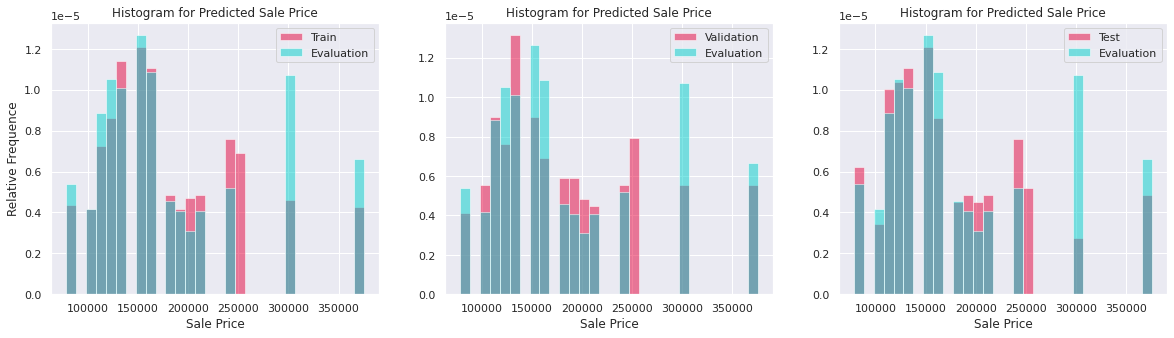

In [ ]:
#  Load test data
df_evaluation = pd.read_csv("test.csv", sep=",")

# Imputing missing values with median
df_evaluation["MasVnrArea"] = df_evaluation.MasVnrArea.fillna(df_evaluation.MasVnrArea.median())
df_evaluation["GarageYrBlt"] = df_evaluation.GarageYrBlt.fillna(df_evaluation.GarageYrBlt.median())
df_evaluation["LotFrontage"] = df_evaluation.LotFrontage.fillna(df_evaluation.LotFrontage.median())
df_evaluation["BsmtFinSF1"] = df_evaluation.BsmtFinSF1.fillna(df_evaluation.BsmtFinSF1.median())
df_evaluation["BsmtFinSF2"] = df_evaluation.BsmtFinSF2.fillna(df_evaluation.BsmtFinSF2.median())
df_evaluation["BsmtUnfSF"] = df_evaluation.BsmtUnfSF.fillna(df_evaluation.BsmtUnfSF.median())
df_evaluation["TotalBsmtSF"] = df_evaluation.TotalBsmtSF.fillna(df_evaluation.TotalBsmtSF.median())
df_evaluation["BsmtFullBath"] = df_evaluation.BsmtFullBath.fillna(df_evaluation.BsmtFullBath.median())
df_evaluation["BsmtHalfBath"] = df_evaluation.BsmtHalfBath.fillna(df_evaluation.BsmtHalfBath.median())
df_evaluation["GarageCars"] = df_evaluation.LotFrontage.fillna(df_evaluation.GarageCars.median())
df_evaluation["GarageArea"] = df_evaluation.GarageArea.fillna(df_evaluation.GarageArea.median())

# Imputing missing values with median
df_evaluation["MasVnrType"] = df_evaluation.MasVnrType.fillna(df_evaluation.MasVnrType.mode()[0])
df_evaluation["BsmtQual"] = df_evaluation.BsmtQual.fillna(df_evaluation.BsmtQual.mode()[0])
df_evaluation["BsmtCond"] = df_evaluation.BsmtCond.fillna(df_evaluation.BsmtCond.mode()[0])
df_evaluation["BsmtExposure"] = df_evaluation.BsmtExposure.fillna(df_evaluation.BsmtExposure.mode()[0])
df_evaluation["BsmtFinType1"] = df_evaluation.BsmtFinType1.fillna(df_evaluation.BsmtFinType1.mode()[0])
df_evaluation["BsmtFinType2"] = df_evaluation.BsmtFinType2.fillna(df_evaluation.BsmtFinType2.mode()[0])
df_evaluation["Electrical"] = df_evaluation.Electrical.fillna(df_evaluation.Electrical.mode()[0])
df_evaluation["GarageType"] = df_evaluation.GarageType.fillna(df_evaluation.GarageType.mode()[0])
df_evaluation["GarageFinish"] = df_evaluation.GarageFinish.fillna(df_evaluation.GarageFinish.mode()[0])
df_evaluation["GarageQual"] = df_evaluation.GarageQual.fillna(df_evaluation.GarageQual.mode()[0])
df_evaluation["GarageCond"] = df_evaluation.GarageCond.fillna(df_evaluation.GarageCond.mode()[0])

df_evaluation["MSZoning"] = df_evaluation.MSZoning.fillna(df_evaluation.MSZoning.mode()[0])
df_evaluation["Street"] = df_evaluation.Street.fillna(df_evaluation.Street.mode()[0])
df_evaluation["Alley"] = df_evaluation.Alley.fillna(df_evaluation.Alley.mode()[0])
df_evaluation["LotShape"] = df_evaluation.LotShape.fillna(df_evaluation.LotShape.mode()[0])
df_evaluation["LandContour"] = df_evaluation.LandContour.fillna(df_evaluation.LandContour.mode()[0])
df_evaluation["Utilities"] = df_evaluation.Utilities.fillna(df_evaluation.Utilities.mode()[0])
df_evaluation["LotConfig"] = df_evaluation.LotConfig.fillna(df_evaluation.LotConfig.mode()[0])
df_evaluation["LandSlope"] = df_evaluation.LandSlope.fillna(df_evaluation.LandSlope.mode()[0])
df_evaluation["Neighborhood"] = df_evaluation.Neighborhood.fillna(df_evaluation.Neighborhood.mode()[0])
df_evaluation["Condition1"] = df_evaluation.Condition1.fillna(df_evaluation.Condition1.mode()[0])
df_evaluation["Condition2"] = df_evaluation.Condition2.fillna(df_evaluation.Condition2.mode()[0])
df_evaluation["BldgType"] = df_evaluation.BldgType.fillna(df_evaluation.BldgType.mode()[0])
df_evaluation["HouseStyle"] = df_evaluation.HouseStyle.fillna(df_evaluation.HouseStyle.mode()[0])
df_evaluation["RoofStyle"] = df_evaluation.RoofStyle.fillna(df_evaluation.RoofStyle.mode()[0])
df_evaluation["RoofMatl"] = df_evaluation.RoofMatl.fillna(df_evaluation.RoofMatl.mode()[0])
df_evaluation["Exterior1st"] = df_evaluation.Exterior1st.fillna(df_evaluation.Exterior1st.mode()[0])
df_evaluation["Exterior2nd"] = df_evaluation.Exterior2nd.fillna(df_evaluation.Exterior2nd.mode()[0])
df_evaluation["ExterQual"] = df_evaluation.ExterQual.fillna(df_evaluation.ExterQual.mode()[0])
df_evaluation["ExterCond"] = df_evaluation.ExterCond.fillna(df_evaluation.ExterCond.mode()[0])
df_evaluation["Foundation"] = df_evaluation.Foundation.fillna(df_evaluation.Foundation.mode()[0])
df_evaluation["Heating"] = df_evaluation.Heating.fillna(df_evaluation.Heating.mode()[0])
df_evaluation["HeatingQC"] = df_evaluation.HeatingQC.fillna(df_evaluation.HeatingQC.mode()[0])
df_evaluation["CentralAir"] = df_evaluation.CentralAir.fillna(df_evaluation.CentralAir.mode()[0])
df_evaluation["KitchenQual"] = df_evaluation.KitchenQual.fillna(df_evaluation.KitchenQual.mode()[0])
df_evaluation["Functional"] = df_evaluation.Functional.fillna(df_evaluation.Functional.mode()[0])
df_evaluation["PavedDrive"] = df_evaluation.PavedDrive.fillna(df_evaluation.PavedDrive.mode()[0])
df_evaluation["PoolQC"] = df_evaluation.PoolQC.fillna(df_evaluation.PoolQC.mode()[0])
df_evaluation["Fence"] = df_evaluation.Fence.fillna(df_evaluation.Fence.mode()[0])
df_evaluation["MiscFeature"] = df_evaluation.MiscFeature.fillna(df_evaluation.MiscFeature.mode()[0])
df_evaluation["SaleType"] = df_evaluation.SaleType.fillna(df_evaluation.SaleType.mode()[0])
df_evaluation["SaleCondition"] = df_evaluation.SaleCondition.fillna(df_evaluation.SaleCondition.mode()[0])
df_evaluation["FireplaceQu"] = df_evaluation.FireplaceQu.fillna(df_evaluation.FireplaceQu.mode()[0])

# Create dummie variables and stack them with the previous dataframe

df_evaluation = pd.concat([df_evaluation, pd.get_dummies(df_evaluation.MSZoning, prefix='MSZoning_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Street, prefix='Street_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Alley, prefix='Alley_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotShape, prefix='LotShape_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandContour, prefix='LandContour_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Utilities, prefix='Utilities_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotConfig, prefix='LotConfig_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandSlope, prefix='LandSlope_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Neighborhood, prefix='Neighborhood_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition1, prefix='Condition1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition2, prefix='Condition2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BldgType, prefix='BldgType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HouseStyle, prefix='HouseStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofStyle, prefix='RoofStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofMatl, prefix='RoofMatl_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior1st, prefix='Exterior1st_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior2nd, prefix='Exterior2nd_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MasVnrType, prefix='MasVnrType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterQual, prefix='ExterQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterCond, prefix='ExterCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Foundation, prefix='Foundation_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtQual, prefix='BsmtQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtCond, prefix='BsmtCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtExposure, prefix='BsmtExposure_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType1, prefix='BsmtFinType1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType2, prefix='BsmtFinType2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Heating, prefix='Heating_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HeatingQC, prefix='HeatingQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.CentralAir, prefix='CentralAir_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Electrical, prefix='Electrical_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.KitchenQual, prefix='KitchenQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Functional, prefix='Functional_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.FireplaceQu, prefix='FireplaceQu_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageType, prefix='GarageType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageFinish, prefix='GarageFinish_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageQual, prefix='GarageQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageCond, prefix='GarageCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PavedDrive, prefix='PavedDrive_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PoolQC, prefix='PoolQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Fence, prefix='Fence_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MiscFeature, prefix='MiscFeature_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleType, prefix='SaleType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleCondition, prefix='SaleCondition_DM',drop_first=False)
          ], axis=1)

# Select only used variables 
df_evaluation_mod = df_evaluation.loc[:, df_evaluation.columns.isin(vars_select)].copy()
print("X Test shape:",df_evaluation_mod.shape)

# Make prediction over evaluation data
df_evaluation_mod['SalePrice'] = pd.DataFrame(np.expm1(dt_grid.best_estimator_.predict(df_evaluation_mod)))
df_evaluation_mod['SalePrice']=np.where(df_evaluation_mod['SalePrice']<0, 0, df_evaluation_mod['SalePrice'])
df_evaluation_mod = pd.concat([df_evaluation['Id'].reset_index(drop=True), df_evaluation_mod['SalePrice']], axis=1)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(ypred_train.iloc[:,0]),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(ypred_val.iloc[:,0]),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(ypred_test.iloc[:,0]),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation_mod.to_csv(submissions_path + '/House_Prices_ART_DT_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'dt'
df_train_ens = pd.concat([df_train_ens, np.expm1(ypred_train.iloc[:,0])], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens, np.expm1(ypred_val.iloc[:,0])], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens, np.expm1(ypred_test.iloc[:,0])], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation_mod.SalePrice], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Support Vector Machine technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

# Select the explanatory variables to be used
vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','TotRmsAbvGrd','YearRemodAdd'
 ,'GarageYrBlt','Fireplaces','MasVnrArea','LotArea','BsmtFinSF1','OpenPorchSF','LotFrontage','WoodDeckSF','HalfBath','2ndFlrSF'
 ,'BsmtFullBath','BedroomAbvGr','BsmtUnfSF','EnclosedPorch','KitchenAbvGr','OverallCond','ScreenPorch','PoolArea','MSSubClass'
 ,'MoSold','BsmtFinSF2','3SsnPorch','YrSold','LowQualFinSF','MiscVal','BsmtHalfBath' 

,'MSZoning_DM_C (all)','MSZoning_DM_FV','MSZoning_DM_RH','MSZoning_DM_RL','MSZoning_DM_RM','Street_DM_Grvl','Street_DM_Pave'
,'Alley_DM_Grvl','Alley_DM_Pave','LotShape_DM_IR1','LotShape_DM_IR2','LotShape_DM_IR3','LotShape_DM_Reg','LandContour_DM_Bnk'
,'LandContour_DM_HLS','LandContour_DM_Low','LandContour_DM_Lvl','Utilities_DM_AllPub','LotConfig_DM_Corner'
,'LotConfig_DM_CulDSac','LotConfig_DM_FR2','LotConfig_DM_FR3','LotConfig_DM_Inside','LandSlope_DM_Gtl','LandSlope_DM_Mod'
,'LandSlope_DM_Sev','Neighborhood_DM_Blmngtn','Neighborhood_DM_Blueste','Neighborhood_DM_BrDale','Neighborhood_DM_BrkSide'
,'Neighborhood_DM_ClearCr','Neighborhood_DM_CollgCr','Neighborhood_DM_Crawfor','Neighborhood_DM_Edwards','Neighborhood_DM_Gilbert'
,'Neighborhood_DM_IDOTRR','Neighborhood_DM_MeadowV','Neighborhood_DM_Mitchel','Neighborhood_DM_NAmes','Neighborhood_DM_NPkVill'
,'Neighborhood_DM_NWAmes','Neighborhood_DM_NoRidge','Neighborhood_DM_NridgHt','Neighborhood_DM_OldTown','Neighborhood_DM_SWISU'
,'Neighborhood_DM_Sawyer','Neighborhood_DM_SawyerW','Neighborhood_DM_Somerst','Neighborhood_DM_StoneBr','Neighborhood_DM_Timber'
,'Neighborhood_DM_Veenker','Condition1_DM_Artery','Condition1_DM_Feedr','Condition1_DM_Norm','Condition1_DM_PosA','Condition1_DM_PosN'
,'Condition1_DM_RRAe','Condition1_DM_RRAn','Condition1_DM_RRNe','Condition1_DM_RRNn','Condition2_DM_Artery','Condition2_DM_Feedr'
,'Condition2_DM_Norm','Condition2_DM_PosA','Condition2_DM_PosN'
,'BldgType_DM_1Fam','BldgType_DM_2fmCon','BldgType_DM_Duplex','BldgType_DM_Twnhs','BldgType_DM_TwnhsE','HouseStyle_DM_1.5Fin'
,'HouseStyle_DM_1.5Unf','HouseStyle_DM_1Story','HouseStyle_DM_2.5Unf','HouseStyle_DM_2Story','HouseStyle_DM_SFoyer'
,'HouseStyle_DM_SLvl','RoofStyle_DM_Flat','RoofStyle_DM_Gable','RoofStyle_DM_Gambrel','RoofStyle_DM_Hip','RoofStyle_DM_Mansard'
,'RoofStyle_DM_Shed','RoofMatl_DM_CompShg'
,'RoofMatl_DM_Tar&Grv','RoofMatl_DM_WdShake','RoofMatl_DM_WdShngl','Exterior1st_DM_AsbShng','Exterior1st_DM_AsphShn'
,'Exterior1st_DM_BrkComm','Exterior1st_DM_BrkFace','Exterior1st_DM_CBlock','Exterior1st_DM_CemntBd','Exterior1st_DM_HdBoard'
,'Exterior1st_DM_MetalSd','Exterior1st_DM_Plywood','Exterior1st_DM_Stucco'
,'Exterior1st_DM_VinylSd','Exterior1st_DM_Wd Sdng','Exterior1st_DM_WdShing','Exterior2nd_DM_AsbShng','Exterior2nd_DM_AsphShn'
,'Exterior2nd_DM_Brk Cmn','Exterior2nd_DM_BrkFace','Exterior2nd_DM_CBlock','Exterior2nd_DM_CmentBd','Exterior2nd_DM_HdBoard'
,'Exterior2nd_DM_ImStucc','Exterior2nd_DM_MetalSd','Exterior2nd_DM_Plywood','Exterior2nd_DM_Stone'
,'Exterior2nd_DM_Stucco','Exterior2nd_DM_VinylSd','Exterior2nd_DM_Wd Sdng','Exterior2nd_DM_Wd Shng','MasVnrType_DM_BrkCmn'
,'MasVnrType_DM_BrkFace','MasVnrType_DM_None','MasVnrType_DM_Stone','ExterQual_DM_Ex','ExterQual_DM_Fa','ExterQual_DM_Gd'
,'ExterQual_DM_TA','ExterCond_DM_Ex','ExterCond_DM_Fa','ExterCond_DM_Gd','ExterCond_DM_Po','ExterCond_DM_TA','Foundation_DM_BrkTil'
,'Foundation_DM_CBlock','Foundation_DM_PConc','Foundation_DM_Slab','Foundation_DM_Stone','Foundation_DM_Wood','BsmtQual_DM_Ex'
,'BsmtQual_DM_Fa','BsmtQual_DM_Gd','BsmtQual_DM_TA','BsmtCond_DM_Fa','BsmtCond_DM_Gd','BsmtCond_DM_Po','BsmtCond_DM_TA','BsmtExposure_DM_Av'
,'BsmtExposure_DM_Gd','BsmtExposure_DM_Mn','BsmtExposure_DM_No','BsmtFinType1_DM_ALQ','BsmtFinType1_DM_BLQ','BsmtFinType1_DM_GLQ'
,'BsmtFinType1_DM_LwQ','BsmtFinType1_DM_Rec','BsmtFinType1_DM_Unf','BsmtFinType2_DM_ALQ','BsmtFinType2_DM_BLQ','BsmtFinType2_DM_GLQ'
,'BsmtFinType2_DM_LwQ','BsmtFinType2_DM_Rec','BsmtFinType2_DM_Unf','Heating_DM_GasA','Heating_DM_GasW','Heating_DM_Grav'
,'Heating_DM_Wall','HeatingQC_DM_Ex','HeatingQC_DM_Fa','HeatingQC_DM_Gd','HeatingQC_DM_Po','HeatingQC_DM_TA'
,'CentralAir_DM_N','CentralAir_DM_Y','Electrical_DM_FuseA','Electrical_DM_FuseF','Electrical_DM_FuseP'
,'Electrical_DM_SBrkr','KitchenQual_DM_Ex','KitchenQual_DM_Fa','KitchenQual_DM_Gd','KitchenQual_DM_TA','Functional_DM_Maj1'
,'Functional_DM_Maj2','Functional_DM_Min1','Functional_DM_Min2','Functional_DM_Mod','Functional_DM_Sev','Functional_DM_Typ'
,'FireplaceQu_DM_Ex','FireplaceQu_DM_Fa','FireplaceQu_DM_Gd','FireplaceQu_DM_Po','FireplaceQu_DM_TA','GarageType_DM_2Types'
,'GarageType_DM_Attchd','GarageType_DM_Basment','GarageType_DM_BuiltIn','GarageType_DM_CarPort','GarageType_DM_Detchd'
,'GarageFinish_DM_Fin','GarageFinish_DM_RFn','GarageFinish_DM_Unf','GarageQual_DM_Fa','GarageQual_DM_Gd'
,'GarageQual_DM_Po','GarageQual_DM_TA','GarageCond_DM_Ex','GarageCond_DM_Fa','GarageCond_DM_Gd','GarageCond_DM_Po'
,'GarageCond_DM_TA','PavedDrive_DM_N','PavedDrive_DM_P','PavedDrive_DM_Y','PoolQC_DM_Ex','PoolQC_DM_Gd'
,'Fence_DM_GdPrv','Fence_DM_GdWo','Fence_DM_MnPrv','Fence_DM_MnWw','MiscFeature_DM_Gar2','MiscFeature_DM_Othr','MiscFeature_DM_Shed'
,'SaleType_DM_COD','SaleType_DM_CWD','SaleType_DM_Con','SaleType_DM_ConLD','SaleType_DM_ConLI','SaleType_DM_ConLw'
,'SaleType_DM_New','SaleType_DM_Oth','SaleType_DM_WD','SaleCondition_DM_Abnorml','SaleCondition_DM_AdjLand','SaleCondition_DM_Alloca'
,'SaleCondition_DM_Family','SaleCondition_DM_Normal','SaleCondition_DM_Partial' 
               ]
  
# vars_select = [ 'OverallQual', 'GrLivArea']

vars_select = ['GrLivArea', 'OverallQual', 'TotalBsmtSF', 'LotArea', 'YearRemodAdd']


x = new_df.loc[:, new_df.columns.isin(vars_select)].copy()
# Select the response variable (we take the long since it's recommended for large-scaled variables)
y = new_df.loc[:, new_df.columns == "SalePrice"].copy()
# y = np.log(new_df.loc[:, new_df.columns == "SalePrice"].copy())

# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 30% of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/SVM_model.pkl','rb')
  svm_grid = pickle.load(infile)

else:
  from sklearn.model_selection import KFold, cross_val_score
  from hyperopt import Trials, fmin, space_eval, tpe, hp, anneal
  random_state = 0

  num_folds=5
  kf = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # we use this params to create a new LGBM Regressor
      model =  model = SVR(cache_size=7000, **params)

      # and then conduct the cross validation with the same folds as before
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1,error_score='raise').mean()

      return score

  trials = Trials()

  parameters = {'C': hp.choice('C', np.arange(0.01,1.0,0.1))
                , 'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid'])
                # , 'kernel': hp.choice('kernel',['linear'])
                # , 'degree':hp.choice('degree',[2,3,4])
                # , 'gamma': hp.uniform('gamma', 0, 20)
      }
      
  best=fmin(fn=param_selection_cv, # function to optimize
            space=parameters, 
            algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
            max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )

  best_params = space_eval(parameters, best)

  svm_grid = SVR(cache_size=7000, C=best_params['C'],
                      kernel=best_params['kernel'])

  svm_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/SVM_model.pkl', 'wb') as pickfile:
     pickle.dump(svm_grid, pickfile)

print("======================================================================================")
print("Best parameters found: ")
# print(best_params)

print("======================================================================================")
# Predict values of regression with train
ypred_train = pd.DataFrame(svm_grid.predict(x_train))
# Predict values of regression with validation
ypred_val = pd.DataFrame(svm_grid.predict(x_val))
# Predict values of regression with test
ypred_test = pd.DataFrame(svm_grid.predict(x_test))

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(svm_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (876, 5)
Y Train shape: (876, 1)
X Validation shape: (292, 5)
Y Validation shape: (292, 1)
X Test shape: (292, 5)
Y Test shape: (292, 1)
Best parameters found: 
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.25351, 0.24253, 0.23517
Feature importance:
Ejecución: 0.4893796443939209 seconds


X Test shape: (1459, 5)


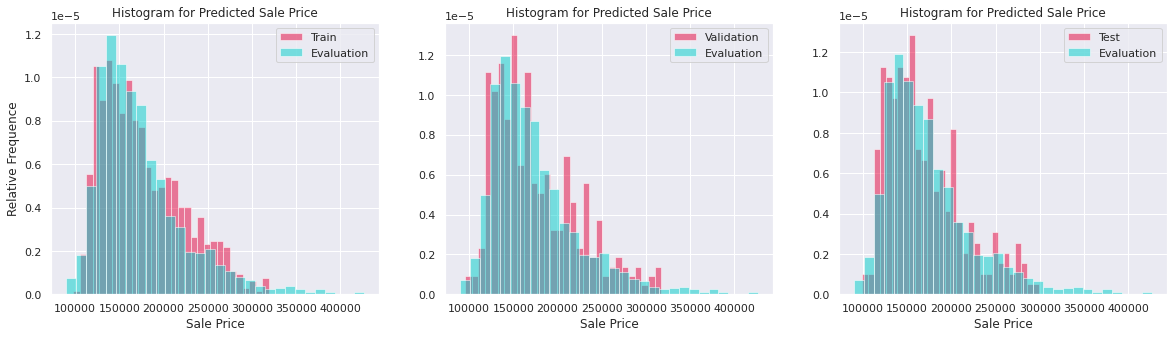

In [ ]:
#  Load test data
df_evaluation = pd.read_csv("test.csv", sep=",")

# Imputing missing values with median
df_evaluation["MasVnrArea"] = df_evaluation.MasVnrArea.fillna(df_evaluation.MasVnrArea.median())
df_evaluation["GarageYrBlt"] = df_evaluation.GarageYrBlt.fillna(df_evaluation.GarageYrBlt.median())
df_evaluation["LotFrontage"] = df_evaluation.LotFrontage.fillna(df_evaluation.LotFrontage.median())
df_evaluation["BsmtFinSF1"] = df_evaluation.BsmtFinSF1.fillna(df_evaluation.BsmtFinSF1.median())
df_evaluation["BsmtFinSF2"] = df_evaluation.BsmtFinSF2.fillna(df_evaluation.BsmtFinSF2.median())
df_evaluation["BsmtUnfSF"] = df_evaluation.BsmtUnfSF.fillna(df_evaluation.BsmtUnfSF.median())
df_evaluation["TotalBsmtSF"] = df_evaluation.TotalBsmtSF.fillna(df_evaluation.TotalBsmtSF.median())
df_evaluation["BsmtFullBath"] = df_evaluation.BsmtFullBath.fillna(df_evaluation.BsmtFullBath.median())
df_evaluation["BsmtHalfBath"] = df_evaluation.BsmtHalfBath.fillna(df_evaluation.BsmtHalfBath.median())
df_evaluation["GarageCars"] = df_evaluation.LotFrontage.fillna(df_evaluation.GarageCars.median())
df_evaluation["GarageArea"] = df_evaluation.GarageArea.fillna(df_evaluation.GarageArea.median())

# Imputing missing values with median
df_evaluation["MasVnrType"] = df_evaluation.MasVnrType.fillna(df_evaluation.MasVnrType.mode()[0])
df_evaluation["BsmtQual"] = df_evaluation.BsmtQual.fillna(df_evaluation.BsmtQual.mode()[0])
df_evaluation["BsmtCond"] = df_evaluation.BsmtCond.fillna(df_evaluation.BsmtCond.mode()[0])
df_evaluation["BsmtExposure"] = df_evaluation.BsmtExposure.fillna(df_evaluation.BsmtExposure.mode()[0])
df_evaluation["BsmtFinType1"] = df_evaluation.BsmtFinType1.fillna(df_evaluation.BsmtFinType1.mode()[0])
df_evaluation["BsmtFinType2"] = df_evaluation.BsmtFinType2.fillna(df_evaluation.BsmtFinType2.mode()[0])
df_evaluation["Electrical"] = df_evaluation.Electrical.fillna(df_evaluation.Electrical.mode()[0])
df_evaluation["GarageType"] = df_evaluation.GarageType.fillna(df_evaluation.GarageType.mode()[0])
df_evaluation["GarageFinish"] = df_evaluation.GarageFinish.fillna(df_evaluation.GarageFinish.mode()[0])
df_evaluation["GarageQual"] = df_evaluation.GarageQual.fillna(df_evaluation.GarageQual.mode()[0])
df_evaluation["GarageCond"] = df_evaluation.GarageCond.fillna(df_evaluation.GarageCond.mode()[0])

df_evaluation["MSZoning"] = df_evaluation.MSZoning.fillna(df_evaluation.MSZoning.mode()[0])
df_evaluation["Street"] = df_evaluation.Street.fillna(df_evaluation.Street.mode()[0])
df_evaluation["Alley"] = df_evaluation.Alley.fillna(df_evaluation.Alley.mode()[0])
df_evaluation["LotShape"] = df_evaluation.LotShape.fillna(df_evaluation.LotShape.mode()[0])
df_evaluation["LandContour"] = df_evaluation.LandContour.fillna(df_evaluation.LandContour.mode()[0])
df_evaluation["Utilities"] = df_evaluation.Utilities.fillna(df_evaluation.Utilities.mode()[0])
df_evaluation["LotConfig"] = df_evaluation.LotConfig.fillna(df_evaluation.LotConfig.mode()[0])
df_evaluation["LandSlope"] = df_evaluation.LandSlope.fillna(df_evaluation.LandSlope.mode()[0])
df_evaluation["Neighborhood"] = df_evaluation.Neighborhood.fillna(df_evaluation.Neighborhood.mode()[0])
df_evaluation["Condition1"] = df_evaluation.Condition1.fillna(df_evaluation.Condition1.mode()[0])
df_evaluation["Condition2"] = df_evaluation.Condition2.fillna(df_evaluation.Condition2.mode()[0])
df_evaluation["BldgType"] = df_evaluation.BldgType.fillna(df_evaluation.BldgType.mode()[0])
df_evaluation["HouseStyle"] = df_evaluation.HouseStyle.fillna(df_evaluation.HouseStyle.mode()[0])
df_evaluation["RoofStyle"] = df_evaluation.RoofStyle.fillna(df_evaluation.RoofStyle.mode()[0])
df_evaluation["RoofMatl"] = df_evaluation.RoofMatl.fillna(df_evaluation.RoofMatl.mode()[0])
df_evaluation["Exterior1st"] = df_evaluation.Exterior1st.fillna(df_evaluation.Exterior1st.mode()[0])
df_evaluation["Exterior2nd"] = df_evaluation.Exterior2nd.fillna(df_evaluation.Exterior2nd.mode()[0])
df_evaluation["ExterQual"] = df_evaluation.ExterQual.fillna(df_evaluation.ExterQual.mode()[0])
df_evaluation["ExterCond"] = df_evaluation.ExterCond.fillna(df_evaluation.ExterCond.mode()[0])
df_evaluation["Foundation"] = df_evaluation.Foundation.fillna(df_evaluation.Foundation.mode()[0])
df_evaluation["Heating"] = df_evaluation.Heating.fillna(df_evaluation.Heating.mode()[0])
df_evaluation["HeatingQC"] = df_evaluation.HeatingQC.fillna(df_evaluation.HeatingQC.mode()[0])
df_evaluation["CentralAir"] = df_evaluation.CentralAir.fillna(df_evaluation.CentralAir.mode()[0])
df_evaluation["KitchenQual"] = df_evaluation.KitchenQual.fillna(df_evaluation.KitchenQual.mode()[0])
df_evaluation["Functional"] = df_evaluation.Functional.fillna(df_evaluation.Functional.mode()[0])
df_evaluation["PavedDrive"] = df_evaluation.PavedDrive.fillna(df_evaluation.PavedDrive.mode()[0])
df_evaluation["PoolQC"] = df_evaluation.PoolQC.fillna(df_evaluation.PoolQC.mode()[0])
df_evaluation["Fence"] = df_evaluation.Fence.fillna(df_evaluation.Fence.mode()[0])
df_evaluation["MiscFeature"] = df_evaluation.MiscFeature.fillna(df_evaluation.MiscFeature.mode()[0])
df_evaluation["SaleType"] = df_evaluation.SaleType.fillna(df_evaluation.SaleType.mode()[0])
df_evaluation["SaleCondition"] = df_evaluation.SaleCondition.fillna(df_evaluation.SaleCondition.mode()[0])
df_evaluation["FireplaceQu"] = df_evaluation.FireplaceQu.fillna(df_evaluation.FireplaceQu.mode()[0])

# Create dummie variables and stack them with the previous dataframe

df_evaluation = pd.concat([df_evaluation, pd.get_dummies(df_evaluation.MSZoning, prefix='MSZoning_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Street, prefix='Street_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Alley, prefix='Alley_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotShape, prefix='LotShape_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandContour, prefix='LandContour_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Utilities, prefix='Utilities_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotConfig, prefix='LotConfig_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandSlope, prefix='LandSlope_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Neighborhood, prefix='Neighborhood_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition1, prefix='Condition1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition2, prefix='Condition2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BldgType, prefix='BldgType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HouseStyle, prefix='HouseStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofStyle, prefix='RoofStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofMatl, prefix='RoofMatl_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior1st, prefix='Exterior1st_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior2nd, prefix='Exterior2nd_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MasVnrType, prefix='MasVnrType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterQual, prefix='ExterQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterCond, prefix='ExterCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Foundation, prefix='Foundation_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtQual, prefix='BsmtQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtCond, prefix='BsmtCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtExposure, prefix='BsmtExposure_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType1, prefix='BsmtFinType1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType2, prefix='BsmtFinType2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Heating, prefix='Heating_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HeatingQC, prefix='HeatingQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.CentralAir, prefix='CentralAir_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Electrical, prefix='Electrical_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.KitchenQual, prefix='KitchenQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Functional, prefix='Functional_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.FireplaceQu, prefix='FireplaceQu_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageType, prefix='GarageType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageFinish, prefix='GarageFinish_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageQual, prefix='GarageQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageCond, prefix='GarageCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PavedDrive, prefix='PavedDrive_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PoolQC, prefix='PoolQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Fence, prefix='Fence_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MiscFeature, prefix='MiscFeature_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleType, prefix='SaleType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleCondition, prefix='SaleCondition_DM',drop_first=False)
          ], axis=1)

# Select only used variables 
df_evaluation_mod = df_evaluation.loc[:, df_evaluation.columns.isin(vars_select)].copy()
print("X Test shape:",df_evaluation_mod.shape)

# Make prediction over evaluation data
df_evaluation_mod['SalePrice'] = pd.DataFrame(np.expm1(svm_grid.predict(df_evaluation_mod)))
df_evaluation_mod['SalePrice']=np.where(df_evaluation_mod['SalePrice']<0, 0, df_evaluation_mod['SalePrice'])
df_evaluation_mod = pd.concat([df_evaluation['Id'].reset_index(drop=True), df_evaluation_mod['SalePrice']], axis=1)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(ypred_train.iloc[:,0]),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(ypred_val.iloc[:,0]),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(ypred_test.iloc[:,0]),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation_mod.to_csv(submissions_path + '/House_Prices_ART_SVM_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'svm'
df_train_ens = pd.concat([df_train_ens, np.expm1(ypred_train.iloc[:,0])], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens, np.expm1(ypred_val.iloc[:,0])], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens, np.expm1(ypred_test.iloc[:,0])], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation_mod.SalePrice], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Appying Ensemble Method

In [ ]:
from itertools import combinations
def get_all_combinations(L):

  combs = []
  for n in range(0,len(L)+1):
      combs = combs + ([i for i in combinations(L,n)])

  return combs

In [ ]:
# df_train_ens
list_models = df_train_ens.columns
list_models

Index(['xgb', 'rf', 'lgbm', 'lasso', 'ridge', 'enet', 'ann', 'dt', 'svm'], dtype='object')

In [ ]:
possible_combs = get_all_combinations(list_models)
len(possible_combs)

512

In [ ]:
df_train_ens.mean(axis=1)



0      3.058849e+07
1      4.069204e+05
2      3.103055e+06
3      2.119580e+06
4      2.093384e+05
           ...     
871    3.162598e+05
872    2.491917e+05
873    1.807524e+05
874    2.476512e+06
875    2.934118e+09
Length: 876, dtype: float64

In [ ]:
df_train_ens_log = df_train_ens.apply(lambda x : np.log1p(x))
df_val_ens_log = df_val_ens.apply(lambda x : np.log1p(x))
df_test_ens_log = df_test_ens.apply(lambda x : np.log1p(x))
df_eva_ens_log = df_eva_ens.apply(lambda x : np.log1p(x))

In [ ]:
best_val_rmse = 999

for i in possible_combs:
  if len(list(i)) > 1:
    mean_train = df_train_ens_log[list(i)].mean(axis=1)
    mean_val = df_val_ens_log[list(i)].mean(axis=1)
    mean_test = df_test_ens_log[list(i)].mean(axis=1)
    mean_eva = df_eva_ens_log[list(i)].mean(axis=1)


    if rmse(y_val, mean_val) < best_val_rmse:
            best_val_rmse = rmse(y_val, mean_val)
            best_comb = list(i)

print(best_val_rmse)
print(best_comb)

0.5000252465756131
['rf', 'svm']


# Training model only with obtained scores

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

# Select the explanatory variables to be used
vars_select = [ 'xgb', 'rf', 'lgbm', 'lasso', 'ridge', 'enet', 'ann', 'dt', 'svm']

x_train_em = df_train_ens_log[vars_select]
x_val_em = df_val_ens_log[vars_select]
x_test_em = df_test_ens_log[vars_select]

print("======================================================================================")
print("X Train shape:",x_train_em.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val_em.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test_em.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/XGboost_model_em.pkl','rb')
  xgb_grid_em = pickle.load(infile)

else:
  #Define the grid to be searched in
  xgb1_em = XGBRegressor(random_state=0)
  parameters = {'max_depth':range(3,10,2),
              'min_child_weight':range(1,6,2),
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2]}

  #Execute cross-validated grid search
  xgb_grid_em = GridSearchCV(xgb1_em, parameters, cv = 5, n_jobs = -1, verbose=False)
  # Train Model
  xgb_grid_em.fit(x_train_em,y_train)
  #Save model
  with open(models_path + '/XGboost_model_em.pkl', 'wb') as pickfile:
     pickle.dump(xgb_grid_em, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(xgb_grid_em.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = pd.DataFrame(xgb_grid_em.best_estimator_.predict(x_train_em))
# Predict values of regression with validation
ypred_val = pd.DataFrame(xgb_grid_em.best_estimator_.predict(x_val_em))
# Predict values of regression with test
ypred_test = pd.DataFrame(xgb_grid_em.best_estimator_.predict(x_test_em))

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
imps = permutation_importance(xgb_grid_em.best_estimator_, x_train_em, y_train)

# Create dummie variables and stack them with the previous dataframe
importance = pd.concat([pd.DataFrame(x_train_em.columns), pd.DataFrame(imps.importances_mean)], axis=1)
importance.columns = ["variable","importance"]

importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (876, 9)
Y Train shape: (876, 1)
X Validation shape: (292, 9)
Y Validation shape: (292, 1)
X Test shape: (292, 9)
Y Test shape: (292, 1)
[07:52:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found: 
{'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.01539, 0.54724, 0.57100
Feature importance:
  variable  importance
2     lgbm    1.033124
1       rf    0.470699
3    lasso    0.013139
0      xgb    0.011203
7       dt    0.010271
4    ridge    0.001898
8      svm    0.001871
6      ann    0.001096
5     enet    0.000296
Ejecución: 39.66287302970886 seconds


## Train model with obtained scores and variables

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = False

# Select the explanatory variables to be used
vars_select = [ 'xgb', 'rf', 'lgbm', 'lasso', 'ridge', 'enet', 'ann', 'dt', 'svm']

x_train_em = pd.concat([df_train_ens_log[vars_select].reset_index(drop=True), x_train.reset_index(drop=True)], axis = 1)
x_val_em = pd.concat([df_val_ens_log[vars_select].reset_index(drop=True), x_val.reset_index(drop=True)], axis = 1)
x_test_em = pd.concat([df_test_ens_log[vars_select].reset_index(drop=True), x_test.reset_index(drop=True)], axis = 1)

print("======================================================================================")
print("X Train shape:",x_train_em.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val_em.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test_em.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/XGboost_model_em.pkl','rb')
  xgb_grid_em = pickle.load(infile)

else:
  #Define the grid to be searched in
  xgb1_em = XGBRegressor(random_state=0)
  parameters = {'max_depth':range(3,10,2),
              'min_child_weight':range(1,6,2),
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2]}

  #Execute cross-validated grid search
  xgb_grid_em = GridSearchCV(xgb1_em, parameters, cv = 5, n_jobs = -1, verbose=False)
  # Train Model
  xgb_grid_em.fit(x_train_em,y_train)
  #Save model
  with open(models_path + '/XGboost_model_em.pkl', 'wb') as pickfile:
     pickle.dump(xgb_grid_em, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(xgb_grid_em.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = pd.DataFrame(xgb_grid_em.best_estimator_.predict(x_train_em))
# Predict values of regression with validation
ypred_val = pd.DataFrame(xgb_grid_em.best_estimator_.predict(x_val_em))
# Predict values of regression with test
ypred_test = pd.DataFrame(xgb_grid_em.best_estimator_.predict(x_test_em))

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
imps = permutation_importance(xgb_grid_em.best_estimator_, x_train_em, y_train)

# Create dummie variables and stack them with the previous dataframe
importance = pd.concat([pd.DataFrame(x_train_em.columns), pd.DataFrame(imps.importances_mean)], axis=1)
importance.columns = ["variable","importance"]

importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (876, 14)
Y Train shape: (876, 1)
X Validation shape: (292, 14)
Y Validation shape: (292, 1)
X Test shape: (292, 14)
Y Test shape: (292, 1)
[07:52:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found: 
{'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.01122, 0.55867, 0.58002
Feature importance:
        variable  importance
2           lgbm    0.996688
1             rf    0.456803
3          lasso    0.007314
0            xgb    0.006646
7             dt    0.003928
4          ridge    0.001772
6            ann    0.001215
8            svm    0.001211
12   TotalBsmtSF    0.001158
11  YearRemodAdd    0.000806
5           enet    0.000504
13     GrLivArea    0.000487
9        LotArea    0.000486
10   OverallQual    0.000450
Ejecución: 32.817994832992554 seconds


# Stacking models

In [ ]:
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Process of modelling K-Folds cross-validator
# Provides train/test indices to split data in train/test sets. 


# defining error functions for handy use. 

kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=x_train, y=y_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5,16,17,20,25,30,35,40,50,55,60,65,70,80,90]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]

e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002, 0.003, 0.004, 0.005]
e_l1ratio = [0.08, 0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99, 1]

# svr_c = [11,13,15,17,19,21,23,25]
# svr_epsilon = [0.007,0.008,0.009]
# svr_gamma = [0.0003,0.0004,0.0005,0.0006]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)

rfr = RandomForestRegressor(n_estimators=100, random_state=42)

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [ ]:

# Select the explanatory variables to be used
vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','TotRmsAbvGrd','YearRemodAdd'
 ,'GarageYrBlt','Fireplaces','MasVnrArea','LotArea','BsmtFinSF1','OpenPorchSF','LotFrontage','WoodDeckSF','HalfBath','2ndFlrSF'
 ,'BsmtFullBath','BedroomAbvGr','BsmtUnfSF','EnclosedPorch','KitchenAbvGr','OverallCond','ScreenPorch','PoolArea','MSSubClass'
 ,'MoSold','BsmtFinSF2','3SsnPorch','YrSold','LowQualFinSF','MiscVal','BsmtHalfBath' 

,'MSZoning_DM_C (all)','MSZoning_DM_FV','MSZoning_DM_RH','MSZoning_DM_RL','MSZoning_DM_RM','Street_DM_Grvl','Street_DM_Pave'
,'Alley_DM_Grvl','Alley_DM_Pave','LotShape_DM_IR1','LotShape_DM_IR2','LotShape_DM_IR3','LotShape_DM_Reg','LandContour_DM_Bnk'
,'LandContour_DM_HLS','LandContour_DM_Low','LandContour_DM_Lvl','Utilities_DM_AllPub','LotConfig_DM_Corner'
,'LotConfig_DM_CulDSac','LotConfig_DM_FR2','LotConfig_DM_FR3','LotConfig_DM_Inside','LandSlope_DM_Gtl','LandSlope_DM_Mod'
,'LandSlope_DM_Sev','Neighborhood_DM_Blmngtn','Neighborhood_DM_Blueste','Neighborhood_DM_BrDale','Neighborhood_DM_BrkSide'
,'Neighborhood_DM_ClearCr','Neighborhood_DM_CollgCr','Neighborhood_DM_Crawfor','Neighborhood_DM_Edwards','Neighborhood_DM_Gilbert'
,'Neighborhood_DM_IDOTRR','Neighborhood_DM_MeadowV','Neighborhood_DM_Mitchel','Neighborhood_DM_NAmes','Neighborhood_DM_NPkVill'
,'Neighborhood_DM_NWAmes','Neighborhood_DM_NoRidge','Neighborhood_DM_NridgHt','Neighborhood_DM_OldTown','Neighborhood_DM_SWISU'
,'Neighborhood_DM_Sawyer','Neighborhood_DM_SawyerW','Neighborhood_DM_Somerst','Neighborhood_DM_StoneBr','Neighborhood_DM_Timber'
,'Neighborhood_DM_Veenker','Condition1_DM_Artery','Condition1_DM_Feedr','Condition1_DM_Norm','Condition1_DM_PosA','Condition1_DM_PosN'
,'Condition1_DM_RRAe','Condition1_DM_RRAn','Condition1_DM_RRNe','Condition1_DM_RRNn','Condition2_DM_Artery','Condition2_DM_Feedr'
,'Condition2_DM_Norm','Condition2_DM_PosA','Condition2_DM_PosN'
,'BldgType_DM_1Fam','BldgType_DM_2fmCon','BldgType_DM_Duplex','BldgType_DM_Twnhs','BldgType_DM_TwnhsE','HouseStyle_DM_1.5Fin'
,'HouseStyle_DM_1.5Unf','HouseStyle_DM_1Story','HouseStyle_DM_2.5Unf','HouseStyle_DM_2Story','HouseStyle_DM_SFoyer'
,'HouseStyle_DM_SLvl','RoofStyle_DM_Flat','RoofStyle_DM_Gable','RoofStyle_DM_Gambrel','RoofStyle_DM_Hip','RoofStyle_DM_Mansard'
,'RoofStyle_DM_Shed','RoofMatl_DM_CompShg'
,'RoofMatl_DM_Tar&Grv','RoofMatl_DM_WdShake','RoofMatl_DM_WdShngl','Exterior1st_DM_AsbShng','Exterior1st_DM_AsphShn'
,'Exterior1st_DM_BrkComm','Exterior1st_DM_BrkFace','Exterior1st_DM_CBlock','Exterior1st_DM_CemntBd','Exterior1st_DM_HdBoard'
,'Exterior1st_DM_MetalSd','Exterior1st_DM_Plywood','Exterior1st_DM_Stucco'
,'Exterior1st_DM_VinylSd','Exterior1st_DM_Wd Sdng','Exterior1st_DM_WdShing','Exterior2nd_DM_AsbShng','Exterior2nd_DM_AsphShn'
,'Exterior2nd_DM_Brk Cmn','Exterior2nd_DM_BrkFace','Exterior2nd_DM_CBlock','Exterior2nd_DM_CmentBd','Exterior2nd_DM_HdBoard'
,'Exterior2nd_DM_ImStucc','Exterior2nd_DM_MetalSd','Exterior2nd_DM_Plywood','Exterior2nd_DM_Stone'
,'Exterior2nd_DM_Stucco','Exterior2nd_DM_VinylSd','Exterior2nd_DM_Wd Sdng','Exterior2nd_DM_Wd Shng','MasVnrType_DM_BrkCmn'
,'MasVnrType_DM_BrkFace','MasVnrType_DM_None','MasVnrType_DM_Stone','ExterQual_DM_Ex','ExterQual_DM_Fa','ExterQual_DM_Gd'
,'ExterQual_DM_TA','ExterCond_DM_Ex','ExterCond_DM_Fa','ExterCond_DM_Gd','ExterCond_DM_Po','ExterCond_DM_TA','Foundation_DM_BrkTil'
,'Foundation_DM_CBlock','Foundation_DM_PConc','Foundation_DM_Slab','Foundation_DM_Stone','Foundation_DM_Wood','BsmtQual_DM_Ex'
,'BsmtQual_DM_Fa','BsmtQual_DM_Gd','BsmtQual_DM_TA','BsmtCond_DM_Fa','BsmtCond_DM_Gd','BsmtCond_DM_Po','BsmtCond_DM_TA','BsmtExposure_DM_Av'
,'BsmtExposure_DM_Gd','BsmtExposure_DM_Mn','BsmtExposure_DM_No','BsmtFinType1_DM_ALQ','BsmtFinType1_DM_BLQ','BsmtFinType1_DM_GLQ'
,'BsmtFinType1_DM_LwQ','BsmtFinType1_DM_Rec','BsmtFinType1_DM_Unf','BsmtFinType2_DM_ALQ','BsmtFinType2_DM_BLQ','BsmtFinType2_DM_GLQ'
,'BsmtFinType2_DM_LwQ','BsmtFinType2_DM_Rec','BsmtFinType2_DM_Unf','Heating_DM_GasA','Heating_DM_GasW','Heating_DM_Grav'
,'Heating_DM_Wall','HeatingQC_DM_Ex','HeatingQC_DM_Fa','HeatingQC_DM_Gd','HeatingQC_DM_Po','HeatingQC_DM_TA'
,'CentralAir_DM_N','CentralAir_DM_Y','Electrical_DM_FuseA','Electrical_DM_FuseF','Electrical_DM_FuseP'
,'Electrical_DM_SBrkr','KitchenQual_DM_Ex','KitchenQual_DM_Fa','KitchenQual_DM_Gd','KitchenQual_DM_TA','Functional_DM_Maj1'
,'Functional_DM_Maj2','Functional_DM_Min1','Functional_DM_Min2','Functional_DM_Mod','Functional_DM_Sev','Functional_DM_Typ'
,'FireplaceQu_DM_Ex','FireplaceQu_DM_Fa','FireplaceQu_DM_Gd','FireplaceQu_DM_Po','FireplaceQu_DM_TA','GarageType_DM_2Types'
,'GarageType_DM_Attchd','GarageType_DM_Basment','GarageType_DM_BuiltIn','GarageType_DM_CarPort','GarageType_DM_Detchd'
,'GarageFinish_DM_Fin','GarageFinish_DM_RFn','GarageFinish_DM_Unf','GarageQual_DM_Fa','GarageQual_DM_Gd'
,'GarageQual_DM_Po','GarageQual_DM_TA','GarageCond_DM_Ex','GarageCond_DM_Fa','GarageCond_DM_Gd','GarageCond_DM_Po'
,'GarageCond_DM_TA','PavedDrive_DM_N','PavedDrive_DM_P','PavedDrive_DM_Y','PoolQC_DM_Ex','PoolQC_DM_Gd'
,'Fence_DM_GdPrv','Fence_DM_GdWo','Fence_DM_MnPrv','Fence_DM_MnWw','MiscFeature_DM_Gar2','MiscFeature_DM_Othr','MiscFeature_DM_Shed'
,'SaleType_DM_COD','SaleType_DM_CWD','SaleType_DM_Con','SaleType_DM_ConLD','SaleType_DM_ConLI','SaleType_DM_ConLw'
,'SaleType_DM_New','SaleType_DM_Oth','SaleType_DM_WD','SaleCondition_DM_Abnorml','SaleCondition_DM_AdjLand','SaleCondition_DM_Alloca'
,'SaleCondition_DM_Family','SaleCondition_DM_Normal','SaleCondition_DM_Partial' 
               ]
  
# vars_select = [ 'OverallQual','GrLivArea','GarageCars','GarageArea']



x = new_df.loc[:, new_df.columns.isin(vars_select)].copy()
# Select the response variable (we take the long since it's recommended for large-scaled variables)
y = new_df.loc[:, new_df.columns == "SalePrice"].copy()
# y = np.log(new_df.loc[:, new_df.columns == "SalePrice"].copy())

# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 30% of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

In [ ]:
# Stacking - combine multiple regression models via a meta-regressor. 

# In the standard stacking procedure, the first-level regressors are fit to the same 
# training set that is used prepare the inputs for the second-level regressor,
# which may lead to overfitting. The StackingCVRegressor, however, uses the concept 
# of out-of-fold predictions: the dataset is split into k folds, and in k successive rounds, 

# In simple words, Stacking helps avoid fitting on the same data twice , 
# and is effective in reducing overfitting.

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, svr, elasticnet, gbr, xgboost, lightgbm, rfr),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

# Now, we compare the various models that we just created.
# Using various prediction models that we just created 



score = cv_rmse(rfr , x_train)
print("Random Forest: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(ridge , x_train)
print("RIDGE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso , x_train)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

Random Forest: 0.1491 (0.0165)
 2022-02-22 08:02:25.058099
RIDGE: 0.1266 (0.0156)
 2022-02-22 08:03:34.593924


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expec

LASSO: 0.1246 (0.0141)
 2022-02-22 08:03:52.107173


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expec

elastic net: 0.1249 (0.0141)
 2022-02-22 08:07:48.721224


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR: 0.1811 (0.0277)
 2022-02-22 08:07:52.911775
lightgbm: 0.1309 (0.0221)
 2022-02-22 08:08:09.552444


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

gbr: 0.1326 (0.0211)
 2022-02-22 08:11:53.855969
[08:11:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:39] WARNING: /workspace/src/objective/regression_obj.cu

In [ ]:
y_train = y_train.reset_index(drop=True)

In [ ]:
start_time = time.time()
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(x_train),np.array(y_train).reshape((x_train.shape[0],)))
print("Ejecución: %s seconds" % (time.time() - start_time))


stack_gen
[08:31:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Ejecución: 547.5063829421997 seconds
Random Forest


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Ejecución: 549.3677382469177 seconds
elasticnet


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Ejecución: 569.1645488739014 seconds
Lasso


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Ejecución: 570.8246822357178 seconds
Ridge
Ejecución: 576.7411463260651 seconds
Svr


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Ejecución: 577.056027173996 seconds
GradientBoosting


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Ejecución: 593.820193529129 seconds
xgboost
[08:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Ejecución: 609.0349540710449 seconds
lightgbm
Ejecución: 610.2756450176239 seconds


In [ ]:

print('Random Forest')
random_forest_model_full_data = rfr.fit(x_train, np.ravel(y_train))
print("Ejecución: %s seconds" % (time.time() - start_time))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(x_train, np.ravel(y_train))
print("Ejecución: %s seconds" % (time.time() - start_time))

print('Lasso')
lasso_model_full_data = lasso.fit(x_train, np.ravel(y_train))
print("Ejecución: %s seconds" % (time.time() - start_time))

print('Ridge')
ridge_model_full_data = ridge.fit(x_train, np.ravel(y_train))
print("Ejecución: %s seconds" % (time.time() - start_time))

print('Svr')
svr_model_full_data = svr.fit(x_train, np.ravel(y_train))
print("Ejecución: %s seconds" % (time.time() - start_time))

print('GradientBoosting')
gbr_model_full_data = gbr.fit(x_train, np.ravel(y_train))
print("Ejecución: %s seconds" % (time.time() - start_time))

print('xgboost')
xgb_model_full_data = xgboost.fit(x_train, np.ravel(y_train))
print("Ejecución: %s seconds" % (time.time() - start_time))

print('lightgbm')
lgb_model_full_data = lightgbm.fit(x_train, np.ravel(y_train))
print("Ejecución: %s seconds" % (time.time() - start_time))

Random Forest
Ejecución: 1370.3557574748993 seconds
elasticnet
Ejecución: 1402.1775901317596 seconds
Lasso
Ejecución: 1404.5627663135529 seconds
Ridge
Ejecución: 1411.4201655387878 seconds
Svr
Ejecución: 1411.8992516994476 seconds
GradientBoosting
Ejecución: 1448.3798515796661 seconds
xgboost
[08:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Ejecución: 1472.1510736942291 seconds
lightgbm
Ejecución: 1474.173938035965 seconds


In [ ]:
# Notice that we are using a few percent from different models to get our final answer, 
# all decimals add up to 1

def blend_models_predict(X):
    return ((0.08 * elastic_model_full_data.predict(X)) + 
            (0.08 * lasso_model_full_data.predict(X)) + 
            (0.08 * ridge_model_full_data.predict(X)) + 
            (0.08 * svr_model_full_data.predict(X)) + 
            (0.08 * random_forest_model_full_data.predict(X)) + 
            (0.1 * gbr_model_full_data.predict(X)) + 
            (0.1 * xgb_model_full_data.predict(X)) + 
            (0.1 * lgb_model_full_data.predict(X)) + 
            (0.30 * stack_gen_model.predict(np.array(X))))

print('RMSLE score on train data:')
print(rmsle(y_train, blend_models_predict(x_train)))
print(rmsle(y_val, blend_models_predict(x_val)))
print(rmsle(y_test, blend_models_predict(x_test)))
# print(rmsle(y_val, blend_models_predict(x_eva)))

RMSLE score on train data:
0.05468134930642579
0.1257964510210076
0.1012171817689044


In [ ]:
def blend_models_predict(X):
    return ((1/9 * elastic_model_full_data.predict(X)) + 
            (1/9 * lasso_model_full_data.predict(X)) + 
            (1/9 * ridge_model_full_data.predict(X)) + 
            (1/9 * svr_model_full_data.predict(X)) + 
            (1/9 * random_forest_model_full_data.predict(X)) + 
            (1/9 * gbr_model_full_data.predict(X)) + 
            (1/9 * xgb_model_full_data.predict(X)) + 
            (1/9 * lgb_model_full_data.predict(X)) + 
            (1/9 * stack_gen_model.predict(np.array(X))))

print('RMSLE score on train data:')
print(rmsle(y_train, blend_models_predict(x_train)))
print(rmsle(y_val, blend_models_predict(x_val)))
print(rmsle(y_test, blend_models_predict(x_test)))
# print(rmsle(y_val, blend_models_predict(x_eva)))

RMSLE score on train data:
0.06429756357376168
0.1274876533279025
0.10213031935291414


X Test shape: (1459, 270)


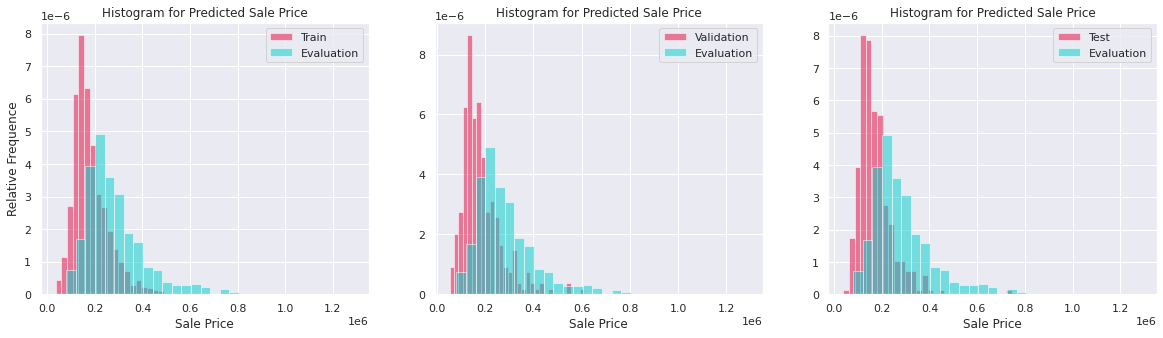

In [ ]:
#  Load test data
df_evaluation = pd.read_csv("test.csv", sep=",")

# Imputing missing values with median
df_evaluation["MasVnrArea"] = df_evaluation.MasVnrArea.fillna(df_evaluation.MasVnrArea.median())
df_evaluation["GarageYrBlt"] = df_evaluation.GarageYrBlt.fillna(df_evaluation.GarageYrBlt.median())
df_evaluation["LotFrontage"] = df_evaluation.LotFrontage.fillna(df_evaluation.LotFrontage.median())
df_evaluation["BsmtFinSF1"] = df_evaluation.BsmtFinSF1.fillna(df_evaluation.BsmtFinSF1.median())
df_evaluation["BsmtFinSF2"] = df_evaluation.BsmtFinSF2.fillna(df_evaluation.BsmtFinSF2.median())
df_evaluation["BsmtUnfSF"] = df_evaluation.BsmtUnfSF.fillna(df_evaluation.BsmtUnfSF.median())
df_evaluation["TotalBsmtSF"] = df_evaluation.TotalBsmtSF.fillna(df_evaluation.TotalBsmtSF.median())
df_evaluation["BsmtFullBath"] = df_evaluation.BsmtFullBath.fillna(df_evaluation.BsmtFullBath.median())
df_evaluation["BsmtHalfBath"] = df_evaluation.BsmtHalfBath.fillna(df_evaluation.BsmtHalfBath.median())
df_evaluation["GarageCars"] = df_evaluation.LotFrontage.fillna(df_evaluation.GarageCars.median())
df_evaluation["GarageArea"] = df_evaluation.GarageArea.fillna(df_evaluation.GarageArea.median())

# Imputing missing values with median
df_evaluation["MasVnrType"] = df_evaluation.MasVnrType.fillna(df_evaluation.MasVnrType.mode()[0])
df_evaluation["BsmtQual"] = df_evaluation.BsmtQual.fillna(df_evaluation.BsmtQual.mode()[0])
df_evaluation["BsmtCond"] = df_evaluation.BsmtCond.fillna(df_evaluation.BsmtCond.mode()[0])
df_evaluation["BsmtExposure"] = df_evaluation.BsmtExposure.fillna(df_evaluation.BsmtExposure.mode()[0])
df_evaluation["BsmtFinType1"] = df_evaluation.BsmtFinType1.fillna(df_evaluation.BsmtFinType1.mode()[0])
df_evaluation["BsmtFinType2"] = df_evaluation.BsmtFinType2.fillna(df_evaluation.BsmtFinType2.mode()[0])
df_evaluation["Electrical"] = df_evaluation.Electrical.fillna(df_evaluation.Electrical.mode()[0])
df_evaluation["GarageType"] = df_evaluation.GarageType.fillna(df_evaluation.GarageType.mode()[0])
df_evaluation["GarageFinish"] = df_evaluation.GarageFinish.fillna(df_evaluation.GarageFinish.mode()[0])
df_evaluation["GarageQual"] = df_evaluation.GarageQual.fillna(df_evaluation.GarageQual.mode()[0])
df_evaluation["GarageCond"] = df_evaluation.GarageCond.fillna(df_evaluation.GarageCond.mode()[0])

df_evaluation["MSZoning"] = df_evaluation.MSZoning.fillna(df_evaluation.MSZoning.mode()[0])
df_evaluation["Street"] = df_evaluation.Street.fillna(df_evaluation.Street.mode()[0])
df_evaluation["Alley"] = df_evaluation.Alley.fillna(df_evaluation.Alley.mode()[0])
df_evaluation["LotShape"] = df_evaluation.LotShape.fillna(df_evaluation.LotShape.mode()[0])
df_evaluation["LandContour"] = df_evaluation.LandContour.fillna(df_evaluation.LandContour.mode()[0])
df_evaluation["Utilities"] = df_evaluation.Utilities.fillna(df_evaluation.Utilities.mode()[0])
df_evaluation["LotConfig"] = df_evaluation.LotConfig.fillna(df_evaluation.LotConfig.mode()[0])
df_evaluation["LandSlope"] = df_evaluation.LandSlope.fillna(df_evaluation.LandSlope.mode()[0])
df_evaluation["Neighborhood"] = df_evaluation.Neighborhood.fillna(df_evaluation.Neighborhood.mode()[0])
df_evaluation["Condition1"] = df_evaluation.Condition1.fillna(df_evaluation.Condition1.mode()[0])
df_evaluation["Condition2"] = df_evaluation.Condition2.fillna(df_evaluation.Condition2.mode()[0])
df_evaluation["BldgType"] = df_evaluation.BldgType.fillna(df_evaluation.BldgType.mode()[0])
df_evaluation["HouseStyle"] = df_evaluation.HouseStyle.fillna(df_evaluation.HouseStyle.mode()[0])
df_evaluation["RoofStyle"] = df_evaluation.RoofStyle.fillna(df_evaluation.RoofStyle.mode()[0])
df_evaluation["RoofMatl"] = df_evaluation.RoofMatl.fillna(df_evaluation.RoofMatl.mode()[0])
df_evaluation["Exterior1st"] = df_evaluation.Exterior1st.fillna(df_evaluation.Exterior1st.mode()[0])
df_evaluation["Exterior2nd"] = df_evaluation.Exterior2nd.fillna(df_evaluation.Exterior2nd.mode()[0])
df_evaluation["ExterQual"] = df_evaluation.ExterQual.fillna(df_evaluation.ExterQual.mode()[0])
df_evaluation["ExterCond"] = df_evaluation.ExterCond.fillna(df_evaluation.ExterCond.mode()[0])
df_evaluation["Foundation"] = df_evaluation.Foundation.fillna(df_evaluation.Foundation.mode()[0])
df_evaluation["Heating"] = df_evaluation.Heating.fillna(df_evaluation.Heating.mode()[0])
df_evaluation["HeatingQC"] = df_evaluation.HeatingQC.fillna(df_evaluation.HeatingQC.mode()[0])
df_evaluation["CentralAir"] = df_evaluation.CentralAir.fillna(df_evaluation.CentralAir.mode()[0])
df_evaluation["KitchenQual"] = df_evaluation.KitchenQual.fillna(df_evaluation.KitchenQual.mode()[0])
df_evaluation["Functional"] = df_evaluation.Functional.fillna(df_evaluation.Functional.mode()[0])
df_evaluation["PavedDrive"] = df_evaluation.PavedDrive.fillna(df_evaluation.PavedDrive.mode()[0])
df_evaluation["PoolQC"] = df_evaluation.PoolQC.fillna(df_evaluation.PoolQC.mode()[0])
df_evaluation["Fence"] = df_evaluation.Fence.fillna(df_evaluation.Fence.mode()[0])
df_evaluation["MiscFeature"] = df_evaluation.MiscFeature.fillna(df_evaluation.MiscFeature.mode()[0])
df_evaluation["SaleType"] = df_evaluation.SaleType.fillna(df_evaluation.SaleType.mode()[0])
df_evaluation["SaleCondition"] = df_evaluation.SaleCondition.fillna(df_evaluation.SaleCondition.mode()[0])
df_evaluation["FireplaceQu"] = df_evaluation.FireplaceQu.fillna(df_evaluation.FireplaceQu.mode()[0])

# Create dummie variables and stack them with the previous dataframe

df_evaluation = pd.concat([df_evaluation, pd.get_dummies(df_evaluation.MSZoning, prefix='MSZoning_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Street, prefix='Street_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Alley, prefix='Alley_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotShape, prefix='LotShape_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandContour, prefix='LandContour_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Utilities, prefix='Utilities_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LotConfig, prefix='LotConfig_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.LandSlope, prefix='LandSlope_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Neighborhood, prefix='Neighborhood_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition1, prefix='Condition1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Condition2, prefix='Condition2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BldgType, prefix='BldgType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HouseStyle, prefix='HouseStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofStyle, prefix='RoofStyle_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.RoofMatl, prefix='RoofMatl_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior1st, prefix='Exterior1st_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Exterior2nd, prefix='Exterior2nd_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MasVnrType, prefix='MasVnrType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterQual, prefix='ExterQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.ExterCond, prefix='ExterCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Foundation, prefix='Foundation_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtQual, prefix='BsmtQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtCond, prefix='BsmtCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtExposure, prefix='BsmtExposure_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType1, prefix='BsmtFinType1_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.BsmtFinType2, prefix='BsmtFinType2_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Heating, prefix='Heating_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.HeatingQC, prefix='HeatingQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.CentralAir, prefix='CentralAir_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Electrical, prefix='Electrical_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.KitchenQual, prefix='KitchenQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Functional, prefix='Functional_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.FireplaceQu, prefix='FireplaceQu_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageType, prefix='GarageType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageFinish, prefix='GarageFinish_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageQual, prefix='GarageQual_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.GarageCond, prefix='GarageCond_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PavedDrive, prefix='PavedDrive_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.PoolQC, prefix='PoolQC_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.Fence, prefix='Fence_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.MiscFeature, prefix='MiscFeature_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleType, prefix='SaleType_DM',drop_first=False)
          ,pd.get_dummies(df_evaluation.SaleCondition, prefix='SaleCondition_DM',drop_first=False)
          ], axis=1)

# Select only used variables 
df_evaluation_mod = df_evaluation.loc[:, df_evaluation.columns.isin(vars_select)].copy()
print("X Test shape:",df_evaluation_mod.shape)

# Make prediction over evaluation data
df_evaluation_mod['SalePrice'] = pd.DataFrame(np.expm1(blend_models_predict(df_evaluation_mod)))
df_evaluation_mod['SalePrice']=np.where(df_evaluation_mod['SalePrice']<0, 0, df_evaluation_mod['SalePrice'])

df_evaluation_mod = pd.concat([df_evaluation['Id'].reset_index(drop=True), df_evaluation_mod['SalePrice']], axis=1)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(y_train.iloc[:,0]),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(y_val.iloc[:,0]),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(y_test.iloc[:,0]),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation_mod.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation_mod.to_csv(submissions_path + '/House_Prices_ART_ensemble_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'svm'
# df_train_ens = pd.concat([df_train_ens, np.expm1(ypred_train.iloc[:,0])], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# df_test_ens = pd.concat([df_test_ens, np.expm1(ypred_val.iloc[:,0])], axis=1)
# df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens, np.expm1(ypred_test.iloc[:,0])], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, df_evaluation_mod.SalePrice], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

In [ ]:
list(range(30,71,10))

[30, 40, 50, 60, 70]